In [44]:
import modeller
import fitter

from functions.misc import knot_fn

import casadi as ca
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import font_manager
from copy import copy
import pandas as pd
import datetime

In [45]:
%matplotlib inline

label_font = font_manager.FontProperties(
    family=['Fira Sans'],
    weight='regular',
    size=20
)
tick_font = font_manager.FontProperties(
    family=['Fira Sans'],
    weight='regular',
    size=14
)

## Analysis of total cases

![](out/seihrd.png)

This is the idealised SEIR model with isolation (Hospitalisation) and Deaths. In the model below, we also want to capture the discharge information (H to R) so we capture them in a new compartment G (discharGe).

The data we have is:
- newly reported cases (entries into the I compartment)
- cumulative newly reported cases (square I box)
- number of people in isolation (H)
- cumulative number of people ever in isolation (square box H)
- number of discharged from isolation
- number of deaths

In [3]:
def seir(t, y, p):
    b, g, e, d, a, m = p[:6]
    S,E,I,H,G,R,D,cE,cH = y[:9]
    return [
        -b*S*I/(S+E+I+H+G+R),
        b*S*I/(S+E+I+H+G+R)-g*E,
        g*E-(e+a+m)*I,
        e*I-d*H,
        d*H,
        e*I,
        m*I,
        g*E,
        e*I
    ]

In [4]:
read_file = True
if read_file:
    raw_data = pd.read_csv("../samoa/samoa-data/samoa_press_release_data.csv", header=0, dayfirst=True, parse_dates=True, skiprows=[1])

In [5]:
the_dates = list(map(lambda t: datetime.datetime.strptime(t, "%d/%m/%Y"), raw_data.Date.values))
def time_conv(time: float):
    return the_dates[0] + datetime.timedelta(days=time)

In [6]:
time, cE, H, cH, D, G = raw_data.iloc[:,1:].values.T

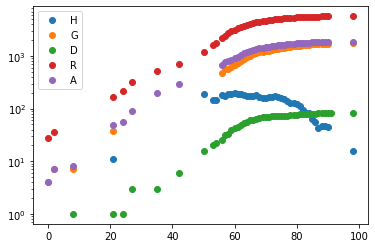

In [7]:
plt.semilogy(time, H, 'o', time, G, 'o', time, D, 'o', time, cE, 'o', time , cH, 'o')
plt.legend("HGDRA")

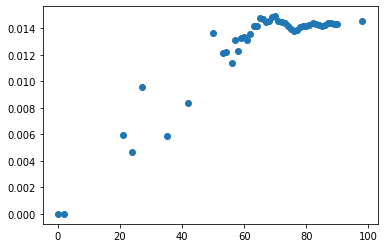

In [8]:
plt.plot(time,[d/ce if ce else None for d,ce in zip(D,cE)],'o')

In [9]:
data_pd = np.vstack([H, G, D, cE, cH]).astype(float).T
start = 0
clip = 17
data_time = time[start:clip]
data_pd = data_pd[start:clip,:]

p0 = [1.5, 1e-6, 1e-6, 1e-6, 1e-6, 1e-6]
config = {
    "grid_size": 200,
    "basis_number": 40,
    "model_form": {
        "state": 9,
        "parameters": 6
    },
    "time_span": [time[0], time[-1]*1.25],
#     "time_span": [time[0], 150],
    "knot_function": None,
    "model": seir,
    "dataset": {"y": data_pd, "t": np.array(data_time)},
    "observation_vector": [3,4,6,7,8],
    "weightings":[
        [1]*9,
        np.sqrt((data_time+1)/np.mean(data_time+1))
    ],
    "regularisation_value": copy(p0),
}

In [10]:
model = modeller.Model(config)
config['regularisation_value'][0] = model.ps[0]
config['regularisation_value'][2] = model.ps[2]
objective = fitter.Objective()
objective.make(config, config['dataset'], model)

solver_setup = {
    'f': objective.objective,
    'x': ca.vcat(objective.input_list),
    'p': ca.hcat([objective.rho, objective.alpha]),
    'g': ca.vcat(model.xs),
}
ipopt_opts = {
    'ipopt': {
        'print_level': 5,
        'print_frequency_iter': 50,
        
    }
}
solver = ca.nlpsol('solver', 'ipopt', solver_setup, ipopt_opts)

In [11]:
f1_ex = ca.Function('f1_ex', [solver_setup['x']], [objective.obj_1])
f2_ex = ca.Function('f2_ex', [solver_setup['x']], [objective.obj_2])
getx = ca.Function('getx', [solver_setup['x']], model.xs)
getp = ca.Function('getx', [solver_setup['x']], model.ps)


In [12]:
c0 = [2500*np.ones(config['basis_number']) for _ in range(9)]
x0 = np.hstack([*c0, p0])
lbx = [-np.inf]*(config['basis_number']*9) + [0]*len(config['regularisation_value'])
alpha = 1e2

In [13]:
pure_solve = solver(x0=x0, p=[0, 0], lbx=lbx, lbg=0)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

(0, 3000)

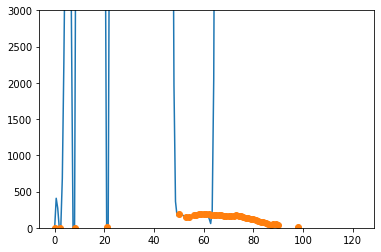

In [14]:
pure_xs = getx(pure_solve['x'])
plt.plot(model.observation_times, pure_xs[3])
plt.plot(time, H, 'o')
plt.ylim([0, 3000])

In [15]:
prange = np.logspace(-6, 6, num=100)
sols = []
xguess = x0
for p in prange:
    solve_opts = {
        'x0': xguess,
        'p': [p, alpha],
        'lbx': lbx,
        'lbg': 0,
        'ubg': 100000,
    }
    print(f"Solving for p={p}")
    sols.append(solver(**solve_opts))
    xguess = np.array(sols[-1]['x']).flatten()

Solving for p=1e-06
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du

 830  3.8147008e+01 0.00e+00 1.46e-05  -9.0 5.58e+01    -  1.00e+00 1.00e+00h  1
 840  3.8147007e+01 0.00e+00 1.25e-04  -9.0 2.15e+04    -  1.00e+00 7.81e-03h  8
 850  3.8147007e+01 0.00e+00 3.01e-05  -9.0 8.51e+01    -  1.00e+00 1.00e+00h  1
 860  3.8147007e+01 0.00e+00 4.69e-05  -9.0 1.09e+02    -  1.00e+00 1.00e+00h  1
 870  3.8147007e+01 0.00e+00 9.25e-07  -9.0 1.73e+01    -  1.00e+00 1.00e+00h  1
 880  3.8147007e+01 0.00e+00 2.55e-04  -9.0 5.25e+02    -  1.00e+00 5.00e-01h  2
 890  3.8147007e+01 0.00e+00 3.69e-06  -9.0 3.35e+01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 900  3.8147007e+01 0.00e+00 1.37e-05  -9.0 6.52e+01    -  1.00e+00 1.00e+00h  1
 910  3.8147007e+01 0.00e+00 1.67e-04  -9.0 2.31e+02    -  1.00e+00 1.00e+00h  1
 920  3.8147007e+01 0.00e+00 4.04e-05  -9.0 1.80e+03    -  1.00e+00 6.25e-02h  5
 930  3.8147007e+01 0.00e+00 4.26e-06  -9.0 3.91e+01    -  1.00e+00 1.00e+00h  1
 940  3.8147007e+01 0.00e+00

 460  3.8217255e+01 0.00e+00 4.75e-02  -8.6 1.90e+02    -  1.00e+00 5.00e-01h  2
 470  3.8217251e+01 0.00e+00 1.74e-02  -8.6 2.02e+03    -  1.00e+00 3.12e-02h  6
 480  3.8217249e+01 0.00e+00 3.09e-02  -8.6 1.79e+02    -  1.00e+00 5.00e-01h  2
 490  3.8217246e+01 0.00e+00 1.33e-02  -8.6 6.52e+01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  3.8217244e+01 0.00e+00 3.48e-03  -8.6 3.64e+01    -  1.00e+00 1.00e+00h  1
 510  3.8217242e+01 0.00e+00 1.76e-02  -8.6 8.72e+01    -  1.00e+00 1.00e+00h  1
 520  3.8217241e+01 0.00e+00 2.63e-02  -8.6 4.48e+02    -  1.00e+00 2.50e-01h  3
 530  3.8217239e+01 0.00e+00 3.26e-02  -8.6 2.67e+02    -  1.00e+00 5.00e-01h  2
 540  3.8217237e+01 0.00e+00 1.04e-02  -8.6 5.29e+03    -  1.00e+00 1.56e-02h  7
 550  3.8217236e+01 0.00e+00 1.34e-02  -8.6 1.89e+02    -  1.00e+00 5.00e-01h  2
 560  3.8217235e+01 0.00e+00 9.37e-03  -8.6 9.02e+01    -  1.00e+00 1.00e+00h  1
 570  3.8217234e+01 0.00e+00

1460  3.8217218e+01 0.00e+00 4.98e-04  -8.6 7.15e+03    -  1.00e+00 6.25e-02h  5
1470  3.8217218e+01 0.00e+00 3.29e-04  -8.6 3.81e+02    -  1.00e+00 1.00e+00h  1
1480  3.8217218e+01 0.00e+00 1.34e-05  -8.6 8.05e+01    -  1.00e+00 1.00e+00h  1
1490  3.8217218e+01 0.00e+00 7.26e-04  -8.6 2.22e+03    -  1.00e+00 2.50e-01h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500  3.8217218e+01 0.00e+00 1.29e-05  -8.6 8.16e+01    -  1.00e+00 1.00e+00h  1
1510  3.8217218e+01 0.00e+00 3.14e-03  -8.6 2.51e+03    -  1.00e+00 5.00e-01h  2
1520  3.8217218e+01 0.00e+00 9.67e-04  -8.6 1.37e+03    -  1.00e+00 5.00e-01h  2
1530  3.8217218e+01 0.00e+00 6.00e-04  -8.6 7.32e+04    -  1.00e+00 7.81e-03h  8
1540  3.8217218e+01 0.00e+00 9.85e-04  -8.6 1.44e+03    -  1.00e+00 5.00e-01h  2
1550  3.8217218e+01 0.00e+00 1.37e-04  -8.6 2.83e+02    -  1.00e+00 1.00e+00h  1
1560  3.8217218e+01 0.00e+00 7.33e-05  -8.6 2.11e+02    -  1.00e+00 1.00e+00h  1
1570  3.8217218e+01 0.00e+00

 240  3.8305277e+01 0.00e+00 1.06e-01  -5.7 9.52e+00    -  1.00e+00 1.00e+00h  1
 250  3.8305178e+01 0.00e+00 7.60e-02  -5.7 1.72e+01    -  1.00e+00 5.00e-01h  2
 260  3.8305105e+01 0.00e+00 7.05e-02  -5.7 1.91e+01    -  1.00e+00 5.00e-01h  2
 270  3.8305047e+01 0.00e+00 1.19e-01  -5.7 2.89e+01    -  1.00e+00 5.00e-01h  2
 280  3.8305001e+01 0.00e+00 2.02e-02  -5.7 6.71e+00    -  1.00e+00 1.00e+00h  1
 290  3.8304963e+01 0.00e+00 8.04e-04  -5.7 1.57e+00    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  3.8304933e+01 0.00e+00 5.26e-05  -5.7 5.15e-01    -  1.00e+00 1.00e+00h  1
 310  3.8304498e+01 0.00e+00 7.63e-02  -8.6 6.33e+01    -  7.96e-01 3.81e-01f  1
 320  3.8304443e+01 0.00e+00 9.45e-02  -8.6 2.09e+01    -  1.00e+00 1.00e+00h  1
 330  3.8304404e+01 0.00e+00 1.12e-01  -8.6 2.06e+02    -  1.00e+00 1.25e-01h  4
 340  3.8304367e+01 0.00e+00 6.37e-03  -8.6 7.59e+00    -  1.00e+00 1.00e+00h  1
 350  3.8304317e+01 0.00e+00

1170  3.8304145e+01 0.00e+00 8.58e-05  -9.0 1.66e+02    -  1.00e+00 1.00e+00h  1
1180  3.8304145e+01 0.00e+00 2.87e-03  -9.0 3.76e+03    -  1.00e+00 2.50e-01h  3
1190  3.8304145e+01 0.00e+00 1.39e-03  -9.0 2.19e+04    -  1.00e+00 3.12e-02h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  3.8304145e+01 0.00e+00 8.63e-05  -9.0 1.79e+02    -  1.00e+00 1.00e+00h  1
1210  3.8304145e+01 0.00e+00 3.63e-04  -9.0 3.70e+02    -  1.00e+00 1.00e+00h  1
1220  3.8304145e+01 0.00e+00 7.14e-05  -9.0 1.70e+02    -  1.00e+00 1.00e+00h  1
1230  3.8304145e+01 0.00e+00 4.58e-02  -9.0 4.31e+03    -  1.00e+00 1.00e+00H  1
1240  3.8304144e+01 0.00e+00 2.80e-04  -9.0 3.49e+02    -  1.00e+00 1.00e+00h  1
1250  3.8304144e+01 0.00e+00 1.22e-03  -9.0 7.45e+02    -  1.00e+00 1.00e+00h  1
1260  3.8304144e+01 0.00e+00 1.12e-03  -9.0 5.55e+03    -  1.00e+00 1.25e-01h  4
1270  3.8304144e+01 0.00e+00 3.04e-05  -9.0 1.27e+02    -  1.00e+00 1.00e+00h  1
1280  3.8304144e+01 0.00e+00

2150  3.8304144e+01 0.00e+00 1.52e-02  -9.0 5.22e+03    -  1.00e+00 1.00e+00H  1
2160  3.8304144e+01 0.00e+00 7.80e-04  -9.0 2.11e+03    -  1.00e+00 5.00e-01h  2
2170  3.8304144e+01 0.00e+00 1.56e-03  -9.0 3.26e+03    -  1.00e+00 5.00e-01h  2
2180  3.8304144e+01 0.00e+00 5.18e-04  -9.0 7.20e+03    -  1.00e+00 1.25e-01h  4
2190  3.8304144e+01 0.00e+00 1.95e-04  -9.0 6.04e+02    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2200  3.8304144e+01 0.00e+00 3.96e-05  -9.0 2.76e+02    -  1.00e+00 1.00e+00h  1
2210  3.8304144e+01 0.00e+00 5.23e-04  -9.0 6.33e+04    -  1.00e+00 1.56e-02h  7
2220  3.8304144e+01 0.00e+00 2.58e-03  -9.0 4.37e+03    -  1.00e+00 5.00e-01h  2
2230  3.8304144e+01 0.00e+00 4.94e-04  -9.0 1.50e+04    -  1.00e+00 6.25e-02h  5
2240  3.8304144e+01 0.00e+00 4.35e-04  -9.0 9.19e+02    -  1.00e+00 1.00e+00h  1
2250  3.8304144e+01 0.00e+00 1.60e-04  -9.0 5.61e+02    -  1.00e+00 1.00e+00h  1
2260  3.8304144e+01 0.00e+00

 240  3.8412873e+01 0.00e+00 1.26e-01  -5.7 1.62e+01    -  1.00e+00 1.00e+00h  1
 250  3.8412452e+01 0.00e+00 8.80e-02  -5.7 1.21e+01    -  1.00e+00 1.00e+00h  1
 260  3.8412116e+01 0.00e+00 1.43e-03  -5.7 5.31e+01    -  1.00e+00 1.00e+00f  1
 270  3.8411891e+01 0.00e+00 5.91e-03  -5.7 1.31e+01    -  1.00e+00 1.00e+00f  1
 280  3.8411713e+01 0.00e+00 1.03e-01  -5.7 8.68e+00    -  1.00e+00 1.00e+00h  1
 290  3.8411583e+01 0.00e+00 1.76e-01  -5.7 5.13e+01    -  1.00e+00 2.50e-01h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  3.8411468e+01 0.00e+00 5.76e-02  -5.7 8.84e+00    -  1.00e+00 1.00e+00h  1
 310  3.8411389e+01 0.00e+00 8.17e-02  -5.7 2.23e+01    -  1.00e+00 5.00e-01h  2
 320  3.8411307e+01 0.00e+00 2.26e-01  -5.7 4.60e+01    -  1.00e+00 5.00e-01h  2
 330  3.8411247e+01 0.00e+00 8.12e-04  -5.7 1.77e+00    -  1.00e+00 1.00e+00h  1
 340  3.8411213e+01 0.00e+00 9.94e-02  -5.7 3.66e+01    -  1.00e+00 5.00e-01h  2
 350  3.8411181e+01 0.00e+00

1240  3.8410407e+01 0.00e+00 3.26e-03  -8.6 1.15e+03    -  1.00e+00 5.00e-01h  2
1250  3.8410407e+01 0.00e+00 2.51e-06  -8.6 1.73e+01 -12.3 1.00e+00 1.00e+00h  1
1260  3.8410407e+01 0.00e+00 8.22e-04  -8.6 3.24e+02    -  1.00e+00 1.00e+00h  1
1270  3.8410407e+01 0.00e+00 4.00e-05  -8.6 7.68e+01    -  1.00e+00 1.00e+00h  1
1280  3.8410407e+01 0.00e+00 1.49e-04  -8.6 1.46e+02    -  1.00e+00 1.00e+00h  1
1290  3.8410407e+01 0.00e+00 2.17e-03  -8.6 5.64e+02    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1300  3.8410407e+01 0.00e+00 1.88e-03  -8.6 1.97e+03    -  1.00e+00 2.50e-01h  3
1310  3.8410407e+01 0.00e+00 1.97e-05  -8.6 6.13e+01    -  1.00e+00 1.00e+00h  1
1320  3.8410407e+01 0.00e+00 6.40e-04  -8.6 3.28e+02    -  1.00e+00 1.00e+00h  1
1330  3.8410407e+01 0.00e+00 3.00e-03  -8.6 1.38e+03    -  1.00e+00 5.00e-01h  2
1340  3.8410407e+01 0.00e+00 1.10e-03  -8.6 6.85e+03    -  1.00e+00 6.25e-02h  5
1350  3.8410407e+01 0.00e+00

2210  3.8410405e+01 0.00e+00 1.71e-04  -8.6 1.18e+04    -  1.00e+00 3.12e-02h  6
2220  3.8410405e+01 0.00e+00 1.56e-06  -8.6 3.70e+01    -  1.00e+00 1.00e+00h  1
2230  3.8410405e+01 0.00e+00 1.37e-04  -8.6 1.06e+04    -  1.00e+00 3.12e-02h  6
2240  3.8410405e+01 0.00e+00 4.84e-04  -8.6 1.24e+03    -  1.00e+00 5.00e-01h  2
2250  3.8410405e+01 0.00e+00 9.80e-05  -8.6 1.06e+03    -  1.00e+00 2.50e-01h  3
2260  3.8410405e+01 0.00e+00 1.45e-04  -8.6 1.36e+03    -  1.00e+00 2.50e-01h  3
2270  4.2358622e+01 0.00e+00 4.93e+02  -9.0 1.46e+05  -9.8 1.30e-02 2.93e-02f  1
In iteration 2270, 1 Slack too small, adjusting variable bound
2280  3.8539519e+01 0.00e+00 9.19e+01  -9.0 1.24e+04 -10.9 1.12e-03 3.04e-01f  1
2290  3.8431582e+01 0.00e+00 3.23e+01  -9.0 4.33e+04 -13.0 1.01e-01 3.95e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
In iteration 2295, 1 Slack too small, adjusting variable bound
In iteration 2296, 1 Slack too small, adjusting variable bound
2

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  3.8537663e+01 0.00e+00 1.52e-03  -8.6 2.02e+01    -  1.00e+00 1.00e+00h  1
 610  3.8537659e+01 0.00e+00 1.52e-03  -8.6 2.15e+01    -  1.00e+00 1.00e+00h  1
 620  3.8537656e+01 0.00e+00 4.15e-02  -8.6 9.05e+02    -  1.00e+00 1.25e-01h  4
 630  3.8537653e+01 0.00e+00 2.54e-02  -8.6 1.78e+02    -  1.00e+00 5.00e-01h  2
 640  3.8537651e+01 0.00e+00 5.13e-02  -8.6 2.82e+02    -  1.00e+00 5.00e-01h  2
 650  3.8537647e+01 0.00e+00 6.87e-06  -8.6 1.75e+00  -8.8 1.00e+00 1.00e+00h  1
 660  3.8537645e+01 0.00e+00 4.70e-03  -8.6 5.07e+01    -  1.00e+00 1.00e+00h  1
 670  3.8537643e+01 0.00e+00 1.08e-02  -8.6 8.07e+01    -  1.00e+00 1.00e+00h  1
 680  3.8537641e+01 0.00e+00 7.20e-03  -8.6 6.98e+01    -  1.00e+00 1.00e+00h  1
 690  3.8537639e+01 0.00e+00 8.63e-04  -8.6 2.66e+01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  3.8537637e+01 0.00e+00

  10  4.8350408e+01 0.00e+00 3.58e+01  -1.0 5.03e+04    -  6.16e-01 1.00e+00f  1
  20  5.0724749e+01 0.00e+00 1.07e+01  -1.7 9.63e+01  -4.9 1.00e+00 1.00e+00f  1
  30  4.6692031e+01 0.00e+00 8.72e+01  -1.7 1.02e+03  -7.8 1.00e+00 1.00e+00f  1
  40  4.4411320e+01 0.00e+00 1.27e+01  -1.7 6.76e+01  -4.8 2.51e-01 5.00e-01f  2
  50  4.4241103e+01 0.00e+00 4.97e+01  -1.7 3.70e+04    -  2.09e-01 1.05e-01f  2
  60  4.5281552e+01 0.00e+00 1.60e+02  -1.7 9.15e+03    -  7.95e-01 1.00e+00f  1
  70  3.9436474e+01 0.00e+00 3.57e+00  -3.8 9.06e+03    -  8.03e-01 1.00e+00f  1
  80  3.9168129e+01 0.00e+00 2.91e-04  -5.7 1.01e+02  -8.8 1.00e+00 1.00e+00f  1
  90  3.9159752e+01 0.00e+00 6.22e-02  -5.7 1.23e+03 -12.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.9157952e+01 0.00e+00 1.10e+00  -5.7 6.05e+04    -  2.97e-01 1.82e-01f  2
 110  3.9149025e+01 0.00e+00 8.28e-01  -5.7 2.42e+03    -  4.01e-01 5.00e-01f  2
 120  3.9104069e+01 0.00e+00

 970  3.8684713e+01 0.00e+00 1.08e-02  -8.6 2.88e+02    -  1.00e+00 1.00e+00h  1
 980  3.8684713e+01 0.00e+00 1.40e-02  -8.6 3.37e+02    -  1.00e+00 1.00e+00h  1
 990  3.8684713e+01 0.00e+00 1.77e-03  -8.6 1.26e+02    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  3.8684712e+01 0.00e+00 8.08e-03  -8.6 2.77e+02    -  1.00e+00 1.00e+00h  1
1010  3.8684712e+01 0.00e+00 5.49e-03  -8.6 2.35e+02    -  1.00e+00 1.00e+00h  1
1020  3.8684712e+01 0.00e+00 2.16e-03  -8.6 1.53e+02    -  1.00e+00 1.00e+00h  1
1030  3.8684711e+01 0.00e+00 1.25e-03  -8.6 1.20e+02    -  1.00e+00 1.00e+00h  1
1040  3.8684711e+01 0.00e+00 4.60e-03  -8.6 7.42e+03    -  1.00e+00 3.12e-02h  6
1050  3.8684711e+01 0.00e+00 4.39e-03  -8.6 2.38e+02    -  1.00e+00 1.00e+00h  1
1060  3.8684711e+01 0.00e+00 9.12e-04  -8.6 1.13e+02    -  1.00e+00 1.00e+00h  1
1070  3.8684710e+01 0.00e+00 1.10e-03  -8.6 1.27e+02    -  1.00e+00 1.00e+00h  1
1080  3.8684710e+01 0.00e+00

 400  3.8852159e+01 0.00e+00 8.36e-02  -5.7 6.32e+02  -9.6 1.00e+00 3.12e-02h  6
 410  3.8852124e+01 0.00e+00 6.81e-02  -5.7 1.50e+02    -  1.00e+00 1.25e-01h  4
 420  3.8852095e+01 0.00e+00 3.87e-02  -5.7 2.81e+01    -  1.00e+00 5.00e-01h  2
 430  3.8852071e+01 0.00e+00 5.12e-02  -5.7 3.59e+01    -  1.00e+00 5.00e-01h  2
 440  3.8852051e+01 0.00e+00 1.01e-01  -5.7 5.43e+01    -  1.00e+00 5.00e-01h  2
 450  3.8852033e+01 0.00e+00 2.36e-04  -5.7 1.54e+00    -  1.00e+00 1.00e+00h  1
 460  3.8851683e+01 0.00e+00 5.33e-02  -8.6 5.22e+01    -  8.34e-01 4.07e-01f  1
 470  3.8851619e+01 0.00e+00 1.57e-02  -8.6 1.41e+01    -  1.00e+00 1.00e+00h  1
 480  3.8851578e+01 0.00e+00 9.75e-03  -8.6 1.28e+01    -  1.00e+00 1.00e+00h  1
 490  3.8851555e+01 0.00e+00 6.86e-02  -8.6 6.41e+01    -  1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  3.8851537e+01 0.00e+00 1.35e-01  -8.6 1.05e+02    -  1.00e+00 5.00e-01h  2
 510  3.8851516e+01 0.00e+00

1390  3.8851305e+01 0.00e+00 9.51e-03  -8.6 1.34e+04    -  1.00e+00 3.12e-02h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1400  3.8851305e+01 0.00e+00 1.73e-03  -8.6 2.99e+02    -  1.00e+00 1.00e+00h  1
1410  3.8851305e+01 0.00e+00 7.13e-03  -8.6 6.18e+02    -  1.00e+00 1.00e+00h  1
1420  3.8851304e+01 0.00e+00 1.43e-03  -8.6 2.84e+02    -  1.00e+00 1.00e+00h  1
1430  3.8851304e+01 0.00e+00 3.94e-04  -8.6 1.54e+02    -  1.00e+00 1.00e+00h  1
1440  3.8851304e+01 0.00e+00 1.58e-03  -8.6 3.12e+02    -  1.00e+00 1.00e+00h  1
1450  3.8851304e+01 0.00e+00 4.82e-03  -8.6 5.55e+02    -  1.00e+00 1.00e+00h  1
1460  3.8851304e+01 0.00e+00 6.58e-04  -8.6 2.11e+02    -  1.00e+00 1.00e+00h  1
1470  3.8851304e+01 0.00e+00 4.78e-04  -8.6 1.84e+02    -  1.00e+00 1.00e+00h  1
1480  3.8851304e+01 0.00e+00 2.78e-04  -8.6 1.44e+02    -  1.00e+00 1.00e+00h  1
1490  3.8851304e+01 0.00e+00 2.18e-03  -8.6 4.07e+02    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr 

 380  3.9038120e+01 0.00e+00 2.83e-01  -5.7 5.31e+01    -  1.00e+00 2.50e-01h  3
 390  3.9037950e+01 0.00e+00 1.42e-01  -5.7 1.73e+02    -  1.00e+00 6.25e-02h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  3.9037796e+01 0.00e+00 2.29e-01  -5.7 1.44e+03    -  7.29e-01 1.10e-02f  7
 410  3.9037720e+01 0.00e+00 5.92e-01  -5.7 5.63e+01    -  1.00e+00 5.00e-01h  2
 420  3.9037570e+01 0.00e+00 1.75e-01  -5.7 6.70e+01    -  1.00e+00 2.50e-01h  3
 430  3.9037492e+01 0.00e+00 4.83e-02  -5.7 1.01e+01    -  1.00e+00 1.00e+00h  1
 440  3.9037398e+01 0.00e+00 1.67e-03  -5.7 3.83e+01    -  1.00e+00 1.00e+00f  1
 450  3.9037342e+01 0.00e+00 1.94e-01  -5.7 4.80e+01    -  1.00e+00 5.00e-01h  2
 460  3.9037291e+01 0.00e+00 9.93e-02  -5.7 3.57e+01    -  1.00e+00 5.00e-01h  2
 470  3.9037249e+01 0.00e+00 5.58e-02  -5.7 1.17e+02    -  1.00e+00 1.25e-01h  4
 480  3.9037212e+01 0.00e+00 1.36e-01  -5.7 2.55e+01    -  1.00e+00 1.00e+00h  1
 490  3.9037178e+01 0.00e+00

  20  4.7298177e+01 0.00e+00 1.58e-01  -3.8 1.34e+03  -7.3 7.89e-01 3.41e-01f  1
  30  3.9298092e+01 0.00e+00 2.20e+00  -3.8 1.87e+03    -  1.00e+00 1.00e+00f  1
  40  3.9299935e+01 0.00e+00 4.30e-01  -3.8 2.33e+02    -  1.00e+00 1.00e+00f  1
  50  3.9300552e+01 0.00e+00 1.99e+00  -3.8 6.96e+02    -  1.00e+00 5.00e-01f  2
  60  3.9300129e+01 0.00e+00 7.28e-01  -3.8 1.60e+02    -  1.00e+00 1.00e+00f  1
  70  3.9300125e+01 0.00e+00 4.10e-01  -3.8 8.22e+01    -  1.00e+00 1.00e+00f  1
  80  3.9300687e+01 0.00e+00 1.61e+00  -3.8 1.23e+02    -  1.00e+00 1.00e+00f  1
  90  3.9302194e+01 0.00e+00 3.70e+00  -3.8 1.36e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.9300593e+01 0.00e+00 3.06e-01  -3.8 8.31e+01    -  1.00e+00 1.00e+00f  1
 110  3.9302248e+01 0.00e+00 3.03e+00  -3.8 6.33e+01    -  1.00e+00 1.00e+00f  1
 120  3.9301768e+01 0.00e+00 1.42e+00  -3.8 1.11e+02    -  1.00e+00 2.50e-01f  3
 130  3.9302157e+01 0.00e+00

1000  3.9238761e+01 0.00e+00 1.56e-02  -8.6 2.43e+02    -  1.00e+00 5.00e-01h  2
1010  3.9238760e+01 0.00e+00 5.56e-02  -8.6 1.11e+03    -  1.00e+00 2.50e-01h  3
1020  3.9238759e+01 0.00e+00 3.60e-02  -8.6 1.85e+03    -  1.00e+00 1.25e-01h  4
1030  3.9238758e+01 0.00e+00 2.43e-02  -8.6 3.75e+02    -  1.00e+00 5.00e-01h  2
1040  3.9238757e+01 0.00e+00 4.23e-02  -8.6 5.29e+02    -  1.00e+00 5.00e-01h  2
1050  3.9238756e+01 0.00e+00 1.08e-02  -8.6 1.42e+02    -  1.00e+00 1.00e+00h  1
1060  3.9238755e+01 0.00e+00 1.20e-03  -8.6 4.97e+01    -  1.00e+00 1.00e+00h  1
1070  3.9238754e+01 0.00e+00 2.29e-02  -8.6 4.13e+02    -  1.00e+00 5.00e-01h  2
1080  3.9238753e+01 0.00e+00 2.78e-02  -8.6 4.77e+02    -  1.00e+00 5.00e-01h  2
1090  3.9238753e+01 0.00e+00 6.55e-03  -8.6 1.26e+02    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  3.9238752e+01 0.00e+00 1.59e-02  -8.6 2.01e+02    -  1.00e+00 1.00e+00h  1
1110  3.9238751e+01 0.00e+00

1960  3.9238731e+01 0.00e+00 1.25e-02  -8.6 9.06e+02    -  1.00e+00 1.00e+00h  1
1970  3.9238731e+01 0.00e+00 6.27e-02  -8.6 1.33e+04    -  1.00e+00 6.25e-02h  5
1980  3.9238731e+01 0.00e+00 2.43e-02  -8.6 5.53e+03    -  1.00e+00 1.25e-01h  4
1990  3.9238731e+01 0.00e+00 5.64e-01  -8.6 1.13e+05    -  1.00e+00 7.81e-03h  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000  3.9238731e+01 0.00e+00 8.77e-04  -8.6 2.51e+02    -  1.00e+00 1.00e+00h  1
2010  3.9238731e+01 0.00e+00 2.44e-02  -8.6 5.53e+03    -  1.00e+00 1.25e-01h  4
2020  3.9238731e+01 0.00e+00 3.04e-04  -8.6 1.53e+02    -  1.00e+00 1.00e+00h  1
2030  3.9238731e+01 0.00e+00 1.24e-03  -8.6 3.04e+02    -  1.00e+00 1.00e+00h  1
2040  3.9238731e+01 0.00e+00 6.87e-02  -8.6 1.46e+04    -  1.00e+00 6.25e-02h  5
2050  3.9238731e+01 0.00e+00 1.51e-03  -8.6 3.41e+02    -  1.00e+00 1.00e+00h  1
2060  3.9238731e+01 0.00e+00 3.90e-04  -8.6 1.77e+02    -  1.00e+00 1.00e+00h  1
2070  3.9238731e+01 0.00e+00

 160  4.0231073e+01 0.00e+00 2.50e+00  -5.7 4.49e+03    -  2.17e-01 9.77e-01f  1
 170  4.0154935e+01 0.00e+00 4.39e+00  -5.7 9.62e+03    -  2.49e-01 5.00e-01f  2
 180  4.0041920e+01 0.00e+00 1.08e+00  -5.7 2.21e+03 -11.5 1.00e+00 1.00e+00f  1
 190  3.9893895e+01 0.00e+00 8.01e+00  -5.7 5.32e+03 -11.2 6.37e-01 7.93e-02f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  3.9742619e+01 0.00e+00 1.11e+01  -5.7 6.94e+03    -  5.80e-01 5.00e-01f  2
 210  3.9566661e+01 0.00e+00 8.92e+00  -5.7 8.00e+02    -  1.00e+00 1.00e+00f  1
 220  3.9522292e+01 0.00e+00 2.30e+00  -5.7 1.58e+03 -13.1 1.00e+00 1.00e+00f  1
 230  3.9500969e+01 0.00e+00 5.38e-01  -5.7 8.97e+01    -  1.00e+00 1.00e+00f  1
 240  3.9488159e+01 0.00e+00 1.45e+00  -5.7 5.43e+01    -  1.00e+00 1.00e+00f  1
 250  3.9480355e+01 0.00e+00 2.54e+00  -5.7 8.94e+01    -  1.00e+00 5.00e-01f  2
 260  3.9475193e+01 0.00e+00 2.49e+00  -5.7 3.77e+01    -  1.00e+00 1.00e+00f  1
 270  3.9471391e+01 0.00e+00

1120  3.9457982e+01 0.00e+00 5.90e-03  -8.6 8.21e+01    -  1.00e+00 1.00e+00h  1
1130  3.9457981e+01 0.00e+00 2.74e-03  -8.6 5.80e+01    -  1.00e+00 1.00e+00h  1
1140  3.9457980e+01 0.00e+00 6.29e-02  -8.6 2.84e+02    -  1.00e+00 1.00e+00h  1
1150  3.9457979e+01 0.00e+00 1.16e-02  -8.6 1.26e+02    -  1.00e+00 1.00e+00h  1
1160  3.9457978e+01 0.00e+00 1.65e-02  -8.6 1.55e+02    -  1.00e+00 1.00e+00h  1
1170  3.9457977e+01 0.00e+00 3.76e-02  -8.6 4.65e+02    -  1.00e+00 5.00e-01h  2
1180  3.9457976e+01 0.00e+00 2.18e-02  -8.6 3.46e+02    -  1.00e+00 5.00e-01h  2
1190  3.9457975e+01 0.00e+00 2.47e-02  -8.6 1.61e+03    -  1.00e+00 1.25e-01h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  3.9457975e+01 0.00e+00 1.70e-02  -8.6 1.77e+02    -  1.00e+00 1.00e+00h  1
1210  3.9457974e+01 0.00e+00 1.83e-02  -8.6 1.88e+02    -  1.00e+00 1.00e+00h  1
1220  3.9457973e+01 0.00e+00 2.86e-03  -8.6 7.70e+01    -  1.00e+00 1.00e+00h  1
1230  3.9457972e+01 0.00e+00

2110  3.9457951e+01 0.00e+00 9.06e-02  -8.6 1.15e+04    -  1.00e+00 6.25e-02h  5
2120  3.9457950e+01 0.00e+00 2.06e-02  -8.6 1.01e+03    -  1.00e+00 1.00e+00h  1
2130  3.9457950e+01 0.00e+00 4.77e-01  -8.6 5.78e+04    -  1.00e+00 1.56e-02h  7
2140  3.9457950e+01 0.00e+00 2.68e-03  -8.6 3.71e+02    -  1.00e+00 1.00e+00h  1
2150  3.9457950e+01 0.00e+00 5.00e-04  -8.6 1.64e+02    -  1.00e+00 1.00e+00h  1
2160  3.9457950e+01 0.00e+00 2.66e+00  -8.6 3.17e+05    -  1.00e+00 1.95e-03h 10
2170  3.9457950e+01 0.00e+00 2.13e-02  -8.6 1.07e+03    -  1.00e+00 1.00e+00H  1
2180  3.9457950e+01 0.00e+00 2.69e-02  -8.6 2.37e+03    -  1.00e+00 5.00e-01h  2
2190  3.9457950e+01 0.00e+00 1.16e-02  -8.6 8.00e+02    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2200  3.9457950e+01 0.00e+00 2.57e-02  -8.6 2.35e+03    -  1.00e+00 5.00e-01h  2
2210  3.9457950e+01 0.00e+00 5.76e-04  -8.6 1.84e+02    -  1.00e+00 1.00e+00h  1
2220  3.9457950e+01 0.00e+00

  60  3.9756747e+01 0.00e+00 3.06e+00  -3.8 2.81e+04    -  1.00e+00 2.50e-01f  3
  70  3.9756013e+01 0.00e+00 3.29e-01  -3.8 1.69e+03    -  1.00e+00 1.00e+00f  1
  80  3.9756081e+01 0.00e+00 5.49e-01  -3.8 1.74e+03    -  1.00e+00 1.00e+00f  1
  90  3.9756706e+01 0.00e+00 2.76e+00  -3.8 5.89e+03    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.9756887e+01 0.00e+00 3.17e+00  -3.8 4.93e+03    -  1.00e+00 5.00e-01f  2
 110  3.9756209e+01 0.00e+00 1.07e+00  -3.8 1.13e+03    -  1.00e+00 1.00e+00f  1
 120  3.9756462e+01 0.00e+00 1.96e+00  -3.8 1.18e+03    -  1.00e+00 1.00e+00f  1
 130  3.9756930e+01 0.00e+00 3.15e+00  -3.8 1.16e+03    -  1.00e+00 1.00e+00f  1
 140  3.9757264e+01 0.00e+00 3.79e+00  -3.8 1.88e+03    -  1.00e+00 5.00e-01f  2
 150  3.9756726e+01 0.00e+00 2.62e+00  -3.8 1.15e+03    -  1.00e+00 5.00e-01f  2
 160  3.9756140e+01 0.00e+00 3.33e-01  -3.8 1.57e+02    -  1.00e+00 1.00e+00f  1
 170  3.9756292e+01 0.00e+00

1060  3.9697864e+01 0.00e+00 2.44e-02  -8.6 6.15e+01    -  1.00e+00 1.00e+00h  1
1070  3.9697861e+01 0.00e+00 2.79e-03  -8.6 2.21e+01    -  1.00e+00 1.00e+00h  1
1080  3.9697857e+01 0.00e+00 4.37e-02  -8.6 8.89e+01    -  1.00e+00 1.00e+00h  1
1090  3.9697854e+01 0.00e+00 7.40e-02  -8.6 4.67e+02    -  1.00e+00 2.50e-01h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  3.9697850e+01 0.00e+00 2.00e-01  -8.6 2.84e+04    -  7.75e-01 3.01e-03h  9
1110  3.9697847e+01 0.00e+00 6.66e-02  -8.6 7.40e+03    -  1.00e+00 1.56e-02h  7
1120  3.9697851e+01 0.00e+00 3.04e-01  -8.6 2.75e+02    -  1.00e+00 1.00e+00h  1
1130  3.9697845e+01 0.00e+00 2.31e-01  -8.6 4.96e+02    -  1.00e+00 5.00e-01h  2
1140  3.9697839e+01 0.00e+00 1.14e-02  -8.6 5.78e+01    -  1.00e+00 1.00e+00h  1
1150  3.9697837e+01 0.00e+00 6.56e-03  -8.6 4.55e+01    -  1.00e+00 1.00e+00h  1
1160  3.9697835e+01 0.00e+00 7.10e-02  -8.6 1.22e+03    -  1.00e+00 1.25e-01h  4
1170  3.9697833e+01 0.00e+00

1980  3.9734973e+01 0.00e+00 3.87e+01  -9.0 1.66e+03 -11.3 3.83e-01 5.00e-01f  2
1990  3.9697777e+01 0.00e+00 4.29e-03  -9.0 3.82e+02    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000  3.9697777e+01 0.00e+00 2.19e-02  -9.0 1.68e+03    -  1.00e+00 5.00e-01h  2
2010  3.9697777e+01 0.00e+00 7.21e-03  -9.0 5.01e+02    -  1.00e+00 1.00e+00h  1
2020  3.9697777e+01 0.00e+00 2.67e-03  -9.0 3.08e+02    -  1.00e+00 1.00e+00h  1
2030  3.9697777e+01 0.00e+00 1.70e-04  -9.0 8.36e+01    -  1.00e+00 1.00e+00h  1
2040  3.9697777e+01 0.00e+00 1.57e-03  -9.0 2.40e+02    -  1.00e+00 1.00e+00h  1
2050  3.9697776e+01 0.00e+00 1.18e-02  -9.0 6.61e+02    -  1.00e+00 1.00e+00h  1
2060  3.9697776e+01 0.00e+00 4.42e-03  -9.0 4.07e+02    -  1.00e+00 1.00e+00h  1
2070  3.9697776e+01 0.00e+00 9.13e-03  -9.0 5.88e+02    -  1.00e+00 1.00e+00h  1
2080  3.9697776e+01 0.00e+00 3.43e-03  -9.0 3.64e+02    -  1.00e+00 1.00e+00h  1
2090  3.9697776e+01 0.00e+00

2940  3.9697773e+01 0.00e+00 1.75e-01  -9.0 2.04e+04    -  1.00e+00 6.25e-02h  5
2950  3.9697773e+01 0.00e+00 1.25e+00  -9.0 1.38e+05    -  1.00e+00 7.81e-03h  8
2960  3.9697773e+01 0.00e+00 6.45e-04  -9.0 2.79e+02    -  1.00e+00 1.00e+00h  1
2970  3.9697773e+01 0.00e+00 1.22e-02  -9.0 1.19e+03    -  1.00e+00 1.00e+00h  1
2980  3.9697773e+01 0.00e+00 3.08e-03  -9.0 6.05e+02    -  1.00e+00 1.00e+00h  1
2990  3.9697773e+01 0.00e+00 5.06e-02  -9.0 2.45e+03    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3000  3.9697773e+01 0.00e+00 2.70e-03  -9.0 5.72e+02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 3000

                                   (scaled)                 (unscaled)
Objective...............:   3.9697773334871584e+01    3.9697773334871584e+01
Dual infeasibility......:   2.6987097294335414e-03    2.6987097294335414e-03
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity..

 580  3.9992243e+01 0.00e+00 2.07e-01  -5.7 2.19e+01    -  1.00e+00 1.00e+00h  1
 590  3.9992205e+01 0.00e+00 8.68e-02  -5.7 1.50e+01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  3.9992173e+01 0.00e+00 2.49e-01  -5.7 5.22e+01    -  1.00e+00 5.00e-01h  2
 610  3.9992143e+01 0.00e+00 2.20e-01  -5.7 5.13e+01    -  1.00e+00 5.00e-01h  2
 620  3.9992113e+01 0.00e+00 1.22e-01  -5.7 3.26e+02    -  1.00e+00 6.25e-02h  5
 630  3.9992089e+01 0.00e+00 2.42e-01  -5.7 5.96e+01    -  1.00e+00 5.00e-01h  2
 640  3.9992064e+01 0.00e+00 3.67e-03  -5.7 4.04e+00    -  1.00e+00 1.00e+00h  1
 650  3.9992043e+01 0.00e+00 6.74e-02  -5.7 1.75e+01    -  1.00e+00 1.00e+00h  1
 660  3.9992024e+01 0.00e+00 6.96e-02  -5.7 3.41e+01    -  1.00e+00 5.00e-01h  2
 670  3.9992007e+01 0.00e+00 1.75e-01  -5.7 1.20e+02    -  1.00e+00 2.50e-01h  3
 680  3.9991990e+01 0.00e+00 1.41e-01  -5.7 5.54e+01    -  1.00e+00 5.00e-01h  2
 690  3.9991975e+01 0.00e+00

1510  3.9991276e+01 0.00e+00 9.92e-04  -8.6 4.39e+01    -  1.00e+00 1.00e+00h  1
1520  3.9991276e+01 0.00e+00 6.20e-02  -8.6 6.87e+02    -  1.00e+00 5.00e-01h  2
1530  3.9991275e+01 0.00e+00 3.63e-03  -8.6 8.68e+01    -  1.00e+00 1.00e+00h  1
1540  3.9991275e+01 0.00e+00 2.14e-02  -8.6 3.94e+02    -  1.00e+00 5.00e-01h  2
1550  3.9991274e+01 0.00e+00 2.94e-02  -8.6 2.28e+03    -  1.00e+00 6.25e-02h  5
1560  3.9991274e+01 0.00e+00 2.32e-03  -8.6 7.42e+01    -  1.00e+00 1.00e+00h  1
1570  3.9991273e+01 0.00e+00 2.13e-02  -8.6 2.28e+02    -  1.00e+00 1.00e+00h  1
1580  3.9991273e+01 0.00e+00 3.54e-02  -8.6 5.80e+02    -  1.00e+00 5.00e-01h  2
1590  3.9991273e+01 0.00e+00 4.04e-02  -8.6 3.13e+03    -  1.00e+00 6.25e-02h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1600  3.9991272e+01 0.00e+00 1.80e-02  -8.6 1.49e+03    -  1.00e+00 1.25e-01h  4
1610  3.9991272e+01 0.00e+00 3.29e-03  -8.6 9.78e+01    -  1.00e+00 1.00e+00h  1
1620  3.9991271e+01 0.00e+00

  20  7.7167306e+01 0.00e+00 1.73e+01  -1.0 7.87e+02  -5.9 1.00e+00 1.00e+00f  1
  30  8.2157316e+01 0.00e+00 3.37e+02  -1.0 3.32e+02  -5.6 6.69e-01 1.00e+00f  1
  40  8.1329630e+01 0.00e+00 4.81e+02  -1.0 9.96e+01  -4.4 1.00e+00 1.00e+00f  1
  50  7.4187886e+01 0.00e+00 2.33e+00  -1.0 3.21e+01  -5.8 1.00e+00 1.00e+00f  1
  60  5.0938394e+01 0.00e+00 1.38e+01  -2.5 1.16e+04    -  6.10e-01 3.90e-01f  1
  70  4.1930839e+01 0.00e+00 7.93e-03  -3.8 9.03e+01  -7.2 1.00e+00 1.00e+00f  1
  80  4.1793932e+01 0.00e+00 3.55e+00  -3.8 8.54e+03 -12.0 1.00e+00 1.00e+00f  1
  90  4.1767622e+01 0.00e+00 1.83e-01  -5.7 8.00e+02 -12.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  4.1760686e+01 0.00e+00 1.06e+00  -5.7 1.13e+03 -12.4 1.00e+00 1.00e+00f  1
 110  4.1733065e+01 0.00e+00 9.85e+00  -5.7 2.01e+04 -12.7 1.00e+00 1.95e-01f  1
 120  4.1613771e+01 0.00e+00 2.25e+01  -5.7 5.36e+03 -11.1 2.81e-01 3.38e-01f  2
 130  4.1517204e+01 0.00e+00

 950  4.0363075e+01 0.00e+00 7.65e-02  -8.6 4.16e+02    -  1.00e+00 1.25e-01h  4
 960  4.0363070e+01 0.00e+00 1.12e-01  -8.6 2.61e+02    -  1.00e+00 2.50e-01h  3
 970  4.0363064e+01 0.00e+00 4.89e-02  -8.6 4.66e+01    -  1.00e+00 1.00e+00h  1
 980  4.0363059e+01 0.00e+00 1.46e-02  -8.6 2.65e+01    -  1.00e+00 1.00e+00h  1
 990  4.0363054e+01 0.00e+00 2.19e-03  -8.6 1.11e+01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  4.0363049e+01 0.00e+00 1.02e-01  -8.6 5.87e+02    -  1.00e+00 1.25e-01h  4
1010  4.0363044e+01 0.00e+00 2.62e-02  -8.6 3.95e+01    -  1.00e+00 1.00e+00h  1
1020  4.0363040e+01 0.00e+00 8.33e-02  -8.6 7.27e+01    -  1.00e+00 1.00e+00h  1
1030  4.0363036e+01 0.00e+00 9.30e-02  -8.6 6.23e+02    -  1.00e+00 1.25e-01h  4
1040  4.0363032e+01 0.00e+00 6.42e-02  -8.6 6.84e+01    -  1.00e+00 1.00e+00h  1
1050  4.0363028e+01 0.00e+00 1.55e-01  -8.6 5.52e+03    -  1.00e+00 1.56e-02h  7
1060  4.0363025e+01 0.00e+00

1920  4.0362933e+01 0.00e+00 1.96e-02  -8.6 3.13e+02    -  1.00e+00 1.00e+00h  1
1930  4.0362932e+01 0.00e+00 2.39e-02  -8.6 3.52e+02    -  1.00e+00 1.00e+00h  1
1940  4.0362932e+01 0.00e+00 2.61e-02  -8.6 7.25e+02    -  1.00e+00 5.00e-01h  2
1950  4.0362932e+01 0.00e+00 7.52e-03  -8.6 2.06e+02    -  1.00e+00 1.00e+00h  1
1960  4.0362932e+01 0.00e+00 7.87e-04  -8.6 6.83e+01    -  1.00e+00 1.00e+00h  1
1970  4.0362931e+01 0.00e+00 1.10e-02  -8.6 2.57e+02    -  1.00e+00 1.00e+00h  1
1980  4.0362932e+01 0.00e+00 9.15e-02  -8.6 1.50e+03    -  1.00e+00 5.00e-01h  2
1990  4.0362931e+01 0.00e+00 8.15e-03  -8.6 2.29e+02    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000  4.0362931e+01 0.00e+00 8.02e-05  -8.6 2.56e+01    -  1.00e+00 1.00e+00h  1
2010  4.0362931e+01 0.00e+00 5.68e-02  -8.6 2.28e+03    -  1.00e+00 1.25e-01h  4
2020  4.0362930e+01 0.00e+00 1.68e-03  -8.6 1.10e+02    -  1.00e+00 1.00e+00h  1
2030  4.0362930e+01 0.00e+00

2910  4.0362922e+01 0.00e+00 4.51e-03  -8.6 3.62e+02    -  1.00e+00 1.00e+00h  1
2920  4.0362922e+01 0.00e+00 1.61e-03  -8.6 2.19e+02    -  1.00e+00 1.00e+00h  1
2930  4.0362922e+01 0.00e+00 1.58e-03  -8.6 2.18e+02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 2933

                                   (scaled)                 (unscaled)
Objective...............:   4.0362922088661712e+01    4.0362922088661712e+01
Dual infeasibility......:   2.7540415115392665e-10    2.7540415115392665e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035699744391e-09    2.5059035699744391e-09
Overall NLP error.......:   2.5059035699744391e-09    2.5059035699744391e-09


Number of objective function evaluations             = 6030
Number of objective gradient evaluations             = 2934
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 6030
Number of equality constraint

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  4.0808247e+01 0.00e+00 4.05e-01  -5.7 2.72e+01    -  1.00e+00 1.00e+00h  1
 710  4.0808219e+01 0.00e+00 5.88e-02  -5.7 1.09e+01    -  1.00e+00 1.00e+00h  1
 720  4.0808194e+01 0.00e+00 3.54e-02  -5.7 8.80e+00    -  1.00e+00 1.00e+00h  1
 730  4.0808172e+01 0.00e+00 3.31e-02  -5.7 8.84e+00    -  1.00e+00 1.00e+00h  1
 740  4.0808153e+01 0.00e+00 1.72e-02  -5.7 6.62e+00    -  1.00e+00 1.00e+00h  1
 750  4.0808134e+01 0.00e+00 7.34e-02  -5.7 1.41e+01    -  1.00e+00 1.00e+00h  1
 760  4.0808117e+01 0.00e+00 1.25e-01  -5.7 1.90e+01    -  1.00e+00 1.00e+00h  1
 770  4.0808102e+01 0.00e+00 1.10e-01  -5.7 3.50e+01    -  1.00e+00 5.00e-01h  2
 780  4.0808087e+01 0.00e+00 6.61e-02  -5.7 1.47e+01    -  1.00e+00 1.00e+00h  1
 790  4.0808070e+01 0.00e+00 7.56e-02  -5.7 3.07e+01    -  1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 800  4.0808056e+01 0.00e+00

1660  4.0807361e+01 0.00e+00 1.48e-01  -8.6 8.43e+02    -  1.00e+00 5.00e-01h  2
1670  4.0807360e+01 0.00e+00 4.13e-03  -8.6 7.26e+01    -  1.00e+00 1.00e+00h  1
1680  4.0807359e+01 0.00e+00 3.29e-03  -8.6 6.60e+01    -  1.00e+00 1.00e+00h  1
1690  4.0807359e+01 0.00e+00 7.27e-04  -8.6 3.22e+01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1700  4.0807358e+01 0.00e+00 1.24e-02  -8.6 1.32e+02    -  1.00e+00 1.00e+00h  1
1710  4.0807358e+01 0.00e+00 1.16e-02  -8.6 1.30e+02    -  1.00e+00 1.00e+00h  1
1720  4.0807357e+01 0.00e+00 6.96e-04  -8.6 3.33e+01    -  1.00e+00 1.00e+00h  1
1730  4.0807357e+01 0.00e+00 1.24e-03  -8.6 4.48e+01    -  1.00e+00 1.00e+00h  1
1740  4.0807357e+01 0.00e+00 3.32e-02  -8.6 2.33e+02    -  1.00e+00 1.00e+00h  1
1750  4.0807356e+01 0.00e+00 2.51e-02  -8.6 3.83e+02    -  1.00e+00 5.00e-01h  2
1760  4.0807356e+01 0.00e+00 7.24e-02  -8.6 1.84e+03    -  1.00e+00 1.25e-01h  4
1770  4.0807356e+01 0.00e+00

2570  4.0807340e+01 0.00e+00 9.35e-02  -9.0 2.78e+03    -  1.00e+00 2.50e-01h  3
2580  4.0807340e+01 0.00e+00 1.67e-02  -9.0 5.28e+02    -  1.00e+00 1.00e+00h  1
2590  4.0807340e+01 0.00e+00 4.37e-02  -9.0 8.58e+02    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2600  4.0807340e+01 0.00e+00 4.51e-01  -9.0 1.07e+04    -  1.00e+00 6.25e-02h  5
2610  4.0807340e+01 0.00e+00 4.53e-03  -9.0 2.80e+02    -  1.00e+00 1.00e+00h  1
2620  4.0807340e+01 0.00e+00 1.32e-01  -9.0 1.51e+03    -  1.00e+00 1.00e+00H  1
2630  4.0807340e+01 0.00e+00 1.85e+00  -9.0 4.19e+04    -  1.00e+00 1.56e-02h  7
2640  4.0807340e+01 0.00e+00 1.47e-01  -9.0 3.73e+03    -  1.00e+00 1.25e-01h  4
2650  4.0807340e+01 0.00e+00 6.88e-03  -9.0 3.54e+02    -  1.00e+00 1.00e+00h  1
2660  4.0807340e+01 0.00e+00 8.79e-06  -9.0 2.40e+01    -  1.00e+00 1.00e+00h  1
2670  4.0807340e+01 0.00e+00 1.52e-02  -9.0 5.31e+02    -  1.00e+00 1.00e+00h  1
2680  4.0807340e+01 0.00e+00

 270  4.2349397e+01 0.00e+00 1.33e+01  -5.7 1.75e+03 -11.6 1.00e+00 1.00e+00f  1
 280  4.2157202e+01 0.00e+00 2.88e+01  -5.7 3.28e+03 -12.2 1.00e+00 1.00e+00f  1
 290  4.2005711e+01 0.00e+00 1.32e+01  -5.7 3.45e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  4.1554642e+01 0.00e+00 7.22e+00  -5.7 2.90e+03 -11.1 1.00e+00 1.00e+00f  1
 310  4.1436903e+01 0.00e+00 5.89e+00  -5.7 1.75e+03    -  1.00e+00 1.00e+00f  1
 320  4.1398087e+01 0.00e+00 7.31e+00  -5.7 8.67e+01    -  1.00e+00 1.00e+00f  1
 330  4.1375647e+01 0.00e+00 6.16e+00  -5.7 1.07e+02    -  1.00e+00 5.00e-01f  2
 340  4.1360859e+01 0.00e+00 4.22e+00  -5.7 6.16e+01    -  1.00e+00 1.00e+00f  1
 350  4.1351234e+01 0.00e+00 6.61e+00  -5.7 9.24e+01    -  1.00e+00 5.00e-01f  2
 360  4.1343770e+01 0.00e+00 3.31e+00  -5.7 4.79e+02    -  1.00e+00 1.00e+00f  1
 370  4.1338950e+01 0.00e+00 2.37e+00  -5.7 2.19e+03    -  1.00e+00 5.00e-01f  2
 380  4.1335633e+01 0.00e+00

1270  4.1315570e+01 0.00e+00 1.73e-01  -8.6 6.53e+01    -  1.00e+00 1.00e+00h  1
1280  4.1315566e+01 0.00e+00 1.23e-01  -8.6 1.08e+02    -  1.00e+00 5.00e-01h  2
1290  4.1315562e+01 0.00e+00 1.02e-01  -8.6 8.41e+02    -  1.00e+00 6.25e-02h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1300  4.1315559e+01 0.00e+00 2.70e-01  -8.6 1.76e+02    -  1.00e+00 5.00e-01h  2
1310  4.1315554e+01 0.00e+00 5.16e-02  -8.6 1.11e+03    -  1.00e+00 3.12e-02h  6
1320  4.1315550e+01 0.00e+00 5.55e-02  -8.6 1.19e+03    -  1.00e+00 3.12e-02h  6
1330  4.1315546e+01 0.00e+00 1.77e-02  -8.6 2.53e+01    -  1.00e+00 1.00e+00h  1
1340  4.1315543e+01 0.00e+00 1.30e-02  -8.6 2.23e+01    -  1.00e+00 1.00e+00h  1
1350  4.1315540e+01 0.00e+00 5.84e-02  -8.6 1.74e+02    -  1.00e+00 2.50e-01h  3
1360  4.1315537e+01 0.00e+00 9.13e-02  -8.6 1.16e+02    -  1.00e+00 5.00e-01h  2
1370  4.1315535e+01 0.00e+00 2.23e-01  -8.6 1.96e+02    -  1.00e+00 5.00e-01h  2
1380  4.1315532e+01 0.00e+00

2260  4.1315444e+01 0.00e+00 3.09e-02  -8.6 2.97e+02    -  1.00e+00 1.00e+00h  1
2270  4.1315444e+01 0.00e+00 9.00e-02  -8.6 2.14e+03    -  1.00e+00 1.25e-01h  4
2280  4.1315444e+01 0.00e+00 8.71e-02  -8.6 2.07e+03    -  1.00e+00 1.25e-01h  4
2290  4.1315443e+01 0.00e+00 3.70e-02  -8.6 1.03e+03    -  1.00e+00 2.50e-01h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2300  4.1315443e+01 0.00e+00 3.15e+00  -8.6 6.58e+04    -  1.00e+00 3.91e-03h  9
2310  4.1315443e+01 0.00e+00 2.39e-02  -8.6 5.38e+02    -  1.00e+00 5.00e-01h  2
2320  4.1315443e+01 0.00e+00 9.42e-02  -8.6 2.24e+03    -  1.00e+00 1.25e-01h  4
2330  4.1315443e+01 0.00e+00 6.12e-04  -8.6 4.71e+01    -  1.00e+00 1.00e+00h  1
2340  4.1315443e+01 0.00e+00 3.70e-04  -8.6 3.75e+01    -  1.00e+00 1.00e+00h  1
2350  4.1315442e+01 0.00e+00 1.02e-02  -8.6 1.95e+02    -  1.00e+00 1.00e+00h  1
2360  4.1315442e+01 0.00e+00 5.56e-05  -8.6 1.67e+01    -  1.00e+00 1.00e+00h  1
2370  4.1315442e+01 0.00e+00

  50  4.3044453e+01 0.00e+00 3.24e+01  -2.5 2.44e+03  -9.0 1.00e+00 1.00e+00f  1
  60  4.2974894e+01 0.00e+00 3.46e+00  -2.5 3.14e+02 -10.5 1.00e+00 1.00e+00f  1
  70  4.2947016e+01 0.00e+00 9.71e+00  -2.5 1.67e+04    -  1.00e+00 1.48e-01f  3
  80  4.2950953e+01 0.00e+00 3.07e+01  -2.5 7.64e+03    -  1.00e+00 5.00e-01f  2
  90  4.2986779e+01 0.00e+00 9.39e+00  -2.5 2.21e+03    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  4.3016224e+01 0.00e+00 4.10e+00  -2.5 5.09e+01  -8.5 1.00e+00 1.00e+00f  1
 110  4.3038115e+01 0.00e+00 3.64e+01  -2.5 1.39e+04  -5.9 8.73e-02 5.46e-03f  5
 120  4.2903657e+01 0.00e+00 2.24e+01  -2.5 6.15e+02  -6.0 1.00e+00 6.25e-02f  5
 130  4.3006138e+01 0.00e+00 1.79e+01  -2.5 1.10e+03    -  1.00e+00 2.50e-01f  3
 140  4.3012163e+01 0.00e+00 1.21e+01  -2.5 1.21e+03    -  1.00e+00 1.00e+00f  1
 150  4.2983023e+01 0.00e+00 4.08e+01  -2.5 3.87e+02  -9.8 1.00e+00 2.50e-01f  3
 160  4.3036305e+01 0.00e+00

1090  4.1897744e+01 0.00e+00 5.47e-03  -5.7 2.90e+00  -8.4 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  4.1897753e+01 0.00e+00 1.01e-01  -5.7 2.58e+01    -  1.00e+00 5.00e-01h  2
1110  4.1897746e+01 0.00e+00 2.36e-03  -5.7 2.05e+00    -  1.00e+00 1.00e+00h  1
1120  4.1897741e+01 0.00e+00 2.88e-02  -5.7 5.69e+01    -  1.00e+00 1.25e-01h  4
1130  4.1897736e+01 0.00e+00 1.85e-02  -5.7 1.09e+01    -  1.00e+00 5.00e-01h  2
1140  4.1897732e+01 0.00e+00 3.87e-02  -5.7 3.40e+01    -  1.00e+00 2.50e-01h  3
1150  4.1897729e+01 0.00e+00 4.86e-03  -5.7 2.41e+01    -  1.00e+00 1.25e-01h  4
1160  4.1897727e+01 0.00e+00 3.63e-03  -5.7 5.23e+00    -  1.00e+00 5.00e-01h  2
1170  4.1897260e+01 0.00e+00 1.04e-01  -8.6 1.40e+01    -  9.59e-01 4.84e-01f  1
1180  4.1897247e+01 0.00e+00 2.21e-02  -8.6 6.90e+00    -  1.00e+00 1.00e+00h  1
1190  4.1897235e+01 0.00e+00 1.39e-01  -8.6 1.35e+02    -  1.00e+00 1.25e-01h  4
iter    objective    inf_pr 

2070  4.1896940e+01 0.00e+00 8.24e-03  -8.6 4.44e+01    -  1.00e+00 1.00e+00h  1
2080  4.1896940e+01 0.00e+00 4.81e-02  -8.6 4.18e+02    -  1.00e+00 2.50e-01h  3
2090  4.1896939e+01 0.00e+00 5.64e-02  -8.6 1.20e+02    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2100  4.1896939e+01 0.00e+00 1.39e-01  -8.6 3.78e+02    -  1.00e+00 5.00e-01h  2
2110  4.1896938e+01 0.00e+00 1.26e-02  -8.6 5.85e+01    -  1.00e+00 1.00e+00h  1
2120  4.1896938e+01 0.00e+00 6.41e-03  -8.6 4.26e+01    -  1.00e+00 1.00e+00h  1
2130  4.1896937e+01 0.00e+00 2.52e-02  -8.6 8.54e+01    -  1.00e+00 1.00e+00h  1
2140  4.1896937e+01 0.00e+00 4.83e-02  -8.6 4.64e+02    -  1.00e+00 2.50e-01h  3
2150  4.1896936e+01 0.00e+00 3.76e-02  -8.6 7.82e+02    -  1.00e+00 1.25e-01h  4
2160  4.1896936e+01 0.00e+00 4.17e-02  -8.6 8.65e+02    -  1.00e+00 1.25e-01h  4
2170  4.1896936e+01 0.00e+00 2.75e-01  -8.6 5.07e+03    -  1.00e+00 1.56e-02h  7
2180  4.1896935e+01 0.00e+00

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.2635200e+01 0.00e+00 4.15e+00  -1.0 0.00e+00    -  0.00e+00 0.

 820  4.3305398e+01 0.00e+00 1.73e-01  -5.7 5.68e+01    -  1.00e+00 2.50e-01h  3
 830  4.3305382e+01 0.00e+00 2.09e-01  -5.7 3.23e+01    -  1.00e+00 5.00e-01h  2
 840  4.3305366e+01 0.00e+00 1.47e-01  -5.7 1.14e+02    -  1.00e+00 1.25e-01h  4
 850  4.3305353e+01 0.00e+00 2.06e-02  -5.7 5.65e+00    -  1.00e+00 1.00e+00h  1
 860  4.3305340e+01 0.00e+00 9.06e-02  -5.7 4.42e+01    -  1.00e+00 2.50e-01h  3
 870  4.3305327e+01 0.00e+00 1.24e-01  -5.7 5.55e+01    -  1.00e+00 2.50e-01h  3
 880  4.3305315e+01 0.00e+00 7.09e-02  -5.7 1.13e+01    -  1.00e+00 1.00e+00h  1
 890  4.3305304e+01 0.00e+00 1.75e-01  -5.7 3.53e+01    -  1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 900  4.3305293e+01 0.00e+00 1.08e-01  -5.7 5.65e+01    -  1.00e+00 2.50e-01h  3
 910  4.3305283e+01 0.00e+00 7.21e-02  -5.7 1.93e+02    -  1.00e+00 6.25e-02h  5
 920  4.3305274e+01 0.00e+00 2.64e-01  -5.7 2.39e+01    -  1.00e+00 1.00e+00H  1
 930  4.3305265e+01 0.00e+00

1790  4.3304567e+01 0.00e+00 8.77e-02  -8.6 1.54e+02    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1800  4.3304566e+01 0.00e+00 2.04e-04  -8.6 8.97e+00    -  1.00e+00 1.00e+00h  1
1810  4.3304565e+01 0.00e+00 1.69e-02  -8.6 7.06e+01    -  1.00e+00 1.00e+00h  1
1820  4.3304565e+01 0.00e+00 1.94e-02  -8.6 7.72e+01    -  1.00e+00 1.00e+00h  1
1830  4.3304564e+01 0.00e+00 1.37e-02  -8.6 6.59e+01    -  1.00e+00 1.00e+00h  1
1840  4.3304563e+01 0.00e+00 6.49e-03  -8.6 4.64e+01    -  1.00e+00 1.00e+00h  1
1850  4.3304563e+01 0.00e+00 7.48e-03  -8.6 5.07e+01    -  1.00e+00 1.00e+00h  1
1860  4.3304562e+01 0.00e+00 6.51e-02  -8.6 1.52e+02    -  1.00e+00 1.00e+00h  1
1870  4.3304562e+01 0.00e+00 1.09e-01  -8.6 1.30e+03    -  1.00e+00 1.25e-01h  4
1880  4.3304561e+01 0.00e+00 8.52e-03  -8.6 5.71e+01    -  1.00e+00 1.00e+00h  1
1890  4.3304560e+01 0.00e+00 9.26e-01  -8.6 9.88e+03    -  1.00e+00 1.56e-02h  7
iter    objective    inf_pr 

2760  4.3304538e+01 0.00e+00 1.19e-02  -8.6 2.52e+02    -  1.00e+00 1.00e+00h  1
2770  4.3304538e+01 0.00e+00 3.15e-02  -8.6 4.11e+02    -  1.00e+00 1.00e+00h  1
2780  4.3304538e+01 0.00e+00 3.04e-01  -8.6 3.64e+03    -  1.00e+00 1.25e-01h  4
2790  4.3304538e+01 0.00e+00 7.43e+00  -8.6 7.83e+04    -  1.00e+00 3.91e-03h  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2800  4.3304537e+01 0.00e+00 3.60e-01  -8.6 4.03e+03    -  1.00e+00 6.25e-02h  5
2810  4.3304537e+01 0.00e+00 1.00e-02  -8.6 2.38e+02    -  1.00e+00 1.00e+00h  1
2820  4.3304537e+01 0.00e+00 9.82e-04  -8.6 7.60e+01    -  1.00e+00 1.00e+00h  1
2830  4.3304537e+01 0.00e+00 7.30e-03  -8.6 2.05e+02    -  1.00e+00 1.00e+00h  1
2840  4.3304537e+01 0.00e+00 6.05e-03  -8.6 1.88e+02    -  1.00e+00 1.00e+00h  1
2850  4.3304537e+01 0.00e+00 8.91e-02  -8.6 1.25e+03    -  1.00e+00 2.50e-01h  3
2860  4.3304537e+01 0.00e+00 4.30e-01  -8.6 4.82e+03    -  1.00e+00 6.25e-02h  5
2870  4.3304537e+01 0.00e+00

 410  4.4180086e+01 0.00e+00 2.90e+00  -5.7 1.41e+01    -  1.00e+00 5.00e-01f  2
 420  4.4177380e+01 0.00e+00 3.05e+00  -5.7 7.29e+00    -  1.00e+00 1.00e+00f  1
 430  4.4175127e+01 0.00e+00 2.06e+00  -5.7 1.98e+01    -  1.00e+00 2.50e-01f  3
 440  4.4173247e+01 0.00e+00 3.22e+00  -5.7 1.16e+01    -  1.00e+00 5.00e-01f  2
 450  4.4171655e+01 0.00e+00 2.23e+00  -5.7 1.73e+01    -  1.00e+00 2.50e-01f  3
 460  4.4170285e+01 0.00e+00 1.37e+00  -5.7 3.00e+00    -  1.00e+00 1.00e+00f  1
 470  4.4169140e+01 0.00e+00 2.38e+00  -5.7 1.51e+01    -  1.00e+00 2.50e-01f  3
 480  4.4168097e+01 0.00e+00 1.18e+00  -5.7 2.29e+00    -  1.00e+00 1.00e+00f  1
 490  4.4167257e+01 0.00e+00 3.08e+00  -5.7 1.46e+01    -  1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  4.4166436e+01 0.00e+00 3.13e-01  -5.7 1.27e+00    -  1.00e+00 1.00e+00f  1
 510  4.4165748e+01 0.00e+00 4.72e-01  -5.7 1.70e+00    -  1.00e+00 1.00e+00f  1
 520  4.4165167e+01 0.00e+00

1350  4.4158711e+01 0.00e+00 3.09e-01  -8.6 9.87e+01    -  1.00e+00 5.00e-01h  2
1360  4.4158705e+01 0.00e+00 1.94e-01  -8.6 4.15e+01    -  1.00e+00 1.00e+00h  1
1370  4.4158703e+01 0.00e+00 6.02e-01  -8.6 1.49e+02    -  1.00e+00 5.00e-01h  2
1380  4.4158695e+01 0.00e+00 2.04e-01  -8.6 4.52e+01    -  1.00e+00 1.00e+00h  1
1390  4.4158690e+01 0.00e+00 2.11e-01  -8.6 7.49e+02    -  1.00e+00 6.25e-02h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1400  4.4158684e+01 0.00e+00 8.59e-02  -8.6 3.13e+01  -9.4 1.00e+00 1.00e+00h  1
1410  4.4158679e+01 0.00e+00 5.79e-04  -8.6 3.37e+00    -  1.00e+00 1.00e+00h  1
1420  4.4158675e+01 0.00e+00 1.65e-02  -8.6 1.47e+01    -  1.00e+00 1.00e+00h  1
1430  4.4158671e+01 0.00e+00 4.59e-02  -8.6 2.51e+01    -  1.00e+00 1.00e+00h  1
1440  4.4158667e+01 0.00e+00 6.00e-03  -8.6 9.52e+00    -  1.00e+00 1.00e+00h  1
1450  4.4158664e+01 0.00e+00 2.14e-02  -8.6 1.81e+01    -  1.00e+00 1.00e+00h  1
1460  4.4158660e+01 0.00e+00

2360  4.4158550e+01 0.00e+00 4.86e-02  -8.6 1.66e+02    -  1.00e+00 1.00e+00h  1
2370  4.4158550e+01 0.00e+00 1.51e-01  -8.6 1.60e+03    -  1.00e+00 1.25e-01h  4
2380  4.4158549e+01 0.00e+00 1.96e-01  -8.6 1.94e+03    -  1.00e+00 6.25e-02h  5
2390  4.4158549e+01 0.00e+00 6.13e-03  -8.6 6.20e+01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2400  4.4158549e+01 0.00e+00 8.91e-03  -8.6 7.58e+01    -  1.00e+00 1.00e+00h  1
2410  4.4158548e+01 0.00e+00 5.90e-02  -8.6 3.78e+02    -  1.00e+00 5.00e-01h  2
2420  4.4158548e+01 0.00e+00 2.27e-02  -8.6 1.24e+02    -  1.00e+00 1.00e+00h  1
2430  4.4158548e+01 0.00e+00 5.50e-03  -8.6 6.22e+01    -  1.00e+00 1.00e+00h  1
2440  4.4158547e+01 0.00e+00 4.59e-04  -8.6 1.90e+01    -  1.00e+00 1.00e+00h  1
2450  4.4158547e+01 0.00e+00 1.05e-03  -8.6 2.84e+01    -  1.00e+00 1.00e+00h  1
2460  4.4158547e+01 0.00e+00 1.72e-02  -8.6 1.14e+02    -  1.00e+00 1.00e+00h  1
2470  4.4158547e+01 0.00e+00

 130  4.6428747e+01 0.00e+00 2.95e+00  -3.8 1.27e+03 -12.4 1.00e+00 1.00e+00f  1
 140  4.6423840e+01 0.00e+00 3.49e-01  -3.8 6.75e+02    -  1.00e+00 1.00e+00f  1
 150  4.6417211e+01 0.00e+00 2.80e+00  -3.8 1.54e+03 -11.6 1.00e+00 5.00e-01f  2
 160  4.6401184e+01 0.00e+00 3.46e+00  -3.8 1.99e+04    -  6.40e-01 3.54e-02f  5
 170  4.6338002e+01 0.00e+00 2.53e+01  -3.8 9.89e+04    -  3.17e-01 9.51e-02f  3
 180  4.6184655e+01 0.00e+00 1.47e+00  -3.8 7.24e+02 -10.2 1.00e+00 1.00e+00f  1
 190  4.6109037e+01 0.00e+00 4.76e+00  -3.8 6.89e+02 -10.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  4.6068750e+01 0.00e+00 4.76e+00  -3.8 8.31e+02 -11.4 1.00e+00 1.00e+00f  1
 210  4.6045227e+01 0.00e+00 3.08e+01  -3.8 2.69e+03    -  1.00e+00 1.00e+00f  1
 220  4.6030551e+01 0.00e+00 6.18e+00  -3.8 9.33e+03    -  1.00e+00 4.55e-01f  2
 230  4.6020657e+01 0.00e+00 2.89e+00  -3.8 5.00e+02    -  1.00e+00 1.00e+00f  1
 240  4.6014272e+01 0.00e+00

1140  4.5095774e+01 0.00e+00 8.87e-03  -5.7 3.10e+00    -  1.00e+00 1.00e+00h  1
1150  4.5095764e+01 0.00e+00 7.27e-02  -5.7 6.78e+01    -  1.00e+00 1.25e-01h  4
1160  4.5095756e+01 0.00e+00 7.15e-03  -5.7 2.91e+00    -  1.00e+00 1.00e+00h  1
1170  4.5095742e+01 0.00e+00 1.19e-02  -5.7 3.86e+00    -  1.00e+00 1.00e+00h  1
1180  4.5095734e+01 0.00e+00 1.44e-01  -5.7 2.63e+01    -  1.00e+00 5.00e-01h  2
1190  4.5095728e+01 0.00e+00 1.97e-02  -5.7 5.11e+00    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  4.5095722e+01 0.00e+00 5.14e-03  -5.7 2.66e+00    -  1.00e+00 1.00e+00h  1
1210  4.5095715e+01 0.00e+00 6.56e-03  -5.7 3.06e+00    -  1.00e+00 1.00e+00h  1
1220  4.5095708e+01 0.00e+00 1.82e-03  -5.7 1.65e+00    -  1.00e+00 1.00e+00h  1
1230  4.5095703e+01 0.00e+00 8.18e-02  -5.7 2.16e+01    -  1.00e+00 5.00e-01h  2
1240  4.5095699e+01 0.00e+00 6.26e-03  -5.7 3.11e+00    -  1.00e+00 1.00e+00h  1
1250  4.5095694e+01 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2100  4.5095038e+01 0.00e+00 2.38e-04  -8.6 5.66e+00    -  1.00e+00 1.00e+00h  1
2110  4.5095037e+01 0.00e+00 1.33e-01  -8.6 1.01e+03    -  1.00e+00 6.25e-02h  5
2120  4.5095037e+01 0.00e+00 3.02e-02  -8.6 5.47e+01    -  1.00e+00 1.00e+00h  1
2130  4.5095036e+01 0.00e+00 8.12e-02  -8.6 9.10e+01    -  1.00e+00 1.00e+00h  1
2140  4.5098796e+01 0.00e+00 2.26e+01  -8.6 1.54e+03    -  1.00e+00 1.00e+00H  1
2150  4.5095033e+01 0.00e+00 1.04e-01  -8.6 2.10e+02    -  1.00e+00 5.00e-01h  2
2160  4.5095032e+01 0.00e+00 6.70e-03  -8.6 2.85e+01    -  1.00e+00 1.00e+00h  1
2170  4.5095032e+01 0.00e+00 1.43e-02  -8.6 4.23e+01    -  1.00e+00 1.00e+00h  1
2180  4.5095031e+01 0.00e+00 2.53e-02  -8.6 5.72e+01    -  1.00e+00 1.00e+00h  1
2190  4.5095030e+01 0.00e+00 8.50e-03  -8.6 3.38e+01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2200  4.5095029e+01 0.00e+00

  40  7.9805811e+01 0.00e+00 1.57e+03  -1.0 8.56e+03    -  1.00e+00 5.00e-01f  2
  50  8.2039375e+01 0.00e+00 6.29e+02  -1.0 3.35e+01  -3.6 1.00e+00 1.00e+00f  1
  60  7.9513467e+01 0.00e+00 1.07e+03  -1.0 2.51e+04    -  4.15e-01 1.66e-01f  2
  70  7.9829709e+01 0.00e+00 2.44e+02  -1.0 7.82e+02  -7.5 1.00e+00 1.00e+00f  1
  80  7.9880611e+01 0.00e+00 7.37e+02  -1.0 1.70e+04    -  1.00e+00 5.00e-01f  2
  90  4.8235310e+01 0.00e+00 1.56e+00  -2.5 1.15e+03 -10.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  4.7501772e+01 0.00e+00 9.13e-02  -3.8 1.83e+02 -10.5 1.00e+00 1.00e+00f  1
 110  4.7488064e+01 0.00e+00 8.08e+00  -3.8 1.42e+03 -12.0 1.00e+00 1.00e+00f  1
 120  4.7474589e+01 0.00e+00 7.86e+00  -3.8 6.70e+03    -  1.00e+00 2.50e-01f  3
 130  4.7450242e+01 0.00e+00 1.56e+01  -3.8 7.02e+03    -  1.00e+00 5.00e-01f  2
 140  4.7327968e+01 0.00e+00 4.39e+01  -3.8 4.69e+03 -10.6 3.24e-01 2.50e-01f  3
 150  4.7094954e+01 0.00e+00

 150  4.8128177e+01 0.00e+00 3.50e+01  -5.7 5.50e+03 -13.1 1.00e+00 1.00e+00f  1
 160  4.8125049e+01 0.00e+00 3.81e-01  -5.7 5.14e+02 -12.4 1.00e+00 1.00e+00f  1
 170  4.8123166e+01 0.00e+00 1.86e+00  -5.7 8.65e+02 -12.7 1.00e+00 1.00e+00f  1
 180  4.8121125e+01 0.00e+00 1.77e+00  -5.7 2.36e+03 -12.9 1.00e+00 1.00e+00f  1
 190  4.8119400e+01 0.00e+00 2.05e+00  -5.7 4.08e+02 -12.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  4.8118099e+01 0.00e+00 6.92e+00  -5.7 7.99e+02 -13.0 1.00e+00 1.00e+00f  1
 210  4.8116434e+01 0.00e+00 7.98e+00  -5.7 2.62e+03 -12.3 1.00e+00 2.50e-01f  3
 220  4.8114836e+01 0.00e+00 5.67e+00  -5.7 1.77e+03 -11.2 5.95e-01 1.25e-01f  4
 230  4.8113051e+01 0.00e+00 4.76e+00  -5.7 4.70e+02 -12.4 1.00e+00 1.00e+00f  1
 240  4.8111069e+01 0.00e+00 3.48e+00  -5.7 5.07e+02 -12.6 1.00e+00 1.00e+00f  1
 250  4.8109362e+01 0.00e+00 8.57e-01  -5.7 1.67e+02 -10.6 1.00e+00 1.00e+00f  1
 260  4.8107295e+01 0.00e+00

 350  4.9476926e+01 0.00e+00 2.07e+00  -5.7 3.85e+02 -11.5 1.00e+00 1.00e+00f  1
 360  4.9475253e+01 0.00e+00 2.50e-02  -5.7 2.64e+01  -8.9 1.00e+00 1.00e+00h  1
 370  4.9473666e+01 0.00e+00 9.28e+00  -5.7 3.28e+04    -  1.19e-01 3.92e-02f  1
 380  4.9472546e+01 0.00e+00 6.45e-01  -5.7 3.38e+02 -11.5 1.00e+00 1.00e+00f  1
 390  4.9472071e+01 0.00e+00 2.89e+00  -5.7 1.58e+04    -  1.00e+00 4.96e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  4.9471725e+01 0.00e+00 1.92e-05  -5.7 2.41e-01 -11.0 1.00e+00 1.00e+00h  1
 410  4.9471493e+01 0.00e+00 2.74e-02  -8.6 6.09e+01 -12.6 1.00e+00 1.00e+00h  1
 420  4.9471442e+01 0.00e+00 6.04e-02  -8.6 3.69e+02 -12.8 9.90e-01 1.00e+00h  1
 430  4.9471406e+01 0.00e+00 4.91e-04  -8.6 4.38e+01 -12.2 1.00e+00 1.00e+00h  1
 440  4.9471357e+01 0.00e+00 9.38e-03  -8.6 1.06e+02 -12.4 1.00e+00 1.00e+00h  1
 450  4.9471269e+01 0.00e+00 3.50e-01  -8.6 2.85e+03 -13.6 1.06e-01 5.00e-01f  2
 460  4.9471213e+01 0.00e+00

  20  7.9386241e+01 0.00e+00 3.45e+02  -1.0 2.90e+04    -  3.82e-01 1.40e-01f  1
  30  9.0507939e+01 0.00e+00 2.11e+03  -1.0 1.17e+04    -  5.56e-01 5.00e-01f  2
  40  8.7762160e+01 0.00e+00 1.61e+03  -1.0 5.24e+04  -9.9 2.01e-01 2.00e-01f  3
  50  8.6732716e+01 0.00e+00 9.60e-01  -1.0 6.26e+02    -  1.00e+00 1.00e+00f  1
  60  5.4239675e+01 0.00e+00 4.43e+01  -3.8 1.44e+03 -10.9 7.77e-01 1.00e+00f  1
  70  5.4049027e+01 0.00e+00 2.85e+01  -3.8 1.54e+04    -  1.00e+00 1.00e+00f  1
  80  5.3981930e+01 0.00e+00 4.42e+00  -3.8 3.08e+02 -10.3 1.00e+00 1.00e+00f  1
  90  5.3652493e+01 0.00e+00 2.04e+01  -3.8 7.05e+03 -11.9 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  5.3202933e+01 0.00e+00 4.97e+01  -3.8 5.69e+03 -10.3 5.01e-01 2.50e-01f  3
 110  5.3018198e+01 0.00e+00 5.10e+00  -3.8 4.42e+02 -10.1 1.00e+00 1.00e+00f  1
 120  5.2936001e+01 0.00e+00 1.03e+01  -3.8 7.29e+02 -10.6 1.00e+00 1.00e+00f  1
 130  5.2890300e+01 0.00e+00

 220  5.4699544e+01 0.00e+00 7.76e+00  -3.8 4.62e+02    -  1.00e+00 1.00e+00f  1
 230  5.4695315e+01 0.00e+00 8.05e+00  -3.8 4.89e+02    -  1.00e+00 1.00e+00f  1
 240  5.4691475e+01 0.00e+00 3.22e+00  -3.8 1.08e+03    -  1.00e+00 2.50e-01f  3
 250  5.4687750e+01 0.00e+00 4.64e-01  -3.8 1.94e+02    -  1.00e+00 1.00e+00f  1
 260  5.4684531e+01 0.00e+00 1.86e+00  -3.8 3.36e+02    -  1.00e+00 1.00e+00h  1
 270  5.4681372e+01 0.00e+00 5.05e+00  -3.8 2.78e+03    -  1.00e+00 1.25e-01f  4
 280  5.4678417e+01 0.00e+00 1.84e+00  -3.8 2.18e+02    -  1.00e+00 1.00e+00h  1
 290  5.4675380e+01 0.00e+00 1.88e+00  -3.8 2.01e+02    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  5.4672406e+01 0.00e+00 2.54e-01  -3.8 3.08e+02    -  1.00e+00 1.00e+00h  1
 310  5.4669221e+01 0.00e+00 2.75e-01  -3.8 8.16e+01    -  1.00e+00 1.00e+00f  1
 320  5.4665818e+01 0.00e+00 1.58e+00  -3.8 1.95e+02    -  1.00e+00 1.00e+00h  1
 330  5.4662157e+01 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  5.6926235e+01 0.00e+00 4.66e+00  -3.8 3.98e+04 -12.4 1.00e+00 1.88e-02f  6
 210  5.6920687e+01 0.00e+00 1.59e+00  -3.8 4.21e+03    -  1.00e+00 5.00e-01f  2
 220  5.6914518e+01 0.00e+00 2.74e+00  -3.8 4.22e+02    -  1.00e+00 1.00e+00f  1
 230  5.6908980e+01 0.00e+00 2.11e+00  -3.8 6.22e+02 -12.3 1.00e+00 1.00e+00f  1
 240  5.6904048e+01 0.00e+00 5.39e+00  -3.8 5.23e+02    -  1.00e+00 1.00e+00f  1
 250  5.6899272e+01 0.00e+00 2.43e+00  -3.8 6.78e+02    -  1.00e+00 5.00e-01f  2
 260  5.6894282e+01 0.00e+00 9.79e-01  -3.8 1.51e+02 -12.0 1.00e+00 1.00e+00f  1
 270  5.6889412e+01 0.00e+00 7.44e+00  -3.8 4.15e+02    -  1.00e+00 1.00e+00f  1
 280  5.6883643e+01 0.00e+00 1.31e+01  -3.8 9.00e+02    -  1.00e+00 5.00e-01f  2
 290  5.6878680e+01 0.00e+00 5.22e+00  -3.8 9.09e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  5.6872884e+01 0.00e+00

 280  5.9596693e+01 0.00e+00 2.63e+01  -3.8 7.74e+02    -  1.00e+00 1.00e+00f  1
 290  5.9587623e+01 0.00e+00 2.53e+00  -3.8 2.16e+02 -11.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  5.9578266e+01 0.00e+00 2.44e+01  -3.8 8.09e+03 -12.0 2.44e-01 3.64e-02f  5
 310  5.9567836e+01 0.00e+00 9.56e+00  -3.8 4.04e+03    -  1.00e+00 2.50e-01f  3
 320  5.9556578e+01 0.00e+00 1.79e+01  -3.8 4.29e+02 -12.2 1.00e+00 1.00e+00f  1
 330  5.9545778e+01 0.00e+00 4.39e+00  -3.8 1.77e+02 -12.0 1.00e+00 1.00e+00f  1
 340  5.9534994e+01 0.00e+00 8.51e+01  -3.8 2.23e+04 -10.8 2.74e-02 9.01e-03f  5
 350  5.9522455e+01 0.00e+00 4.82e+01  -3.8 3.02e+03 -12.9 1.00e+00 5.00e-01f  2
 360  5.9510638e+01 0.00e+00 1.67e+01  -3.8 3.61e+03    -  1.00e+00 2.50e-01f  3
 370  5.9501499e+01 0.00e+00 2.35e+01  -3.8 1.82e+05    -  1.95e-01 2.81e-03f  4
 380  5.9490148e+01 0.00e+00 1.52e+01  -3.8 3.71e+02 -12.0 1.00e+00 1.00e+00f  1
 390  5.9477216e+01 0.00e+00

 370  6.2797423e+01 0.00e+00 1.32e+01  -3.8 2.85e+02 -10.4 1.00e+00 1.00e+00f  1
 380  6.2784453e+01 0.00e+00 5.05e+01  -3.8 2.99e+03    -  1.00e+00 2.50e-01f  3
 390  6.2770598e+01 0.00e+00 8.35e+00  -3.8 2.40e+02 -10.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  6.2758738e+01 0.00e+00 1.78e+00  -3.8 2.43e+02 -11.9 1.00e+00 1.00e+00f  1
 410  6.2748362e+01 0.00e+00 2.44e+00  -3.8 1.57e+02 -10.2 1.00e+00 1.00e+00f  1
 420  6.2735521e+01 0.00e+00 3.22e+01  -3.8 3.20e+03    -  1.00e+00 5.00e-01f  2
 430  6.2722701e+01 0.00e+00 4.81e+00  -3.8 1.84e+02 -11.9 1.00e+00 1.00e+00f  1
 440  6.2710533e+01 0.00e+00 2.26e+01  -3.8 5.84e+02 -11.7 1.00e+00 5.00e-01f  2
 450  6.2698618e+01 0.00e+00 9.13e-01  -3.8 2.38e+02 -11.5 1.00e+00 1.00e+00f  1
 460  6.2688290e+01 0.00e+00 2.29e+00  -3.8 4.14e+03    -  1.00e+00 5.00e-01f  2
 470  6.2680440e+01 0.00e+00 2.27e+00  -3.8 1.21e+02 -11.9 1.00e+00 1.00e+00f  1
 480  6.2676379e+01 0.00e+00

 410  6.6617842e+01 0.00e+00 1.46e+01  -3.8 7.38e+01  -8.7 1.00e+00 1.00e+00f  1
 420  6.6606883e+01 0.00e+00 8.92e+00  -3.8 3.17e+03    -  1.00e+00 2.50e-01f  3
 430  6.6595829e+01 0.00e+00 4.84e+01  -3.8 4.43e+02 -12.1 1.00e+00 1.00e+00f  1
 440  6.6584605e+01 0.00e+00 2.14e+01  -3.8 3.13e+02 -11.9 1.00e+00 1.00e+00f  1
 450  6.6574964e+01 0.00e+00 5.05e+00  -3.8 5.02e+03    -  1.00e+00 1.25e-01f  4
 460  6.6565842e+01 0.00e+00 8.34e+00  -3.8 1.73e+02 -11.4 1.00e+00 1.00e+00f  1
 470  6.6554724e+01 0.00e+00 2.53e+01  -3.8 3.06e+02 -12.1 1.00e+00 1.00e+00f  1
 480  6.6544734e+01 0.00e+00 8.94e+00  -3.8 1.60e+02 -11.8 1.00e+00 1.00e+00f  1
 490  6.6537057e+01 0.00e+00 1.98e+00  -3.8 7.88e+01 -11.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  6.6533225e+01 0.00e+00 6.51e+00  -3.8 4.43e+02 -12.7 1.00e+00 1.00e+00f  1
 510  6.6528502e+01 0.00e+00 1.65e+01  -5.7 9.19e+03    -  7.22e-01 1.19e-01f  3
 520  6.6504295e+01 0.00e+00

 500  7.1102027e+01 0.00e+00 4.42e+00  -3.8 4.03e+02  -9.6 1.00e+00 2.50e-01f  3
 510  7.1095474e+01 0.00e+00 3.40e+00  -3.8 9.45e+01  -9.8 1.00e+00 1.00e+00f  1
 520  7.1087753e+01 0.00e+00 2.06e+01  -3.8 2.40e+02 -12.2 1.00e+00 1.00e+00f  1
 530  7.1082765e+01 0.00e+00 2.62e+01  -3.8 1.09e+03 -11.5 1.00e+00 1.25e-01f  4
 540  7.1078885e+01 0.00e+00 1.64e+00  -3.8 6.50e+02    -  1.00e+00 1.00e+00h  1
 550  7.1053921e+01 0.00e+00 7.47e+01  -5.7 1.02e+04 -12.3 1.00e+00 1.25e-01f  4
 560  7.1051716e+01 0.00e+00 7.09e+00  -5.7 4.54e+02 -11.6 1.00e+00 1.00e+00f  1
 570  7.1050983e+01 0.00e+00 4.81e+01  -5.7 3.91e+03    -  1.00e+00 2.50e-01f  3
 580  7.1050658e+01 0.00e+00 4.10e+00  -8.6 1.80e+03    -  8.61e-01 9.53e-01f  1

Number of Iterations....: 588

                                   (scaled)                 (unscaled)
Objective...............:   7.1050627090203633e+01    7.1050627090203633e+01
Dual infeasibility......:   7.8221259410062820e-09    7.8221259410062820e-09
Constraint vio

 560  7.5960245e+01 0.00e+00 5.39e+00  -3.8 1.70e+03 -10.9 1.00e+00 6.25e-02f  5
 570  7.5958088e+01 0.00e+00 1.38e-06  -3.8 5.80e-02    -  1.00e+00 1.00e+00h  1
 580  7.5930784e+01 0.00e+00 1.84e+01  -5.7 5.61e+02 -11.6 1.00e+00 1.00e+00f  1
 590  7.5929707e+01 0.00e+00 7.33e-03  -5.7 1.35e+00  -8.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  7.5929172e+01 0.00e+00 7.48e-02  -5.7 2.86e+01 -11.0 1.00e+00 1.00e+00h  1
 610  7.5929011e+01 0.00e+00 4.64e+00  -8.6 1.49e+04    -  1.00e+00 6.07e-01h  1

Number of Iterations....: 617

                                   (scaled)                 (unscaled)
Objective...............:   6.9901118896882096e+01    7.5928979558146253e+01
Dual infeasibility......:   2.6986321577282336e-11    2.9313462956348014e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800746e-09    2.7219979187789687e-09
Overall NLP error.....

  50  1.1866481e+02 0.00e+00 9.64e+02  -1.0 3.63e+03    -  1.00e+00 2.50e-01f  3
  60  1.2369793e+02 0.00e+00 1.09e+03  -1.0 1.21e+03    -  1.00e+00 1.00e+00f  1
  70  1.2681657e+02 0.00e+00 1.83e+03  -1.0 2.84e+03    -  1.00e+00 2.50e-01f  3
  80  1.2847422e+02 0.00e+00 1.06e+03  -1.0 7.89e+03    -  1.00e+00 1.00e+00f  1
  90  1.2879402e+02 0.00e+00 2.26e+02  -1.0 1.34e+03  -9.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.2930660e+02 0.00e+00 2.94e-02  -1.0 6.65e+00    -  1.00e+00 1.00e+00f  1
 110  1.0012983e+02 0.00e+00 7.47e+02  -2.5 1.26e+04    -  1.00e+00 2.50e-01f  3
 120  9.9760554e+01 0.00e+00 9.05e+01  -2.5 1.26e+03 -10.2 1.00e+00 5.00e-01f  2
 130  9.9383971e+01 0.00e+00 4.16e+02  -2.5 8.55e+04    -  1.01e-01 2.27e-02f  5
 140  9.8319889e+01 0.00e+00 1.79e+02  -2.5 5.66e+02  -9.3 1.00e+00 1.00e+00f  1
 150  9.2309850e+01 0.00e+00 9.53e+02  -2.5 1.63e+03  -8.7 3.13e-01 1.00e+00f  1
 160  8.9610669e+01 0.00e+00

 150  9.2628491e+01 0.00e+00 2.55e+02  -3.8 6.04e+02 -10.8 1.00e+00 1.00e+00f  1
 160  9.2613868e+01 0.00e+00 1.14e+02  -3.8 4.21e+02 -11.0 1.00e+00 1.00e+00f  1
 170  9.2602340e+01 0.00e+00 1.09e+01  -3.8 3.85e+02 -11.3 1.00e+00 1.00e+00f  1
 180  9.2591446e+01 0.00e+00 5.91e+01  -3.8 9.56e+02 -11.5 1.00e+00 5.00e-01f  2
 190  9.2580002e+01 0.00e+00 8.15e+00  -3.8 2.15e+02 -10.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  9.2568941e+01 0.00e+00 5.36e+01  -3.8 5.05e+02 -10.7 1.00e+00 1.00e+00f  1
 210  9.2557473e+01 0.00e+00 7.17e+00  -3.8 1.56e+02 -10.9 1.00e+00 1.00e+00f  1
 220  9.2545760e+01 0.00e+00 4.82e+01  -3.8 1.94e+02  -9.4 1.00e+00 1.00e+00f  1
 230  9.2534587e+01 0.00e+00 1.51e+01  -3.8 2.43e+02 -10.9 1.00e+00 1.00e+00f  1
 240  9.2519724e+01 0.00e+00 3.59e+01  -3.8 3.50e+02 -11.1 1.00e+00 1.00e+00f  1
 250  9.2507219e+01 0.00e+00 7.56e+00  -3.8 1.59e+02 -10.9 1.00e+00 1.00e+00f  1
 260  9.2492279e+01 0.00e+00

 260  9.8679255e+01 0.00e+00 1.43e+02  -3.8 9.34e+02 -11.4 1.00e+00 5.00e-01f  2
 270  9.8662991e+01 0.00e+00 1.82e+02  -3.8 5.46e+02 -11.7 1.00e+00 1.00e+00f  1
 280  9.8645503e+01 0.00e+00 7.59e+01  -3.8 1.21e+03 -11.0 1.00e+00 2.50e-01f  3
 290  9.8627504e+01 0.00e+00 1.01e+02  -3.8 6.77e+02 -11.3 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  9.8608273e+01 0.00e+00 7.72e+01  -3.8 5.49e+02 -11.5 1.00e+00 5.00e-01f  2
 310  9.8586024e+01 0.00e+00 8.54e+01  -3.8 9.70e+02 -11.8 1.00e+00 5.00e-01f  2
 320  9.8562254e+01 0.00e+00 6.09e+01  -3.8 2.60e+02 -11.1 1.00e+00 1.00e+00f  1
 330  9.8538098e+01 0.00e+00 1.82e+02  -3.8 8.43e+02 -11.4 1.00e+00 5.00e-01f  2
 340  9.8512974e+01 0.00e+00 1.68e+02  -3.8 8.09e+02 -11.6 1.00e+00 5.00e-01f  2
 350  9.8487484e+01 0.00e+00 4.20e+01  -3.8 1.97e+02 -11.0 1.00e+00 1.00e+00f  1
 360  9.8462283e+01 0.00e+00 8.19e+01  -3.8 2.87e+02 -11.2 1.00e+00 1.00e+00f  1
 370  9.8437897e+01 0.00e+00

 360  1.0496134e+02 0.00e+00 2.50e+02  -3.8 8.32e+02 -11.3 1.00e+00 5.00e-01f  2
 370  1.0492929e+02 0.00e+00 1.37e+02  -3.8 3.01e+02 -10.7 1.00e+00 1.00e+00f  1
 380  1.0490002e+02 0.00e+00 2.36e+02  -3.8 3.99e+02 -11.0 1.00e+00 1.00e+00f  1
 390  1.0487004e+02 0.00e+00 4.47e+01  -3.8 1.63e+02 -10.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  1.0484585e+02 0.00e+00 1.78e+02  -3.8 3.41e+02 -10.6 1.00e+00 1.00e+00f  1
 410  1.0481615e+02 0.00e+00 1.03e+02  -3.8 8.85e+02 -10.8 1.00e+00 2.50e-01f  3
 420  1.0479001e+02 0.00e+00 1.49e+02  -3.8 1.13e+03 -11.1 1.00e+00 2.50e-01f  3
 430  1.0476347e+02 0.00e+00 5.94e+01  -3.8 1.84e+02 -10.4 1.00e+00 1.00e+00f  1
 440  1.0473497e+02 0.00e+00 2.16e+01  -3.8 1.87e+02 -10.7 1.00e+00 1.00e+00f  1
 450  1.0471098e+02 0.00e+00 8.48e+01  -3.8 4.00e+02 -10.9 1.00e+00 5.00e-01f  2
 460  1.0468428e+02 0.00e+00 1.13e+02  -3.8 6.17e+02 -11.2 1.00e+00 5.00e-01f  2
 470  1.0465912e+02 0.00e+00

 470  1.1193057e+02 0.00e+00 2.20e+02  -3.8 1.55e+03 -10.7 1.00e+00 2.50e-01f  3
 480  1.1189796e+02 0.00e+00 2.70e+02  -3.8 8.45e+02 -11.0 1.00e+00 5.00e-01f  2
 490  1.1185996e+02 0.00e+00 1.82e+01  -3.8 1.12e+02 -10.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  1.1182169e+02 0.00e+00 1.85e+02  -3.8 3.39e+02 -10.6 1.00e+00 1.00e+00f  1
 510  1.1178578e+02 0.00e+00 5.87e+00  -3.8 7.61e+01  -8.5 1.00e+00 1.00e+00f  1
 520  1.1174136e+02 0.00e+00 2.81e+01  -3.8 1.98e+02 -10.6 1.00e+00 1.00e+00f  1
 530  1.1169319e+02 0.00e+00 2.06e+02  -3.8 6.25e+02 -10.9 1.00e+00 5.00e-01f  2
 540  1.1164817e+02 0.00e+00 1.90e+02  -3.8 5.89e+02 -11.1 1.00e+00 5.00e-01f  2
 550  1.1160031e+02 0.00e+00 1.26e+02  -3.8 2.40e+02 -10.5 1.00e+00 1.00e+00f  1
 560  1.1155459e+02 0.00e+00 2.42e+02  -3.8 6.20e+02 -10.7 1.00e+00 5.00e-01f  2
 570  1.1150872e+02 0.00e+00 6.74e+01  -3.8 2.19e+02 -10.1 1.00e+00 1.00e+00f  1
 580  1.1146743e+02 0.00e+00

 420  1.1849660e+02 0.00e+00 3.61e+00  -3.8 2.94e+02 -10.2 1.00e+00 1.00e+00f  1
 430  1.1844078e+02 0.00e+00 6.70e+01  -3.8 4.42e+02 -10.5 1.00e+00 1.00e+00f  1
 440  1.1840070e+02 0.00e+00 2.48e+02  -3.8 2.61e+02  -8.9 1.00e+00 5.00e-01f  2
 450  1.1837972e+02 0.00e+00 1.53e+01  -3.8 6.23e+01  -8.7 1.00e+00 1.00e+00f  1
 460  1.1836778e+02 0.00e+00 2.83e+00  -3.8 2.30e+01  -8.4 1.00e+00 1.00e+00f  1
 470  1.1835427e+02 0.00e+00 1.52e-01  -3.8 7.00e+00  -8.6 1.00e+00 1.00e+00f  1
 480  1.1834083e+02 0.00e+00 2.41e+00  -3.8 6.11e+01 -10.0 1.00e+00 1.00e+00f  1
 490  1.1833217e+02 0.00e+00 1.46e+02  -3.8 1.05e+04    -  1.00e+00 1.25e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  1.1832763e+02 0.00e+00 9.21e-01  -3.8 3.61e+01 -10.2 1.00e+00 1.00e+00f  1
 510  1.1832480e+02 0.00e+00 4.95e-01  -3.8 2.40e+01    -  1.00e+00 1.00e+00h  1
 520  1.1831009e+02 0.00e+00 7.55e+01  -5.7 3.10e+04    -  1.00e+00 6.25e-02f  5
 530  1.1830743e+02 0.00e+00

 500  1.2595506e+02 0.00e+00 6.15e-02  -3.8 4.90e+00  -8.3 1.00e+00 1.00e+00f  1
 510  1.2593953e+02 0.00e+00 2.61e-02  -3.8 1.75e+00  -8.0 1.00e+00 1.00e+00f  1
 520  1.2592759e+02 0.00e+00 5.39e-03  -3.8 1.40e+00  -7.6 1.00e+00 1.00e+00f  1
 530  1.2591932e+02 0.00e+00 4.98e-03  -3.8 8.76e-01  -8.2 1.00e+00 1.00e+00f  1
 540  1.2591593e+02 0.00e+00 1.29e+00  -3.8 3.07e+01    -  1.00e+00 1.00e+00h  1
 550  1.2590085e+02 0.00e+00 1.38e-03  -5.7 1.27e+00  -7.5 1.00e+00 1.00e+00f  1
 560  1.2589784e+02 0.00e+00 1.25e-02  -5.7 1.44e+00  -8.1 1.00e+00 1.00e+00f  1
 570  1.2589629e+02 0.00e+00 1.13e-02  -5.7 1.42e+00  -8.7 1.00e+00 1.00e+00f  1
 580  1.2589600e+02 0.00e+00 8.20e-02  -5.7 1.05e+02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 589

                                   (scaled)                 (unscaled)
Objective...............:   1.2589567629457663e+02    1.2589567629457663e+02
Dual infeasibility......:   8.1306648921197241e-09    8.1306648921197241e-09
Constraint vio

 580  1.3426936e+02 0.00e+00 2.14e-04  -3.8 2.91e-01    -  1.00e+00 1.00e+00h  1
 590  1.3425445e+02 0.00e+00 1.01e-02  -5.7 3.80e+00  -8.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  1.3425167e+02 0.00e+00 1.51e-01  -5.7 6.79e+00  -8.8 1.00e+00 1.00e+00f  1
 610  1.3425068e+02 0.00e+00 6.21e-01  -5.7 4.67e+03    -  1.00e+00 5.00e-01h  2
 620  1.3425021e+02 0.00e+00 1.95e-04  -8.6 1.03e+00    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 622

                                   (scaled)                 (unscaled)
Objective...............:   1.3425020535915652e+02    1.3425020535915652e+02
Dual infeasibility......:   4.4765088058024502e-09    4.4765088058024502e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5369278837360178e-09    2.5369278837360178e-09
Overall NLP error.......:   4.4765088058024502e-09    4.4765088058024502e-09


Number of objective func

 620  1.4371111e+02 0.00e+00 4.63e+00  -5.7 3.94e+01  -8.5 1.00e+00 1.00e+00f  1
 630  1.4369167e+02 0.00e+00 2.15e+02  -5.7 2.64e+05    -  2.41e-02 1.01e-03f  5
 640  1.4366994e+02 0.00e+00 4.36e-01  -5.7 1.16e+01  -8.0 1.00e+00 1.00e+00f  1
 650  1.4364507e+02 0.00e+00 1.32e+02  -5.7 6.76e+04    -  3.56e-01 2.20e-02f  5
 660  1.4362546e+02 0.00e+00 3.40e+00  -5.7 4.31e+01  -8.7 1.00e+00 1.00e+00f  1
 670  1.4361034e+02 0.00e+00 4.02e+01  -5.7 3.86e+01  -8.0 1.00e+00 1.00e+00f  1
 680  1.4359801e+02 0.00e+00 5.59e-01  -5.7 1.05e+01  -8.2 1.00e+00 1.00e+00f  1
 690  1.4359179e+02 0.00e+00 1.43e+00  -5.7 1.83e+01  -8.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  1.4358948e+02 0.00e+00 8.79e-01  -5.7 1.47e+03    -  1.00e+00 1.00e+00h  1
 710  1.4358913e+02 0.00e+00 4.38e-08  -8.6 4.84e-03    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 711

                                   (scaled)                 (unscaled)
Object

 590  1.5756514e+02 0.00e+00 6.75e+02  -2.5 1.02e+03 -10.4 1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  1.5730840e+02 0.00e+00 9.72e+02  -2.5 4.74e+02 -10.7 1.00e+00 1.00e+00f  1
 610  1.5705866e+02 0.00e+00 2.53e+02  -2.5 1.55e+02 -10.0 1.00e+00 1.00e+00f  1
 620  1.5683068e+02 0.00e+00 4.57e+02  -2.5 7.26e+02 -10.3 1.00e+00 2.50e-01f  3
 630  1.5661627e+02 0.00e+00 8.13e+02  -2.5 3.11e+02 -10.5 1.00e+00 1.00e+00f  1
 640  1.5640882e+02 0.00e+00 3.78e+02  -2.5 7.12e+02 -10.8 1.00e+00 2.50e-01f  3
 650  1.5621863e+02 0.00e+00 5.62e+02  -2.5 2.24e+02 -10.1 1.00e+00 1.00e+00f  1
 660  1.5608685e+02 0.00e+00 1.73e+01  -2.5 2.48e+01  -7.6 1.00e+00 1.00e+00f  1
 670  1.5596622e+02 0.00e+00 3.36e+02  -2.5 2.65e+03    -  1.00e+00 1.25e-01f  4
 680  1.5588511e+02 0.00e+00 1.46e+02  -2.5 8.58e+02    -  1.00e+00 5.00e-01f  2
 690  1.5584280e+02 0.00e+00 2.00e+00  -2.5 5.20e+01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr 

 320  1.7490055e+02 0.00e+00 2.09e+02  -2.5 1.07e+02  -8.9 1.00e+00 1.00e+00f  1
 330  1.7485639e+02 0.00e+00 1.89e+02  -2.5 2.07e+03    -  1.00e+00 1.25e-01f  4
 340  1.7481697e+02 0.00e+00 1.09e+02  -2.5 6.95e+02    -  1.00e+00 1.25e-01f  4
 350  1.7478628e+02 0.00e+00 6.07e+01  -2.5 5.54e+02    -  1.00e+00 1.25e-01f  4
 360  1.7476074e+02 0.00e+00 9.18e+00  -2.5 2.20e+01  -9.5 1.00e+00 1.00e+00f  1
 370  1.7452231e+02 0.00e+00 1.94e+02  -3.8 4.42e+02 -10.1 1.00e+00 8.55e-01f  1
 380  1.7444677e+02 0.00e+00 2.09e+02  -3.8 2.54e+02  -8.6 1.00e+00 5.00e-01f  2
 390  1.7441086e+02 0.00e+00 4.26e+00  -3.8 1.69e+01  -7.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  1.7438099e+02 0.00e+00 5.88e+01  -3.8 6.10e+01  -8.2 1.00e+00 1.00e+00f  1
 410  1.7436340e+02 0.00e+00 3.53e+01  -3.8 4.63e+01  -8.4 1.00e+00 1.00e+00f  1
 420  1.7434783e+02 0.00e+00 3.15e+00  -3.8 2.90e+02  -9.6 1.00e+00 1.00e+00f  1
 430  1.7429608e+02 0.00e+00

 240  1.9477487e+02 0.00e+00 9.18e+03  -3.8 2.25e+03    -  6.55e-01 5.00e-01f  2
 250  1.9351520e+02 0.00e+00 1.86e+03  -3.8 6.37e+02  -9.1 1.00e+00 1.00e+00f  1
 260  1.9338938e+02 0.00e+00 1.97e+03  -3.8 8.06e+02  -9.4 1.00e+00 5.00e-01f  2
 270  1.9326711e+02 0.00e+00 8.46e+02  -3.8 2.20e+03  -9.7 1.00e+00 1.25e-01f  4
 280  1.9313598e+02 0.00e+00 1.13e+03  -3.8 4.89e+03  -9.9 1.00e+00 6.25e-02f  5
 290  1.9299525e+02 0.00e+00 3.84e+02  -3.8 4.26e+02  -8.4 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  1.9285254e+02 0.00e+00 2.18e+02  -3.8 1.72e+02  -8.6 1.00e+00 1.00e+00f  1
 310  1.9270771e+02 0.00e+00 3.07e+03  -3.8 4.43e+02  -8.9 1.00e+00 1.00e+00f  1
 320  1.9255264e+02 0.00e+00 2.01e+03  -3.8 7.80e+02  -9.1 1.00e+00 5.00e-01f  2
 330  1.9237692e+02 0.00e+00 1.64e+03  -3.8 2.59e+02  -9.4 1.00e+00 1.00e+00f  1
 340  1.9221706e+02 0.00e+00 1.74e+03  -3.8 2.56e+03  -9.6 1.00e+00 1.25e-01f  4
 350  1.9204068e+02 0.00e+00

 120  2.2872121e+02 0.00e+00 7.02e+03  -1.0 3.56e+03    -  1.00e+00 1.00e+00f  1
 130  2.2857307e+02 0.00e+00 4.05e+02  -1.0 7.68e+02    -  1.00e+00 2.50e-01f  3
 140  2.1601915e+02 0.00e+00 6.94e+01  -2.5 4.17e+02  -7.5 1.00e+00 1.00e+00f  1
 150  2.1493402e+02 0.00e+00 9.79e+01  -2.5 1.35e+02  -8.6 1.00e+00 1.00e+00f  1
 160  2.1477746e+02 0.00e+00 3.36e+01  -2.5 7.67e+01  -8.4 1.00e+00 1.00e+00f  1
 170  2.1461039e+02 0.00e+00 1.41e+03  -2.5 3.66e+02  -8.6 1.00e+00 1.00e+00f  1
 180  2.1445458e+02 0.00e+00 1.43e+03  -2.5 4.03e+02  -9.3 1.00e+00 1.00e+00f  1
 190  2.1428303e+02 0.00e+00 3.29e+03  -2.5 8.93e+02  -9.1 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  2.1407929e+02 0.00e+00 8.95e+02  -2.5 1.05e+03 -10.2 1.00e+00 2.50e-01f  3
 210  2.1388044e+02 0.00e+00 8.89e+01  -2.5 6.55e+01  -7.8 1.00e+00 1.00e+00f  1
 220  2.1369979e+02 0.00e+00 2.22e+02  -2.5 1.03e+02  -8.0 1.00e+00 1.00e+00f  1
 230  2.1346571e+02 0.00e+00

 130  2.5337227e+02 0.00e+00 7.31e+00  -1.0 1.01e+01  -7.0 1.00e+00 1.00e+00f  1
 140  2.4254625e+02 0.00e+00 1.86e+02  -1.7 3.72e+02  -8.4 1.00e+00 1.00e+00f  1
 150  2.4244505e+02 0.00e+00 3.71e+02  -1.7 2.78e+02  -9.9 1.00e+00 5.00e-01f  2
 160  2.4241803e+02 0.00e+00 1.17e+02  -1.7 1.09e+02    -  1.00e+00 1.00e+00f  1
 170  2.4239137e+02 0.00e+00 1.57e+02  -1.7 1.13e+02    -  1.00e+00 1.00e+00f  1
 180  2.4236510e+02 0.00e+00 1.41e+02  -1.7 3.19e+02    -  1.00e+00 2.50e-01f  3
 190  2.4233673e+02 0.00e+00 2.79e+02  -1.7 1.14e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  2.4231046e+02 0.00e+00 8.58e+01  -1.7 8.92e+01    -  1.00e+00 1.00e+00f  1
 210  2.4228398e+02 0.00e+00 1.43e+02  -1.7 7.53e+01    -  1.00e+00 1.00e+00h  1
 220  2.4226127e+02 0.00e+00 1.21e+02  -1.7 1.32e+02    -  1.00e+00 5.00e-01h  2
 230  2.4224106e+02 0.00e+00 5.01e+01  -1.7 4.39e+01    -  1.00e+00 1.00e+00h  1
 240  2.4222290e+02 0.00e+00

  50  2.7749380e+02 0.00e+00 5.78e+03  -1.0 1.61e+04    -  2.87e-01 6.25e-02f  5
  60  2.8054263e+02 0.00e+00 6.51e+03  -1.0 9.65e+02  -7.5 1.00e+00 5.00e-01f  2
  70  2.8078158e+02 0.00e+00 2.07e+03  -1.0 1.71e+04    -  5.10e-01 4.74e-02f  4
  80  2.8245633e+02 0.00e+00 5.22e+03  -1.0 1.98e+04    -  5.34e-01 7.62e-02f  4
  90  2.8257353e+02 0.00e+00 1.43e+04  -1.0 7.81e+02  -8.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.8284974e+02 0.00e+00 8.93e+03  -1.0 9.26e+02  -8.2 1.00e+00 1.00e+00f  1
 110  2.8348057e+02 0.00e+00 6.64e+03  -1.0 1.13e+03  -8.4 1.00e+00 1.00e+00f  1
 120  2.8325015e+02 0.00e+00 2.32e+03  -1.0 4.29e+02  -7.7 1.00e+00 1.00e+00f  1
 130  2.8365248e+02 0.00e+00 2.81e+03  -1.0 4.36e+02  -8.3 1.00e+00 1.00e+00f  1
 140  2.8411608e+02 0.00e+00 8.16e+03  -1.0 5.74e+03    -  1.00e+00 5.00e-01f  2
 150  2.8398247e+02 0.00e+00 2.86e+02  -1.0 1.24e+02  -8.1 1.00e+00 1.00e+00f  1
 160  2.8411265e+02 0.00e+00

  40  3.0388181e+02 0.00e+00 7.68e+02  -1.0 1.17e+04    -  2.39e-01 3.10e-02f  5
  50  3.0891672e+02 0.00e+00 4.51e+03  -1.0 1.28e+04    -  1.95e-01 3.66e-02f  5
  60  3.1264014e+02 0.00e+00 3.15e+03  -1.0 9.48e+02  -6.6 1.00e+00 2.50e-01f  3
  70  3.1306205e+02 0.00e+00 2.32e+02  -1.0 8.96e+01  -6.7 1.00e+00 1.00e+00f  1
  80  3.1511710e+02 0.00e+00 1.44e+01  -1.0 3.92e+01  -6.4 1.00e+00 1.00e+00f  1
  90  3.1736211e+02 0.00e+00 7.80e+03  -1.0 3.33e+04    -  1.18e-01 1.17e-02f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.1863961e+02 0.00e+00 3.86e+03  -1.0 1.81e+03  -7.2 1.00e+00 1.77e-01f  3
 110  3.1826412e+02 0.00e+00 2.05e+02  -1.0 2.10e+02  -7.4 1.00e+00 1.00e+00f  1
 120  3.1910820e+02 0.00e+00 1.81e+03  -1.0 3.70e+03  -8.4 1.00e+00 1.34e-01f  3
 130  3.2003719e+02 0.00e+00 5.61e+03  -1.0 8.23e+02  -8.2 1.00e+00 1.00e+00f  1
 140  3.2033552e+02 0.00e+00 9.89e+01  -1.0 1.10e+02  -7.4 1.00e+00 1.00e+00f  1
 150  3.2083869e+02 0.00e+00

  20  2.9712147e+02 0.00e+00 6.57e+00  -1.7 8.73e+00  -6.4 1.00e+00 1.00e+00f  1
  30  2.9668127e+02 0.00e+00 2.15e-01  -1.7 6.43e+01    -  1.00e+00 1.00e+00f  1
  40  2.9127745e+02 0.00e+00 7.85e+01  -3.8 3.78e+03    -  1.00e+00 1.00e-01f  4
  50  2.9030273e+02 0.00e+00 6.86e-02  -3.8 2.43e+01  -9.7 1.00e+00 1.00e+00f  1
  60  2.9028621e+02 0.00e+00 2.62e-04  -3.8 3.33e+01    -  1.00e+00 1.00e+00h  1
  70  2.9027217e+02 0.00e+00 3.28e-06  -5.7 3.16e+00    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 75

                                   (scaled)                 (unscaled)
Objective...............:   2.9027190246336096e+02    2.9027190246336096e+02
Dual infeasibility......:   3.7058091705965274e-09    3.7058091705965274e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.1149325183691771e-09    1.1149325183691771e-09
Overall NLP error.......:   3.7058091705965274e-09    3.7058091705965274e-09


Number of objective funct

  50  4.4600183e+02 0.00e+00 9.32e+01  -1.7 6.22e+01  -6.0 1.00e+00 1.00e+00f  1
  60  4.3682029e+02 0.00e+00 1.84e+02  -1.7 2.06e+01  -4.9 1.00e+00 5.00e-01f  2
  70  4.2610222e+02 0.00e+00 2.13e+02  -1.7 2.50e+04    -  4.12e-01 1.97e-02f  4
  80  4.1981168e+02 0.00e+00 1.82e+02  -2.5 4.29e+02  -7.5 1.00e+00 1.00e+00f  1
  90  4.1509007e+02 0.00e+00 2.71e+00  -2.5 1.85e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  4.1485787e+02 0.00e+00 7.45e-02  -3.8 4.91e+03    -  1.00e+00 5.00e-01f  2
 110  4.1483869e+02 0.00e+00 6.75e-03  -5.7 4.25e+01    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 119

                                   (scaled)                 (unscaled)
Objective...............:   4.1483845142866488e+02    4.1483845142866488e+02
Dual infeasibility......:   9.9772882225668369e-12    9.9772882225668369e-12
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity...

  40  6.2455658e+02 0.00e+00 2.26e+01  -1.7 5.19e+00  -5.9 1.00e+00 1.00e+00f  1
  50  6.2208084e+02 0.00e+00 5.17e+02  -3.8 6.19e+01  -6.0 1.00e+00 1.00e+00f  1
  60  6.2125671e+02 0.00e+00 1.03e+01  -3.8 3.76e+03    -  1.00e+00 1.00e+00f  1
  70  6.2123345e+02 0.00e+00 6.26e-05  -5.7 2.57e+01    -  9.79e-01 1.00e+00h  1

Number of Iterations....: 76

                                   (scaled)                 (unscaled)
Objective...............:   6.2123325664392007e+02    6.2123325664392007e+02
Dual infeasibility......:   9.3378651659434959e-09    9.3378651659434959e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.1312141548159181e-09    1.1312141548159181e-09
Overall NLP error.......:   9.3378651659434959e-09    9.3378651659434959e-09


Number of objective function evaluations             = 129
Number of objective gradient evaluations             = 77
Number of equality constraint evaluations            = 0
Number of ine

  20  9.4249245e+02 0.00e+00 1.29e+02  -1.7 1.35e+04    -  1.00e+00 1.00e+00f  1
  30  9.4010901e+02 0.00e+00 1.62e+00  -3.8 3.15e+02    -  1.00e+00 1.00e+00f  1
  40  9.4008310e+02 0.00e+00 9.23e-07  -8.6 9.53e-02    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 42

                                   (scaled)                 (unscaled)
Objective...............:   9.4008309523802745e+02    9.4008309523802745e+02
Dual infeasibility......:   2.9031472815813532e-10    2.9031472815813532e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.8908733468234172e-10    9.8908733468234172e-10
Overall NLP error.......:   9.8908733468234172e-10    9.8908733468234172e-10


Number of objective function evaluations             = 55
Number of objective gradient evaluations             = 43
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 55
Number of equality constraint Jacobia

  40  1.5450839e+03 0.00e+00 3.09e-03  -3.8 9.64e-02  -5.5 1.00e+00 1.00e+00f  1
  50  1.5450332e+03 0.00e+00 3.11e+00  -5.7 1.78e+04    -  1.00e+00 9.01e-02f  1

Number of Iterations....: 58

                                   (scaled)                 (unscaled)
Objective...............:   1.5450331763905313e+03    1.5450331763905313e+03
Dual infeasibility......:   6.7247898848507577e-10    6.7247898848507577e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.7183180957780509e-10    9.7183180957780509e-10
Overall NLP error.......:   9.7183180957780509e-10    9.7183180957780509e-10


Number of objective function evaluations             = 94
Number of objective gradient evaluations             = 59
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 94
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 59
Num

    nlp_grad  | 195.00us (195.00us) 194.89us (194.89us)         1
  nlp_grad_f  |  10.19ms (167.03us)  10.19ms (167.02us)        61
  nlp_hess_l  |  75.53ms (  1.28ms)  75.42ms (  1.28ms)        59
   nlp_jac_g  |   3.16ms ( 51.74us)   3.16ms ( 51.82us)        61
       total  | 443.54ms (443.54ms) 442.33ms (442.33ms)         1
Solving for p=75.64633275546291
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints..........

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.7076445e+03 0.00e+00 8.56e+01  -1.0 0.00e+00    -  0.00e+00 0.

  10  3.0866597e+03 0.00e+00 2.89e+03  -1.0 6.67e+02    -  6.65e-01 1.00e+00f  1
  20  3.0702815e+03 0.00e+00 3.13e+00  -2.5 3.33e+00  -4.0 1.00e+00 1.00e+00f  1
  30  3.0696910e+03 0.00e+00 8.18e+01  -2.5 8.38e+01    -  1.00e+00 1.00e+00f  1
  40  3.0688970e+03 0.00e+00 8.19e-02  -3.8 1.01e-01    -  1.00e+00 1.00e+00f  1
  50  3.0688908e+03 0.00e+00 2.24e-10  -8.6 4.96e-06    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 50

                                   (scaled)                 (unscaled)
Objective...............:   3.0688907638445066e+03    3.0688907638445066e+03
Dual infeasibility......:   2.2401084473212860e-10    2.2401084473212860e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5207938589421119e-09    2.5207938589421119e-09
Overall NLP error.......:   2.5207938589421119e-09    2.5207938589421119e-09


Number of objective function evaluations             = 58
Number of objective gradient evaluations        

 210  3.4709422e+03 0.00e+00 4.81e-01  -5.7 3.06e-02  -2.2 1.00e+00 1.00e+00f  1
 220  3.4709110e+03 0.00e+00 3.16e+00  -5.7 2.40e+01  -6.9 1.00e+00 1.00e+00f  1
 230  3.4705158e+03 0.00e+00 6.99e-02  -5.7 1.98e+00  -5.8 1.00e+00 1.00e+00f  1
 240  3.4701342e+03 0.00e+00 5.21e-04  -5.7 1.64e-01  -4.7 1.00e+00 1.00e+00f  1
 250  3.4694729e+03 0.00e+00 1.89e+01  -5.7 1.08e+00  -5.4 1.00e+00 1.00e+00f  1
 260  3.4688717e+03 0.00e+00 6.93e-02  -5.7 3.24e-02  -3.3 1.00e+00 1.00e+00f  1
 270  3.4683828e+03 0.00e+00 3.12e+01  -5.7 2.37e-01  -2.2 1.00e+00 1.00e+00f  1
 280  3.4682855e+03 0.00e+00 2.13e+01  -5.7 4.41e+01  -7.0 1.00e+00 1.00e+00f  1
 290  3.4675686e+03 0.00e+00 4.97e+02  -5.7 2.24e+03    -  1.00e+00 1.11e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  3.4670965e+03 0.00e+00 3.78e+02  -5.7 7.55e+03    -  1.00e+00 2.34e-02f  1
 310  3.4670052e+03 0.00e+00 5.12e-10  -9.0 3.81e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 3

Solving for p=1232.8467394420684
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg

  10  5.0774885e+03 0.00e+00 8.13e+02  -1.0 4.90e-01  -1.4 1.00e+00 1.00e+00f  1
  20  5.0675495e+03 0.00e+00 1.39e+01  -2.5 1.74e+01    -  1.00e+00 1.00e+00f  1
  30  5.0671624e+03 0.00e+00 3.16e-02  -5.7 1.19e+00    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 33

                                   (scaled)                 (unscaled)
Objective...............:   3.6893306083080670e+03    5.0671624242204780e+03
Dual infeasibility......:   4.4575571318057517e-09    6.1222938251285173e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5060690283303870e-09    3.4419953539165435e-09
Overall NLP error.......:   4.4575571318057517e-09    6.1222938251285173e-09


Number of objective function evaluations             = 40
Number of objective gradient evaluations             = 34
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 40
Number of equality constraint Jacobia

  20  5.7500896e+03 0.00e+00 9.73e+00  -1.0 1.43e+00  -3.1 1.00e+00 1.00e+00f  1
  30  5.7494876e+03 0.00e+00 7.46e+03  -1.0 1.85e+03    -  6.07e-01 1.25e-01f  4
  40  5.7500732e+03 0.00e+00 7.01e+03  -1.0 8.83e-01  -2.1 1.00e+00 1.00e+00f  1
  50  5.7512193e+03 0.00e+00 1.25e+01  -1.0 4.95e-01  -3.1 1.00e+00 1.00e+00f  1
  60  5.7530729e+03 0.00e+00 1.68e+01  -1.0 1.05e+00  -3.7 1.00e+00 1.00e+00f  1
  70  5.7499290e+03 0.00e+00 1.75e+02  -1.7 2.95e+00  -3.9 1.00e+00 1.00e+00f  1
  80  5.7471665e+03 0.00e+00 1.36e+01  -1.7 1.21e+00  -4.5 1.00e+00 1.00e+00f  1
  90  5.7457148e+03 0.00e+00 2.25e+03  -1.7 9.18e+02    -  9.21e-01 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  5.7462280e+03 0.00e+00 8.91e+02  -1.7 2.09e+03    -  1.00e+00 6.25e-02f  5
 110  5.7466182e+03 0.00e+00 8.31e-02  -1.7 3.47e-03  -1.8 1.00e+00 1.00e+00f  1
 120  5.7456247e+03 0.00e+00 7.27e+02  -2.5 1.07e+01  -6.1 1.00e+00 1.00e+00f  1
 130  5.7453590e+03 0.00e+00

  10  6.0352377e+03 0.00e+00 5.77e+03  -1.0 7.08e+00  -3.9 1.00e+00 1.00e+00f  1
  20  6.0319730e+03 0.00e+00 3.85e+02  -1.0 7.16e+00  -4.1 1.00e+00 1.00e+00f  1
  30  6.0276118e+03 0.00e+00 1.33e+04  -1.7 7.88e+02    -  6.97e-01 3.12e-02f  6
  40  6.0247693e+03 0.00e+00 1.61e+04  -1.7 8.49e+02    -  7.10e-01 3.12e-02f  6
  50  6.0233133e+03 0.00e+00 2.03e+01  -1.7 5.46e-01  -3.6 1.00e+00 1.00e+00f  1
  60  6.0219595e+03 0.00e+00 3.74e+03  -1.7 7.93e+00  -4.2 1.00e+00 6.25e-02f  5
  70  6.0209923e+03 0.00e+00 1.11e+04  -1.7 6.20e+02    -  7.46e-01 3.12e-02f  6
  80  6.0205923e+03 0.00e+00 1.36e+04  -1.7 5.84e+02    -  7.42e-01 3.12e-02f  6
  90  6.0197329e+03 0.00e+00 2.19e+02  -1.7 1.56e+00  -4.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  6.0192835e+03 0.00e+00 7.80e+00  -1.7 1.73e+00  -4.4 1.00e+00 1.00e+00f  1
 110  6.0190252e+03 0.00e+00 1.51e+01  -1.7 1.20e-01  -3.2 1.00e+00 1.00e+00f  1
 120  6.0188062e+03 0.00e+00

  10  6.1367676e+03 0.00e+00 1.79e+04  -1.0 1.64e+03    -  6.84e-01 7.81e-03f  8
  20  6.1362341e+03 0.00e+00 7.36e+03  -1.0 1.48e+02  -5.2 1.00e+00 1.56e-02f  7
  30  6.1334563e+03 0.00e+00 1.48e+04  -1.7 6.64e+02    -  7.34e-01 1.56e-02f  7
  40  6.1329905e+03 0.00e+00 8.06e-01  -1.7 2.01e-02  -2.3 1.00e+00 1.00e+00f  1
  50  6.1324536e+03 0.00e+00 3.10e-01  -1.7 8.90e-03  -2.0 1.00e+00 1.00e+00f  1
  60  6.1319625e+03 0.00e+00 9.26e-01  -1.7 3.16e-02  -2.6 1.00e+00 1.00e+00f  1
  70  6.1315404e+03 0.00e+00 2.90e-01  -1.7 1.39e-02  -2.3 1.00e+00 1.00e+00f  1
  80  6.1311780e+03 0.00e+00 1.27e+01  -1.7 5.30e-02  -2.8 1.00e+00 1.00e+00f  1
  90  6.1310017e+03 0.00e+00 2.44e+04  -1.7 1.07e+03    -  7.48e-01 1.56e-02f  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  6.1303884e+03 0.00e+00 1.27e+01  -2.5 1.07e+00  -3.6 1.00e+00 1.00e+00f  1
 110  6.1301952e+03 0.00e+00 1.14e+04  -2.5 8.99e+02    -  7.85e-01 1.56e-02f  7
 120  6.1300315e+03 0.00e+00

 170  6.1648605e+03 0.00e+00 6.37e+03  -3.8 1.71e+03    -  1.82e-01 1.56e-02f  7
 180  6.1647987e+03 0.00e+00 7.46e+03  -3.8 2.34e+03    -  1.98e-01 1.56e-02f  7
 190  6.1647304e+03 0.00e+00 8.62e+03  -3.8 2.88e+03    -  2.30e-01 1.56e-02f  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  6.1646578e+03 0.00e+00 9.40e+03  -3.8 3.28e+03    -  2.74e-01 1.56e-02f  7
 210  6.1645834e+03 0.00e+00 9.77e+03  -3.8 3.56e+03    -  3.27e-01 1.56e-02f  7
 220  6.1645094e+03 0.00e+00 1.03e+04  -3.8 3.88e+03    -  3.74e-01 1.56e-02f  7
 230  6.1644353e+03 0.00e+00 1.04e+04  -3.8 4.10e+03    -  4.29e-01 1.56e-02f  7
 240  6.1643619e+03 0.00e+00 1.02e+04  -3.8 4.24e+03    -  4.91e-01 1.56e-02f  7
 250  6.1643112e+03 0.00e+00 2.70e+03  -3.8 4.51e+03    -  5.07e-01 7.81e-03f  8
 260  6.1642744e+03 0.00e+00 2.76e+03  -3.8 4.68e+03    -  5.27e-01 7.81e-03f  8
 270  6.1642378e+03 0.00e+00 2.77e+03  -3.8 4.79e+03    -  5.53e-01 7.81e-03f  8
 280  6.1642016e+03 0.00e+00

1120  6.1624438e+03 0.00e+00 2.48e+03  -3.8 2.60e+04    -  1.00e+00 7.81e-03f  8
1130  6.1624343e+03 0.00e+00 2.44e+03  -3.8 2.64e+04    -  1.00e+00 7.81e-03f  8
1140  6.1624251e+03 0.00e+00 2.36e+03  -3.8 2.65e+04    -  1.00e+00 7.81e-03f  8
1150  6.1624162e+03 0.00e+00 2.33e+03  -3.8 2.69e+04    -  1.00e+00 7.81e-03f  8
1160  6.1624074e+03 0.00e+00 2.29e+03  -3.8 2.73e+04    -  1.00e+00 7.81e-03f  8
1170  6.1623988e+03 0.00e+00 2.23e+03  -3.8 2.74e+04    -  1.00e+00 7.81e-03f  8
1180  6.1623905e+03 0.00e+00 2.18e+03  -3.8 2.77e+04    -  1.00e+00 7.81e-03f  8
1190  6.1623823e+03 0.00e+00 2.13e+03  -3.8 2.80e+04    -  1.00e+00 7.81e-03f  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  6.1623744e+03 0.00e+00 2.09e+03  -3.8 2.83e+04    -  1.00e+00 7.81e-03f  8
1210  6.1623666e+03 0.00e+00 2.01e+03  -3.8 2.84e+04    -  1.00e+00 7.81e-03f  8
1220  6.1623591e+03 0.00e+00 1.94e+03  -3.8 2.84e+04    -  1.00e+00 7.81e-03f  8
1230  6.1623518e+03 0.00e+00

 150  6.1970533e+03 0.00e+00 6.27e+04  -1.0 9.61e+00  -4.6 1.00e+00 1.00e+00f  1
 160  6.1968134e+03 0.00e+00 7.55e+03  -1.0 8.22e-01  -3.9 1.00e+00 1.00e+00f  1
 170  6.1967517e+03 0.00e+00 5.85e+03  -1.0 3.26e-01  -3.2 1.00e+00 1.00e+00f  1
 180  6.1967433e+03 0.00e+00 1.70e+04  -1.0 5.58e-01  -3.5 1.00e+00 1.00e+00f  1
 190  6.1965628e+03 0.00e+00 1.03e+04  -1.0 5.13e+00  -4.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  6.1965486e+03 0.00e+00 4.99e+03  -1.0 8.87e-01  -3.5 1.00e+00 5.00e-01f  2
 210  6.1964427e+03 0.00e+00 5.78e+03  -1.0 9.71e-01  -2.8 1.00e+00 5.00e-01f  2
 220  6.1963510e+03 0.00e+00 2.09e+01  -1.0 2.01e-02  -2.1 1.00e+00 1.00e+00f  1
 230  6.1962848e+03 0.00e+00 8.77e+01  -1.0 4.09e-02  -2.3 1.00e+00 1.00e+00f  1
 240  6.1962743e+03 0.00e+00 1.10e+03  -1.0 3.01e-01  -3.4 1.00e+00 1.00e+00f  1
 250  6.1961727e+03 0.00e+00 5.04e+01  -1.0 2.93e-02  -2.2 1.00e+00 1.00e+00f  1
 260  6.1950235e+03 0.00e+00

1140  6.1930838e+03 0.00e+00 1.01e-06  -8.6 1.73e-08    -  1.00e+00 3.05e-05f 16
1150  6.1930838e+03 0.00e+00 1.01e-06  -8.6 1.73e-08    -  1.00e+00 3.05e-05f 16
1160  6.1930838e+03 0.00e+00 1.04e-06  -8.6 9.62e-09    -  1.00e+00 1.00e+00w  1
1170  6.1930838e+03 0.00e+00 1.01e-06  -8.6 1.73e-08    -  1.00e+00 3.05e-05f 16
1180  6.1930838e+03 0.00e+00 1.01e-06  -8.6 1.73e-08    -  1.00e+00 3.05e-05f 16
1190  6.1930838e+03 0.00e+00 1.01e-06  -8.6 1.73e-08    -  1.00e+00 3.05e-05f 16
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  6.1930838e+03 0.00e+00 1.01e-06  -8.6 6.07e-09    -  1.00e+00 3.05e-05f 15
1210  6.1930838e+03 0.00e+00 6.31e-07  -8.6 1.73e-08    -  1.00e+00 1.00e+00w  1
1220  6.1930838e+03 0.00e+00 1.01e-06  -8.6 1.73e-08    -  1.00e+00 3.05e-05f 16
1230  6.1930838e+03 0.00e+00 1.01e-06  -8.6 1.73e-08    -  1.00e+00 3.05e-05f 16
1240  6.1930838e+03 0.00e+00 1.01e-06  -8.6 1.73e-08    -  1.00e+00 3.05e-05f 16
1250  6.1930838e+03 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2100  6.1930838e+03 0.00e+00 1.01e-06  -8.6 1.73e-08    -  1.00e+00 3.05e-05f 16
2110  6.1930838e+03 0.00e+00 1.01e-06  -8.6 5.28e-09    -  1.00e+00 3.05e-05f 15
2120  6.1930838e+03 0.00e+00 6.31e-07  -8.6 1.73e-08    -  1.00e+00 1.00e+00w  1
2130  6.1930838e+03 0.00e+00 1.01e-06  -8.6 1.73e-08    -  1.00e+00 3.05e-05f 16
2140  6.1930838e+03 0.00e+00 1.01e-06  -8.6 1.73e-08    -  1.00e+00 3.05e-05f 16
2150  6.1930838e+03 0.00e+00 1.01e-06  -8.6 1.73e-08    -  1.00e+00 3.05e-05f 16
2160  6.1930838e+03 0.00e+00 4.12e-07  -8.6 7.22e-09    -  1.00e+00 1.00e+00w  1
2170  6.1930838e+03 0.00e+00 1.01e-06  -8.6 1.73e-08    -  1.00e+00 3.05e-05f 16
2180  6.1930838e+03 0.00e+00 1.01e-06  -8.6 1.73e-08    -  1.00e+00 3.05e-05f 16
2190  6.1930838e+03 0.00e+00 1.01e-06  -8.6 1.73e-08    -  1.00e+00 3.05e-05f 16
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2200  6.1930838e+03 0.00e+00

  40  6.2326017e+03 0.00e+00 1.05e+04  -1.0 5.77e-01  -3.8 1.00e+00 1.00e+00f  1
  50  6.2320833e+03 0.00e+00 1.57e+04  -1.0 9.67e-01  -4.1 1.00e+00 1.00e+00f  1
  60  6.2315609e+03 0.00e+00 2.84e+03  -1.0 3.14e+00  -4.3 1.00e+00 1.00e+00f  1
  70  6.2313025e+03 0.00e+00 7.16e+04  -1.0 3.85e+01  -5.0 1.00e+00 2.50e-01f  3
  80  6.2309373e+03 0.00e+00 5.08e+03  -1.0 7.50e+01  -5.3 1.00e+00 1.56e-02f  7
  90  6.2307931e+03 0.00e+00 2.23e+04  -1.0 3.21e+00  -4.6 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  6.2306023e+03 0.00e+00 3.85e+04  -1.0 6.27e-01  -2.5 1.00e+00 1.00e+00f  1
 110  6.2304163e+03 0.00e+00 6.87e+03  -1.0 2.78e-01  -3.2 1.00e+00 1.00e+00f  1
 120  6.2302857e+03 0.00e+00 1.50e+04  -1.0 7.74e-01  -3.9 1.00e+00 5.00e-01f  2
 130  6.2301491e+03 0.00e+00 2.46e+03  -1.0 1.30e+00  -4.2 1.00e+00 1.00e+00f  1
 140  6.2300916e+03 0.00e+00 2.15e+04  -1.0 4.87e-01  -2.6 1.00e+00 1.00e+00f  1
 150  6.2301568e+03 0.00e+00

 980  6.2269010e+03 0.00e+00 2.88e-07  -8.6 1.62e-08    -  1.00e+00 1.53e-05f 16
 990  6.2269010e+03 0.00e+00 1.54e-06  -8.6 3.23e-08    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  6.2269010e+03 0.00e+00 2.88e-07  -8.6 3.23e-08    -  1.00e+00 1.53e-05f 17
1010  6.2269010e+03 0.00e+00 2.88e-07  -8.6 3.23e-08    -  1.00e+00 1.53e-05f 17
1020  6.2269010e+03 0.00e+00 2.88e-07  -8.6 3.23e-08    -  1.00e+00 1.53e-05f 17
1030  6.2269010e+03 0.00e+00 2.29e-06  -8.6 3.16e-08    -  1.00e+00 1.00e+00w  1
1040  6.2269010e+03 0.00e+00 2.88e-07  -8.6 3.23e-08    -  1.00e+00 1.53e-05f 17
1050  6.2269010e+03 0.00e+00 2.88e-07  -8.6 3.23e-08    -  1.00e+00 1.53e-05f 17
1060  6.2269010e+03 0.00e+00 2.88e-07  -8.6 3.23e-08    -  1.00e+00 1.53e-05f 17
1070  6.2269010e+03 0.00e+00 1.60e-06  -8.6 7.38e-09    -  1.00e+00 1.00e+00w  1
1080  6.2269010e+03 0.00e+00 2.88e-07  -8.6 3.23e-08    -  1.00e+00 1.53e-05f 17
1090  6.2269010e+03 0.00e+00

1900  6.2269010e+03 0.00e+00 1.54e-06  -8.6 3.23e-08    -  1.00e+00 1.00e+00w  1
1910  6.2269010e+03 0.00e+00 2.88e-07  -8.6 3.23e-08    -  1.00e+00 1.53e-05f 17
1920  6.2269010e+03 0.00e+00 2.88e-07  -8.6 3.23e-08    -  1.00e+00 1.53e-05f 17
1930  6.2269010e+03 0.00e+00 2.88e-07  -8.6 3.23e-08    -  1.00e+00 1.53e-05f 17
1940  6.2269010e+03 0.00e+00 1.79e-06  -8.6 3.26e-08    -  1.00e+00 1.00e+00w  1
1950  6.2269010e+03 0.00e+00 2.88e-07  -8.6 3.23e-08    -  1.00e+00 1.53e-05f 17
1960  6.2269010e+03 0.00e+00 2.88e-07  -8.6 3.23e-08    -  1.00e+00 1.53e-05f 17
1970  6.2269010e+03 0.00e+00 2.88e-07  -8.6 3.23e-08    -  1.00e+00 1.53e-05f 17
1980  6.2269010e+03 0.00e+00 3.67e-06  -8.6 4.03e-09    -  1.00e+00 1.00e+00w  1
1990  6.2269010e+03 0.00e+00 2.88e-07  -8.6 3.23e-08    -  1.00e+00 1.53e-05f 17
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000  6.2269010e+03 0.00e+00 2.88e-07  -8.6 3.23e-08    -  1.00e+00 1.53e-05f 17
2010  6.2269010e+03 0.00e+00

2900  6.2269010e+03 0.00e+00 2.88e-07  -8.6 3.23e-08    -  1.00e+00 1.53e-05f 17
2910  6.2269010e+03 0.00e+00 2.88e-07  -8.6 3.23e-08    -  1.00e+00 1.53e-05f 17
2920  6.2269010e+03 0.00e+00 2.88e-07  -8.6 3.23e-08    -  1.00e+00 1.53e-05f 17
2930  6.2269010e+03 0.00e+00 2.88e-07  -8.6 1.62e-08    -  1.00e+00 1.53e-05f 16
2940  6.2269010e+03 0.00e+00 1.54e-06  -8.6 3.23e-08    -  1.00e+00 1.00e+00w  1
2950  6.2269010e+03 0.00e+00 2.88e-07  -8.6 3.23e-08    -  1.00e+00 1.53e-05f 17
2960  6.2269010e+03 0.00e+00 2.88e-07  -8.6 3.23e-08    -  1.00e+00 1.53e-05f 17
2970  6.2269010e+03 0.00e+00 2.88e-07  -8.6 3.23e-08    -  1.00e+00 1.53e-05f 17
2980  6.2269010e+03 0.00e+00 1.79e-06  -8.6 3.26e-08    -  1.00e+00 1.00e+00w  1
2990  6.2269010e+03 0.00e+00 2.88e-07  -8.6 3.23e-08    -  1.00e+00 1.53e-05f 17
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3000  6.2269010e+03 0.00e+00 2.88e-07  -8.6 3.23e-08    -  1.00e+00 1.53e-05f 17

Number of Iterations....: 3

 530  6.2670015e+03 0.00e+00 1.57e-06  -8.6 1.86e-08    -  1.00e+00 1.00e+00F  1
 540  6.2670015e+03 0.00e+00 1.15e-06  -8.6 1.28e-08    -  1.00e+00 2.50e-01f  3
 550  6.2670015e+03 0.00e+00 1.56e-06  -8.6 9.93e-09    -  1.00e+00 1.00e+00H  1
 560  6.2670015e+03 0.00e+00 2.65e-06  -8.6 7.52e-09    -  1.00e+00 1.00e+00F  1
 570  6.2670015e+03 0.00e+00 4.81e-06  -8.6 1.00e-08    -  1.00e+00 1.00e+00H  1
 580  6.2670015e+03 0.00e+00 4.94e-06  -8.6 8.95e-09    -  1.00e+00 1.00e+00h  1
 590  6.2670015e+03 0.00e+00 1.37e-06  -8.6 5.24e-08    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  6.2670015e+03 0.00e+00 2.01e-06  -8.6 2.86e-08    -  1.00e+00 1.00e+00H  1
 610  6.2670015e+03 0.00e+00 7.26e-07  -8.6 1.12e-08    -  1.00e+00 1.00e+00H  1
 620  6.2670015e+03 0.00e+00 2.88e-06  -8.6 3.12e-08    -  1.00e+00 1.00e+00H  1
 630  6.2670015e+03 0.00e+00 1.51e-06  -8.6 1.47e-08    -  1.00e+00 1.22e-04h 14
 640  6.2670015e+03 0.00e+00

1470  6.2670015e+03 0.00e+00 1.27e-06  -8.6 1.40e-08    -  1.00e+00 1.00e+00F  1
1480  6.2670015e+03 0.00e+00 1.71e-06  -8.6 8.62e-09    -  1.00e+00 1.00e+00H  1
1490  6.2670015e+03 0.00e+00 2.39e-06  -8.6 1.58e-08    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500  6.2670015e+03 0.00e+00 1.66e-06  -8.6 1.22e-08    -  1.00e+00 7.63e-06f 18
1510  6.2670015e+03 0.00e+00 3.29e-06  -8.6 4.65e-09    -  1.00e+00 1.00e+00H  1
1520  6.2670015e+03 0.00e+00 4.31e-07  -8.6 4.73e-08    -  1.00e+00 1.00e+00H  1
1530  6.2670015e+03 0.00e+00 4.23e-06  -8.6 3.52e-08    -  1.00e+00 1.53e-05f 17
1540  6.2670015e+03 0.00e+00 3.72e-06  -8.6 5.68e-09    -  1.00e+00 6.10e-05f 15
1550  6.2670015e+03 0.00e+00 8.40e-06  -8.6 1.15e-08    -  1.00e+00 1.00e+00H  1
1560  6.2670015e+03 0.00e+00 1.14e-06  -8.6 8.59e-09    -  1.00e+00 1.53e-05f 17
1570  6.2670015e+03 0.00e+00 1.11e-06  -8.6 2.07e-08    -  1.00e+00 1.00e+00H  1
1580  6.2670015e+03 0.00e+00

 360  2.6385408e+05 0.00e+00 8.42e+00  -1.0 5.57e+00  -6.6 1.00e+00 1.00e+00f  1
 370  2.6227965e+05 0.00e+00 4.90e+00  -1.0 1.88e+00  -6.3 1.00e+00 1.00e+00f  1
 380  2.6132033e+05 0.00e+00 1.46e+00  -1.0 2.93e+00  -6.9 1.00e+00 1.00e+00f  1
 390  8.7287613e+04 0.00e+00 1.37e+03  -1.7 1.62e+02  -7.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  7.4666406e+04 0.00e+00 1.06e+03  -1.7 7.56e+01  -7.8 1.00e+00 1.00e+00f  1
 410  6.8142274e+04 0.00e+00 3.42e+03  -1.7 1.00e+02  -8.0 1.00e+00 1.00e+00f  1
 420  6.3578818e+04 0.00e+00 6.91e+02  -1.7 3.52e+01  -7.4 1.00e+00 1.00e+00f  1
 430  6.1258244e+04 0.00e+00 8.39e+03  -1.7 2.25e+02  -8.9 1.00e+00 1.00e+00f  1
 440  6.0396323e+04 0.00e+00 3.72e+03  -1.7 1.02e+02  -8.3 1.00e+00 1.00e+00f  1
 450  5.9747235e+04 0.00e+00 8.64e+02  -1.7 1.69e+02  -8.5 1.00e+00 5.00e-01f  2
 460  5.9309585e+04 0.00e+00 8.78e+01  -1.7 2.86e+01  -8.2 1.00e+00 1.00e+00f  1
 470  5.8816824e+04 0.00e+00

1360  9.1483052e+03 0.00e+00 6.15e+01  -3.8 1.32e+01  -8.5 1.00e+00 1.00e+00f  1
1370  9.1369995e+03 0.00e+00 4.76e+02  -3.8 2.43e+01  -8.8 1.00e+00 1.00e+00f  1
1380  9.1242695e+03 0.00e+00 2.84e+01  -3.8 5.87e+00  -8.1 1.00e+00 1.00e+00h  1
1390  9.1091241e+03 0.00e+00 1.28e+02  -3.8 1.23e+01  -8.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1400  9.0955064e+03 0.00e+00 9.90e+01  -3.8 1.14e+01  -8.6 1.00e+00 1.00e+00f  1
1410  9.0840971e+03 0.00e+00 7.64e+02  -3.8 3.05e+01  -8.9 1.00e+00 1.00e+00f  1
1420  9.0718416e+03 0.00e+00 3.16e+01  -3.8 6.24e+00  -8.2 1.00e+00 1.00e+00h  1
1430  9.0595661e+03 0.00e+00 2.76e+01  -3.8 9.47e+00  -8.5 1.00e+00 1.00e+00f  1
1440  9.0475088e+03 0.00e+00 4.29e+02  -3.8 2.26e+01  -8.7 1.00e+00 1.00e+00f  1
1450  9.0364290e+03 0.00e+00 2.53e+01  -3.8 5.44e+00  -8.1 1.00e+00 1.00e+00h  1
1460  9.0246271e+03 0.00e+00 3.35e+01  -3.8 6.55e+00  -8.4 1.00e+00 1.00e+00f  1
1470  9.0114234e+03 0.00e+00

2370  8.2550649e+03 0.00e+00 1.42e+01  -3.8 7.56e+00  -8.8 1.00e+00 1.00e+00h  1
2380  8.2493346e+03 0.00e+00 3.16e+00  -3.8 1.83e+00  -8.1 1.00e+00 1.00e+00f  1
2390  8.2444059e+03 0.00e+00 2.58e+00  -3.8 3.08e+00  -8.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2400  8.2358228e+03 0.00e+00 5.87e+00  -3.8 2.15e+00  -8.2 1.00e+00 1.00e+00h  1
2410  8.2325819e+03 0.00e+00 2.62e+01  -3.8 4.54e+00  -8.4 1.00e+00 1.00e+00h  1
2420  8.2266846e+03 0.00e+00 4.97e+01  -3.8 1.03e+01  -8.7 1.00e+00 1.00e+00f  1
2430  8.2214929e+03 0.00e+00 7.62e+01  -3.8 1.11e+01  -8.9 1.00e+00 1.00e+00h  1
2440  8.2163289e+03 0.00e+00 5.19e+01  -3.8 1.01e+02  -9.2 1.00e+00 6.25e-02f  5
2450  8.2034214e+03 0.00e+00 8.87e+00  -3.8 4.28e+00  -8.6 1.00e+00 1.00e+00h  1
2460  8.1985254e+03 0.00e+00 2.89e+01  -3.8 7.85e+00  -8.8 1.00e+00 1.00e+00h  1
2470  8.1921165e+03 0.00e+00 2.33e+02  -3.8 2.19e+01  -9.1 1.00e+00 1.00e+00h  1
2480  8.1894453e+03 0.00e+00

  30  9.2016693e+04 0.00e+00 5.64e+04  -1.0 8.57e+02  -7.7 1.00e+00 2.50e-01f  3
  40  9.4745392e+04 0.00e+00 4.06e+04  -1.0 1.49e+02  -7.1 1.00e+00 5.00e-01f  2
  50  9.3715123e+04 0.00e+00 8.84e+03  -1.0 3.25e+01  -6.4 1.00e+00 1.00e+00f  1
  60  9.4782391e+04 0.00e+00 1.16e+04  -1.0 4.80e+01  -6.7 1.00e+00 1.00e+00f  1
  70  9.6377597e+04 0.00e+00 2.71e+04  -1.0 6.78e+01  -6.9 1.00e+00 1.00e+00f  1
  80  9.7781561e+04 0.00e+00 3.61e+04  -1.0 2.28e+02  -7.2 1.00e+00 1.00e+00f  1
  90  9.7989479e+04 0.00e+00 1.04e+04  -1.0 4.02e+01  -6.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  9.9572998e+04 0.00e+00 8.07e+03  -1.0 4.61e+01  -6.8 1.00e+00 1.00e+00f  1
 110  1.0287066e+05 0.00e+00 3.31e+04  -1.0 1.67e+02  -7.0 1.00e+00 5.00e-01f  2
 120  1.0393626e+05 0.00e+00 2.03e+04  -1.0 2.97e+02  -7.3 1.00e+00 2.50e-01f  3
 130  1.0600831e+05 0.00e+00 2.80e+04  -1.0 9.40e+01  -6.7 1.00e+00 1.00e+00f  1
 140  1.0742313e+05 0.00e+00

 980  1.2284690e+04 0.00e+00 4.66e+02  -2.5 1.79e+01  -8.5 1.00e+00 1.00e+00f  1
 990  1.2251538e+04 0.00e+00 9.69e+02  -2.5 2.70e+01  -8.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  1.2228169e+04 0.00e+00 4.32e+03  -2.5 5.06e+01  -8.9 1.00e+00 1.00e+00f  1
1010  1.2198489e+04 0.00e+00 3.15e+03  -2.5 4.01e+01  -8.7 1.00e+00 1.00e+00f  1
1020  1.2163338e+04 0.00e+00 2.25e+03  -2.5 3.87e+01  -9.3 1.00e+00 1.00e+00f  1
1030  1.2134111e+04 0.00e+00 2.45e+01  -2.5 3.49e+00  -7.7 1.00e+00 1.00e+00f  1
1040  1.2107078e+04 0.00e+00 1.68e+02  -2.5 1.00e+01  -8.3 1.00e+00 1.00e+00f  1
1050  1.2076889e+04 0.00e+00 1.58e+02  -2.5 1.05e+01  -8.4 1.00e+00 1.00e+00f  1
1060  1.2058864e+04 0.00e+00 2.62e+03  -2.5 3.61e+01  -8.6 1.00e+00 1.00e+00f  1
1070  1.2023176e+04 0.00e+00 1.98e+03  -2.5 8.38e+02    -  1.00e+00 1.25e-01f  4
1080  1.2008501e+04 0.00e+00 1.59e+02  -2.5 8.84e+00  -8.1 1.00e+00 1.00e+00f  1
1090  1.1979735e+04 0.00e+00

1920  9.1653650e+03 0.00e+00 4.78e+02  -3.8 1.43e+01  -8.5 1.00e+00 1.00e+00f  1
1930  9.1537659e+03 0.00e+00 7.64e+02  -3.8 3.23e+01  -8.8 1.00e+00 5.00e-01f  2
1940  9.1410030e+03 0.00e+00 5.25e+01  -3.8 4.90e+00  -8.1 1.00e+00 1.00e+00f  1
1950  9.1293090e+03 0.00e+00 2.45e+02  -3.8 1.01e+01  -8.4 1.00e+00 1.00e+00f  1
1960  9.1167370e+03 0.00e+00 1.10e+03  -3.8 3.89e+01  -8.6 1.00e+00 5.00e-01f  2
1970  9.1046603e+03 0.00e+00 1.40e+03  -3.8 4.48e+01  -8.9 1.00e+00 5.00e-01f  2
1980  9.0932856e+03 0.00e+00 1.29e+02  -3.8 7.30e+00  -8.2 1.00e+00 1.00e+00f  1
1990  9.0807763e+03 0.00e+00 2.27e+02  -3.8 1.11e+01  -8.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000  9.0688437e+03 0.00e+00 4.58e+01  -3.8 4.11e+00  -7.8 1.00e+00 1.00e+00f  1
2010  9.0582256e+03 0.00e+00 2.44e+02  -3.8 9.25e+00  -8.1 1.00e+00 1.00e+00f  1
2020  9.0468661e+03 0.00e+00 1.31e+02  -3.8 8.20e+00  -8.4 1.00e+00 1.00e+00f  1
2030  9.0364821e+03 0.00e+00

2870  8.2911124e+03 0.00e+00 3.05e+02  -3.8 1.44e+01  -8.4 1.00e+00 5.00e-01f  2
2880  8.2848525e+03 0.00e+00 3.73e+02  -3.8 1.64e+01  -8.7 1.00e+00 5.00e-01f  2
2890  8.2775433e+03 0.00e+00 6.55e+02  -3.8 2.36e+01  -8.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2900  8.2696840e+03 0.00e+00 2.51e+02  -3.8 6.75e+00  -8.3 1.00e+00 1.00e+00f  1
2910  8.2618281e+03 0.00e+00 1.52e+01  -3.8 1.62e+00  -7.6 1.00e+00 1.00e+00f  1
2920  8.2557909e+03 0.00e+00 1.85e+01  -3.8 2.62e+00  -7.9 1.00e+00 1.00e+00f  1
2930  8.2475354e+03 0.00e+00 1.71e+02  -3.8 5.38e+00  -8.1 1.00e+00 1.00e+00f  1
2940  8.2401245e+03 0.00e+00 8.57e+01  -3.8 7.01e+00  -8.4 1.00e+00 1.00e+00f  1
2950  8.2328969e+03 0.00e+00 1.82e+01  -3.8 1.89e+00  -7.8 1.00e+00 1.00e+00f  1
2960  8.2259393e+03 0.00e+00 3.48e+02  -3.8 2.31e+01  -8.9 1.00e+00 5.00e-01f  2
2970  8.2186035e+03 0.00e+00 2.27e+02  -3.8 6.08e+00  -8.3 1.00e+00 1.00e+00f  1
2980  8.2127954e+03 0.00e+00

 540  1.6456923e+04 0.00e+00 3.10e+01  -2.5 5.02e+00  -7.6 1.00e+00 1.00e+00f  1
 550  1.6468937e+04 0.00e+00 5.56e+01  -2.5 7.14e+00  -7.8 1.00e+00 1.00e+00f  1
 560  1.6503302e+04 0.00e+00 9.38e+02  -2.5 2.68e+01  -8.1 1.00e+00 1.00e+00f  1
 570  1.6515628e+04 0.00e+00 6.01e+02  -2.5 4.27e+01  -8.3 1.00e+00 5.00e-01f  2
 580  1.6552993e+04 0.00e+00 4.21e+02  -2.5 2.07e+01  -8.6 1.00e+00 1.00e+00f  1
 590  1.6575311e+04 0.00e+00 1.08e+03  -2.5 3.46e+01  -8.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  1.6626877e+04 0.00e+00 2.38e+03  -2.5 5.85e+01  -9.1 1.00e+00 1.00e+00f  1
 610  1.6617728e+04 0.00e+00 7.50e+02  -2.5 4.92e+01  -8.5 1.00e+00 5.00e-01f  2
 620  1.6671496e+04 0.00e+00 5.74e+01  -2.5 7.07e+00  -7.8 1.00e+00 1.00e+00f  1
 630  1.6683276e+04 0.00e+00 7.93e+02  -2.5 4.15e+01  -9.0 1.00e+00 1.00e+00f  1
 640  1.6728041e+04 0.00e+00 1.23e+03  -2.5 7.50e+01  -9.2 1.00e+00 5.00e-01f  2
 650  1.6740887e+04 0.00e+00

1530  1.0847544e+04 0.00e+00 1.19e+03  -3.8 3.52e+01  -8.9 1.00e+00 1.00e+00f  1
1540  1.0826926e+04 0.00e+00 4.79e+01  -3.8 7.11e+00  -8.2 1.00e+00 1.00e+00h  1
1550  1.0806026e+04 0.00e+00 3.08e+01  -3.8 8.28e+00  -8.5 1.00e+00 1.00e+00f  1
1560  1.0782355e+04 0.00e+00 1.34e+02  -3.8 1.31e+01  -8.8 1.00e+00 1.00e+00f  1
1570  1.0758770e+04 0.00e+00 6.14e+02  -3.8 2.66e+01  -9.0 1.00e+00 1.00e+00f  1
1580  1.0741794e+04 0.00e+00 4.83e+01  -3.8 7.26e+00  -8.4 1.00e+00 1.00e+00f  1
1590  1.0719554e+04 0.00e+00 4.19e+00  -3.8 2.00e+00  -7.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1600  1.0703274e+04 0.00e+00 1.07e+03  -3.8 3.29e+01  -8.9 1.00e+00 1.00e+00f  1
1610  1.0682917e+04 0.00e+00 2.00e+02  -3.8 2.34e+02  -9.1 1.00e+00 1.25e-01f  4
1620  1.0665779e+04 0.00e+00 3.11e+01  -3.8 6.41e+00  -8.5 1.00e+00 1.00e+00f  1
1630  1.0644387e+04 0.00e+00 5.95e+00  -3.8 2.38e+00  -7.8 1.00e+00 1.00e+00f  1
1640  1.0625528e+04 0.00e+00

2490  9.4715937e+03 0.00e+00 3.42e+01  -3.8 5.39e+00  -8.6 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2500  9.4610199e+03 0.00e+00 2.96e+01  -3.8 8.84e+00  -8.8 1.00e+00 1.00e+00h  1
2510  9.4468183e+03 0.00e+00 3.52e+00  -3.8 2.03e+00  -8.2 1.00e+00 1.00e+00f  1
2520  9.4349233e+03 0.00e+00 1.83e+02  -3.8 2.91e+01  -9.4 1.00e+00 5.00e-01f  2
2530  9.4263913e+03 0.00e+00 4.43e+02  -3.8 1.62e+01  -8.7 1.00e+00 1.00e+00h  1
2540  9.4132002e+03 0.00e+00 1.61e+02  -3.8 1.93e+01  -9.0 1.00e+00 5.00e-01h  2
2550  9.4038065e+03 0.00e+00 1.87e+02  -3.8 4.19e+01  -9.2 1.00e+00 2.50e-01f  3
2560  9.3867275e+03 0.00e+00 5.43e+01  -3.8 1.19e+01  -9.0 1.00e+00 1.00e+00h  1
2570  9.3754361e+03 0.00e+00 2.84e+02  -3.8 2.63e+01  -9.2 1.00e+00 5.00e-01f  2
2580  9.3634896e+03 0.00e+00 2.44e+02  -3.8 3.88e+01  -9.5 1.00e+00 5.00e-01f  2
2590  9.3533233e+03 0.00e+00 1.29e+01  -3.8 8.33e+00  -8.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

 130  4.2988356e+04 0.00e+00 4.01e+04  -1.0 4.89e+01  -6.7 1.00e+00 1.00e+00f  1
 140  4.3572194e+04 0.00e+00 3.10e+04  -1.0 7.67e+01  -6.9 1.00e+00 5.00e-01f  2
 150  4.4535493e+04 0.00e+00 1.52e+04  -1.0 2.22e+02  -7.2 1.00e+00 5.00e-01f  2
 160  4.5128360e+04 0.00e+00 1.32e+04  -1.0 3.04e+01  -6.5 1.00e+00 1.00e+00f  1
 170  4.5929490e+04 0.00e+00 1.43e+04  -1.0 3.96e+01  -6.8 1.00e+00 1.00e+00f  1
 180  4.6887031e+04 0.00e+00 2.37e+04  -1.0 8.33e+01  -7.0 1.00e+00 5.00e-01f  2
 190  4.7775090e+04 0.00e+00 4.12e+04  -1.0 4.41e+02  -7.3 1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  4.8841509e+04 0.00e+00 6.21e+03  -1.0 2.57e+01  -6.6 1.00e+00 1.00e+00f  1
 210  4.9771387e+04 0.00e+00 7.92e+03  -1.0 4.29e+01  -6.9 1.00e+00 1.00e+00f  1
 220  5.0405455e+04 0.00e+00 1.55e+04  -1.0 1.26e+02  -7.1 1.00e+00 2.50e-01f  3
 230  5.1272000e+04 0.00e+00 2.00e+04  -1.0 1.47e+02  -7.4 1.00e+00 2.50e-01f  3
 240  5.2094453e+04 0.00e+00

1060  1.4677051e+04 0.00e+00 9.31e+03  -2.5 5.11e+01  -7.7 1.00e+00 1.00e+00f  1
1070  1.4465276e+04 0.00e+00 9.05e+02  -2.5 1.04e+01  -7.1 1.00e+00 1.00e+00f  1
1080  1.4311495e+04 0.00e+00 2.66e+03  -2.5 1.79e+01  -7.3 1.00e+00 1.00e+00f  1
1090  1.4156846e+04 0.00e+00 2.24e+03  -2.5 2.37e+01  -7.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  1.4020456e+04 0.00e+00 1.74e+03  -2.5 3.62e+01  -7.9 1.00e+00 1.00e+00f  1
1110  1.3924307e+04 0.00e+00 5.06e+02  -2.5 7.62e+00  -7.2 1.00e+00 1.00e+00f  1
1120  1.3859793e+04 0.00e+00 1.11e+03  -2.5 1.42e+01  -7.5 1.00e+00 1.00e+00f  1
1130  1.3796552e+04 0.00e+00 2.15e+03  -2.5 2.20e+01  -7.7 1.00e+00 1.00e+00f  1
1140  1.3747258e+04 0.00e+00 9.41e+02  -2.5 1.29e+01  -7.5 1.00e+00 1.00e+00f  1
1150  1.3692736e+04 0.00e+00 1.82e+04  -2.5 2.30e+04    -  9.08e-01 4.59e-03f  7
1160  1.3655659e+04 0.00e+00 1.18e+04  -2.5 4.17e+01  -8.0 1.00e+00 1.00e+00f  1
1170  1.3611516e+04 0.00e+00

2010  1.1348940e+04 0.00e+00 7.28e+02  -2.5 1.13e+01  -8.0 1.00e+00 1.00e+00f  1
2020  1.1328967e+04 0.00e+00 4.89e+03  -2.5 2.27e+01  -8.3 1.00e+00 1.00e+00f  1
2030  1.1309435e+04 0.00e+00 3.97e+03  -2.5 3.92e+01  -8.5 1.00e+00 5.00e-01f  2
2040  1.1291354e+04 0.00e+00 4.54e+02  -2.5 8.25e+00  -7.9 1.00e+00 1.00e+00f  1
2050  1.1272285e+04 0.00e+00 1.08e+02  -2.5 3.14e+00  -7.2 1.00e+00 1.00e+00f  1
2060  1.1254739e+04 0.00e+00 3.48e+03  -2.5 3.56e+01  -8.4 1.00e+00 5.00e-01f  2
2070  1.1236023e+04 0.00e+00 2.26e+03  -2.5 1.41e+01  -7.7 1.00e+00 1.00e+00f  1
2080  1.1217848e+04 0.00e+00 6.19e+02  -2.5 1.04e+01  -8.0 1.00e+00 1.00e+00f  1
2090  1.1198207e+04 0.00e+00 1.10e+03  -2.5 1.79e+01  -8.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2100  1.1180686e+04 0.00e+00 1.16e+02  -2.5 4.29e+00  -7.6 1.00e+00 1.00e+00f  1
2110  1.1164653e+04 0.00e+00 2.64e+01  -2.5 1.51e+00  -6.9 1.00e+00 1.00e+00f  1
2120  1.1145084e+04 0.00e+00

2970  9.8904539e+03 0.00e+00 7.36e+01  -2.5 3.10e+00  -8.1 1.00e+00 1.00e+00h  1
2980  9.8818692e+03 0.00e+00 4.00e+01  -2.5 4.88e+00  -8.4 1.00e+00 1.00e+00h  1
2990  9.8719957e+03 0.00e+00 1.80e+02  -2.5 2.18e+01  -9.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3000  9.8619392e+03 0.00e+00 4.69e+02  -2.5 1.41e+04    -  4.46e-01 3.91e-03f  9

Number of Iterations....: 3000

                                   (scaled)                 (unscaled)
Objective...............:   4.4525829848694540e+00    9.8619391604850643e+03
Dual infeasibility......:   4.6944923205286563e+02    1.0397739427146318e+06
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.6021224706946613e-03    7.9782707644804125e+00
Overall NLP error.......:   4.6944923205286563e+02    1.0397739427146318e+06


Number of objective function evaluations             = 5453
Number of objective gradient evaluations    

 640  7.2036806e+04 0.00e+00 9.26e+02  -1.7 7.50e+01  -9.0 1.00e+00 1.00e+00f  1
 650  7.1863113e+04 0.00e+00 5.53e+02  -1.7 2.56e+01  -8.2 1.00e+00 1.00e+00f  1
 660  7.1680332e+04 0.00e+00 5.37e+03  -1.7 2.12e+03    -  1.00e+00 3.12e-02f  6
 670  7.1577745e+04 0.00e+00 5.82e+03  -1.7 1.12e+03    -  1.00e+00 6.25e-02f  5
 680  7.1453495e+04 0.00e+00 2.31e+02  -1.7 2.12e+01  -8.7 1.00e+00 1.00e+00f  1
 690  7.1338201e+04 0.00e+00 4.92e+03  -1.7 1.22e+02  -9.3 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  7.1241522e+04 0.00e+00 4.32e+03  -1.7 2.18e+02    -  1.00e+00 2.50e-01f  3
 710  7.1163712e+04 0.00e+00 7.74e+02  -1.7 3.40e+01  -9.2 1.00e+00 1.00e+00f  1
 720  7.1123236e+04 0.00e+00 1.12e+03  -1.7 5.04e+01    -  1.00e+00 5.00e-01f  2
 730  7.1090549e+04 0.00e+00 4.99e+02  -1.7 1.16e+02  -9.4 1.00e+00 2.50e-01f  3
 740  7.1038606e+04 0.00e+00 2.61e+03  -1.7 9.00e+01    -  1.00e+00 5.00e-01h  2
 750  7.1007256e+04 0.00e+00

1570  1.3216389e+04 0.00e+00 1.36e+03  -3.8 2.66e+01  -8.4 1.00e+00 1.00e+00f  1
1580  1.3150943e+04 0.00e+00 1.29e+03  -3.8 3.14e+01  -8.6 1.00e+00 5.00e-01f  2
1590  1.3103516e+04 0.00e+00 1.39e+02  -3.8 8.78e+00  -8.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1600  1.3062840e+04 0.00e+00 3.84e+02  -3.8 7.27e+00  -8.2 1.00e+00 1.00e+00f  1
1610  1.3025807e+04 0.00e+00 1.23e+03  -3.8 2.57e+01  -8.5 1.00e+00 1.00e+00f  1
1620  1.2991668e+04 0.00e+00 5.36e+02  -3.8 7.26e+00  -7.8 1.00e+00 1.00e+00f  1
1630  1.2961215e+04 0.00e+00 1.02e+02  -3.8 7.71e+00  -8.1 1.00e+00 1.00e+00f  1
1640  1.2928348e+04 0.00e+00 2.59e+02  -3.8 1.26e+01  -8.4 1.00e+00 1.00e+00f  1
1650  1.2901398e+04 0.00e+00 2.07e+03  -3.8 3.29e+01  -8.6 1.00e+00 1.00e+00f  1
1660  1.2871317e+04 0.00e+00 5.37e+02  -3.8 1.31e+02  -8.9 1.00e+00 2.50e-01f  3
1670  1.2845772e+04 0.00e+00 5.61e+01  -3.8 1.13e+01  -8.2 1.00e+00 1.00e+00f  1
1680  1.2821334e+04 0.00e+00

2550  1.1107687e+04 0.00e+00 6.86e+02  -3.8 3.18e+01  -9.1 1.00e+00 5.00e-01f  2
2560  1.1095451e+04 0.00e+00 2.43e+02  -3.8 1.71e+01  -8.4 1.00e+00 5.00e-01f  2
2570  1.1079138e+04 0.00e+00 5.45e+02  -3.8 2.60e+01  -8.7 1.00e+00 5.00e-01f  2
2580  1.1064952e+04 0.00e+00 5.96e+02  -3.8 2.78e+01  -8.9 1.00e+00 5.00e-01f  2
2590  1.1046451e+04 0.00e+00 5.34e+02  -3.8 3.86e+01  -9.2 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2600  1.1035790e+04 0.00e+00 2.61e+02  -3.8 9.62e+00  -8.5 1.00e+00 1.00e+00f  1
2610  1.1023138e+04 0.00e+00 4.14e+02  -3.8 2.25e+01  -8.8 1.00e+00 5.00e-01f  2
2620  1.1008918e+04 0.00e+00 5.34e+00  -3.8 1.33e+00  -7.2 1.00e+00 1.00e+00f  1
2630  1.0993560e+04 0.00e+00 5.30e+01  -3.8 6.28e+00  -8.4 1.00e+00 1.00e+00f  1
2640  1.0976121e+04 0.00e+00 8.62e+00  -3.8 1.66e+00  -7.7 1.00e+00 1.00e+00f  1
2650  1.0963326e+04 0.00e+00 6.83e+02  -3.8 2.07e+01  -8.9 1.00e+00 1.00e+00f  1
2660  1.0951360e+04 0.00e+00

 190  7.3376037e+05 0.00e+00 3.55e+04  -1.0 1.31e+04    -  1.00e+00 3.12e-02f  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  7.3399766e+05 0.00e+00 3.60e+04  -1.0 1.69e+02  -7.5 1.00e+00 1.00e+00f  1
 210  7.3170671e+05 0.00e+00 9.83e+03  -1.0 9.17e+01  -7.3 1.00e+00 1.00e+00f  1
 220  7.2967056e+05 0.00e+00 2.28e+02  -1.0 1.58e+01  -6.6 1.00e+00 1.00e+00f  1
 230  7.2908791e+05 0.00e+00 2.75e+02  -1.0 1.71e+01  -6.8 1.00e+00 1.00e+00f  1
 240  7.3066598e+05 0.00e+00 1.29e+04  -1.0 8.46e+03    -  1.00e+00 1.56e-02f  7
 250  7.3056265e+05 0.00e+00 1.51e+04  -1.0 2.16e+04    -  9.81e-01 8.21e-03f  7
 260  7.3157139e+05 0.00e+00 7.84e+02  -1.0 2.79e+01  -7.0 1.00e+00 1.00e+00f  1
 270  7.3086355e+05 0.00e+00 4.37e+03  -1.0 7.33e+01  -7.6 1.00e+00 1.00e+00f  1
 280  7.3555958e+05 0.00e+00 5.46e+04  -1.0 7.65e+03    -  1.00e+00 1.25e-01f  4
 290  7.3258222e+05 0.00e+00 2.10e+03  -1.0 4.94e+01  -7.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

Objective...............:   1.9884963529302325e+05    6.1180526918502073e+09
Dual infeasibility......:   4.7841545992202282e+07    1.4719519038018477e+12
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   8.8550585829892772e-11    2.7244563421157862e-06
Overall NLP error.......:   4.7841545992202282e+07    1.4719519038018477e+12


Number of objective function evaluations             = 3039
Number of objective gradient evaluations             = 1142
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 3039
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 1150
Number of Lagrangian Hessian evaluations             = 1148
Total CPU secs in IPOPT (w/o function evaluations)   =      9.512
Total CPU secs in NLP function evaluations           =      2.185

EXIT: Restoration Failed!
      solver  :   t_proc      (avg)   t_

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  2.0396582e+05 0.00e+00 1.19e-01  -8.6 3.91e+01 -13.4 1.00e+00 1.00e+00h  1
 710  2.0386604e+05 0.00e+00 4.48e-01  -8.6 7.35e+01 -13.7 1.00e+00 1.00e+00h  1
 720  2.0376254e+05 0.00e+00 4.71e-01  -8.6 5.02e+02 -13.9 1.00e+00 1.25e-01h  4
 730  2.0365346e+05 0.00e+00 7.30e-01  -8.6 1.47e+02 -13.3 1.00e+00 5.00e-01h  2
 740  2.0353306e+05 0.00e+00 4.79e-01  -8.6 2.36e+02 -13.5 1.00e+00 2.50e-01h  3
 750  2.0341108e+05 0.00e+00 3.75e-01  -8.6 9.06e+01 -13.8 1.00e+00 1.00e+00h  1
 760  2.0329314e+05 0.00e+00 6.81e-02  -8.6 2.44e+01 -13.1 1.00e+00 1.00e+00h  1
 770  2.0313817e+05 0.00e+00 2.25e-01  -8.6 4.64e+01 -13.4 1.00e+00 1.00e+00h  1
 780  2.0297843e+05 0.00e+00 4.03e-02  -8.6 1.70e+01 -12.8 1.00e+00 1.00e+00h  1
 790  2.0283650e+05 0.00e+00 7.40e-02  -8.6 2.44e+01 -13.0 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 800  2.0269108e+05 0.00e+00

1670  5.7238923e+04 0.00e+00 8.20e-02  -8.6 5.17e+01 -11.1 1.00e+00 1.00e+00h  1
1680  5.5155311e+04 0.00e+00 5.27e-03  -8.6 1.25e+01 -10.5 1.00e+00 1.00e+00h  1
1690  5.3874947e+04 0.00e+00 1.39e-02  -8.6 2.06e+01 -10.7 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1700  5.2684483e+04 0.00e+00 2.86e-02  -8.6 3.44e+01 -11.0 1.00e+00 1.00e+00h  1
1710  5.1601378e+04 0.00e+00 1.09e-01  -8.6 6.15e+01 -11.3 1.00e+00 1.00e+00h  1
1720  5.0325580e+04 0.00e+00 3.00e-01  -8.6 1.06e+02 -11.5 1.00e+00 1.00e+00h  1
1730  4.9389269e+04 0.00e+00 1.47e-02  -8.6 2.34e+01 -10.9 1.00e+00 1.00e+00h  1
1740  4.8308843e+04 0.00e+00 7.61e-04  -8.6 5.12e+00 -10.2 1.00e+00 1.00e+00h  1
1750  4.7542829e+04 0.00e+00 1.61e-02  -8.6 2.41e+01 -10.9 1.00e+00 1.00e+00h  1
1760  4.6627827e+04 0.00e+00 7.02e-02  -8.6 4.21e+01 -11.2 1.00e+00 1.00e+00h  1
1770  4.5626473e+04 0.00e+00 2.07e-01  -8.6 7.37e+01 -11.4 1.00e+00 1.00e+00h  1
1780  4.4617708e+04 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2600  1.5994432e+04 0.00e+00 4.31e-02  -8.6 1.14e+01 -11.3 1.00e+00 1.00e+00h  1
2610  1.5927467e+04 0.00e+00 8.95e-02  -8.6 2.02e+01 -11.6 1.00e+00 5.00e-01h  2
2620  1.5866535e+04 0.00e+00 1.39e-02  -8.6 4.48e+00 -10.9 1.00e+00 1.00e+00h  1
2630  1.5794498e+04 0.00e+00 9.26e-02  -8.6 8.82e+00 -11.2 1.00e+00 1.00e+00h  1
2640  1.5725050e+04 0.00e+00 1.59e-01  -8.6 1.38e+01 -11.4 1.00e+00 1.00e+00h  1
2650  1.5660005e+04 0.00e+00 6.91e-03  -8.6 3.08e+00 -10.8 1.00e+00 1.00e+00h  1
2660  1.5592213e+04 0.00e+00 2.16e-02  -8.6 6.30e+00 -11.0 1.00e+00 1.00e+00h  1
2670  1.5537529e+04 0.00e+00 1.99e-04  -8.6 1.23e+00 -10.4 1.00e+00 1.00e+00h  1
2680  1.5487650e+04 0.00e+00 1.49e-04  -8.6 7.18e-01 -10.2 1.00e+00 1.00e+00h  1
2690  1.5436700e+04 0.00e+00 4.28e-02  -8.6 1.01e+01 -11.3 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2700  1.5377198e+04 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  6.8323396e+04 0.00e+00 1.27e+02  -1.7 4.09e+00  -5.9 1.00e+00 1.00e+00f  1
 310  6.8987236e+04 0.00e+00 1.46e+04  -1.7 4.70e+01  -7.0 1.00e+00 1.00e+00f  1
 320  6.9138390e+04 0.00e+00 3.84e+02  -1.7 8.46e+00  -6.4 1.00e+00 1.00e+00f  1
 330  6.9407777e+04 0.00e+00 2.39e+03  -1.7 1.78e+01  -6.1 1.00e+00 1.00e+00f  1
 340  6.9666887e+04 0.00e+00 6.82e+03  -1.7 3.34e+01  -6.8 1.00e+00 1.00e+00f  1
 350  6.9973381e+04 0.00e+00 9.37e+03  -1.7 7.88e+01  -7.1 1.00e+00 5.00e-01f  2
 360  7.0479758e+04 0.00e+00 1.51e+04  -1.7 5.41e+01  -7.3 1.00e+00 1.00e+00f  1
 370  7.0536825e+04 0.00e+00 6.74e+02  -1.7 1.35e+01  -6.7 1.00e+00 1.00e+00f  1
 380  7.1358945e+04 0.00e+00 3.73e+04  -1.7 7.65e+03    -  1.00e+00 1.56e-02f  7
 390  7.0928563e+04 0.00e+00 8.15e+03  -1.7 3.31e+01  -6.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  7.1159995e+04 0.00e+00

1230  7.4725691e+04 0.00e+00 4.26e+03  -1.7 1.17e+02  -8.9 1.00e+00 5.00e-01f  2
1240  7.4728536e+04 0.00e+00 1.25e+04  -1.7 6.14e+01  -8.6 1.00e+00 1.00e+00f  1
1250  7.4746885e+04 0.00e+00 2.18e+01  -1.7 6.35e+00  -7.5 1.00e+00 1.00e+00f  1
1260  7.4782436e+04 0.00e+00 1.43e+03  -1.7 1.06e+03    -  1.00e+00 6.25e-02f  5
1270  7.4764584e+04 0.00e+00 3.46e+03  -1.7 6.19e+01  -8.8 1.00e+00 5.00e-01f  2
1280  7.4790802e+04 0.00e+00 4.56e+03  -1.7 4.55e+01  -8.5 1.00e+00 1.00e+00f  1
1290  7.4837692e+04 0.00e+00 2.88e+03  -1.7 3.11e+02  -8.8 1.00e+00 1.25e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1300  7.4840402e+04 0.00e+00 6.93e+03  -1.7 8.17e+01  -9.0 1.00e+00 5.00e-01f  2
1310  7.4872839e+04 0.00e+00 1.11e+02  -1.7 3.04e+01  -9.2 1.00e+00 1.00e+00f  1
1320  7.4898061e+04 0.00e+00 1.03e+03  -1.7 2.07e+01  -8.5 1.00e+00 1.00e+00f  1
1330  7.4898120e+04 0.00e+00 1.92e+03  -1.7 4.87e+01  -8.7 1.00e+00 5.00e-01f  2
1340  7.4906711e+04 0.00e+00

 450  2.1058384e+05 0.00e+00 6.64e-02  -8.6 4.52e+01 -12.9 1.00e+00 1.00e+00h  1
 460  2.1011862e+05 0.00e+00 3.86e-01  -8.6 8.07e+01 -13.1 1.00e+00 1.00e+00h  1
 470  2.0982300e+05 0.00e+00 8.31e-01  -8.6 1.79e+02 -13.4 1.00e+00 1.00e+00h  1
 480  2.0935444e+05 0.00e+00 7.18e-01  -8.6 1.05e+02 -12.7 1.00e+00 1.00e+00h  1
 490  2.0895000e+05 0.00e+00 4.57e-02  -8.6 4.73e+01 -13.0 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  2.0853587e+05 0.00e+00 7.41e-01  -8.6 1.67e+02 -13.2 1.00e+00 1.00e+00h  1
 510  2.0818609e+05 0.00e+00 1.08e-01  -8.6 6.77e+01 -13.0 1.00e+00 1.00e+00h  1
 520  2.0780516e+05 0.00e+00 2.30e-01  -8.6 9.60e+01 -13.3 1.00e+00 1.00e+00h  1
 530  2.0746357e+05 0.00e+00 1.62e+00  -8.6 2.67e+02 -13.5 1.00e+00 1.00e+00h  1
 540  2.0716944e+05 0.00e+00 9.25e-02  -8.6 6.45e+01 -12.9 1.00e+00 1.00e+00h  1
 550  2.0689306e+05 0.00e+00 9.14e-02  -8.6 6.58e+01 -13.1 1.00e+00 1.00e+00h  1
 560  2.0666020e+05 0.00e+00

1450  1.7806225e+05 0.00e+00 7.59e-01  -8.6 5.08e+01 -11.3 1.00e+00 1.00e+00h  1
1460  1.7655759e+05 0.00e+00 2.14e+00  -8.6 2.22e+02 -12.5 1.83e-01 4.93e-04f  2
1470  1.7470210e+05 0.00e+00 7.43e-01  -8.6 3.63e+01 -10.9 1.00e+00 1.00e+00h  1
1480  1.7260479e+05 0.00e+00 5.33e-02  -8.6 9.93e+00 -10.3 1.00e+00 1.00e+00h  1
1490  1.7025350e+05 0.00e+00 3.85e-01  -8.6 8.18e+01 -12.3 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500  1.6869052e+05 0.00e+00 6.72e-02  -8.6 2.68e+01 -10.8 1.00e+00 1.00e+00h  1
1510  1.6650444e+05 0.00e+00 5.68e-01  -8.6 6.16e+01 -11.0 1.00e+00 1.00e+00h  1
1520  1.6320800e+05 0.00e+00 3.29e-01  -8.6 9.40e+01 -11.3 1.00e+00 1.00e+00h  1
1530  1.6115098e+05 0.00e+00 1.62e-01  -8.6 2.87e+01 -10.6 1.00e+00 1.00e+00h  1
1540  1.5912093e+05 0.00e+00 1.87e-01  -8.6 5.24e+01 -10.9 1.00e+00 1.00e+00h  1
1550  1.5624384e+05 0.00e+00 2.49e-01  -8.6 9.45e+01 -11.1 1.00e+00 1.00e+00h  1
1560  1.5386670e+05 0.00e+00

2400  3.4707380e+04 0.00e+00 2.19e-01  -8.6 2.74e+01 -11.2 1.00e+00 1.00e+00h  1
2410  3.4262371e+04 0.00e+00 1.94e-01  -8.6 5.25e+01 -11.4 1.00e+00 1.00e+00h  1
2420  3.3878541e+04 0.00e+00 7.66e-03  -8.6 1.17e+01 -10.8 1.00e+00 1.00e+00h  1
2430  3.3432337e+04 0.00e+00 4.92e-04  -8.6 2.56e+00 -10.1 1.00e+00 1.00e+00h  1
2440  3.3072500e+04 0.00e+00 9.24e-02  -8.6 3.63e+01 -11.3 1.00e+00 1.00e+00h  1
2450  3.2649200e+04 0.00e+00 4.27e-01  -8.6 6.34e+01 -11.5 1.00e+00 1.00e+00h  1
2460  3.2303530e+04 0.00e+00 1.69e-02  -8.6 1.40e+01 -10.9 1.00e+00 1.00e+00h  1
2470  3.1884631e+04 0.00e+00 5.23e-01  -8.6 6.63e+01 -11.6 1.00e+00 1.00e+00h  1
2480  3.1573315e+04 0.00e+00 2.54e-02  -8.6 1.49e+01 -10.9 1.00e+00 1.00e+00h  1
2490  3.1207035e+04 0.00e+00 6.18e-02  -8.6 2.68e+01 -11.2 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2500  3.0896280e+04 0.00e+00 2.50e-02  -8.6 1.55e+01 -11.0 1.00e+00 1.00e+00h  1
2510  3.0515785e+04 0.00e+00

  40  5.9135632e+04 0.00e+00 5.61e+03  -1.0 2.48e+01  -5.6 1.00e+00 1.00e+00f  1
  50  5.9733482e+04 0.00e+00 1.97e+04  -1.0 3.31e+01  -5.9 1.00e+00 1.00e+00f  1
  60  6.0680742e+04 0.00e+00 4.96e+04  -1.0 4.18e+01  -6.1 1.00e+00 1.00e+00f  1
  70  6.1128733e+04 0.00e+00 4.31e+03  -1.0 9.51e+00  -5.5 1.00e+00 1.00e+00f  1
  80  6.1755954e+04 0.00e+00 3.03e+04  -1.0 3.93e+01  -5.7 1.00e+00 5.00e-01f  2
  90  6.1952500e+04 0.00e+00 2.07e+03  -1.0 5.47e+00  -5.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  6.2436073e+04 0.00e+00 7.16e+03  -1.0 1.10e+01  -5.4 1.00e+00 1.00e+00f  1
 110  6.3262522e+04 0.00e+00 3.33e+04  -1.0 2.25e+01  -5.6 1.00e+00 1.00e+00f  1
 120  6.3967713e+04 0.00e+00 8.64e+04  -1.0 1.44e+03  -6.8 1.00e+00 3.12e-02f  6
 130  6.4224751e+04 0.00e+00 3.41e+04  -1.0 2.66e+01  -6.1 1.00e+00 1.00e+00f  1
 140  6.4598292e+04 0.00e+00 2.06e+04  -1.0 8.67e+01  -6.4 1.00e+00 2.50e-01f  3
 150  6.5202943e+04 0.00e+00

 990  7.9766537e+04 0.00e+00 5.94e+03  -1.0 1.13e+01  -6.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  7.9902589e+04 0.00e+00 1.39e+04  -1.0 1.68e+01  -7.0 1.00e+00 1.00e+00f  1
1010  7.9824647e+04 0.00e+00 3.73e+02  -1.0 1.03e+01  -6.8 1.00e+00 1.00e+00f  1
1020  7.9874430e+04 0.00e+00 7.23e+02  -1.0 7.60e+00  -6.6 1.00e+00 1.00e+00f  1
1030  7.9982642e+04 0.00e+00 1.99e+04  -1.0 3.47e+01  -7.2 1.00e+00 1.00e+00f  1
1040  8.0031421e+04 0.00e+00 5.24e+04  -1.0 5.58e+01  -7.5 1.00e+00 1.00e+00f  1
1050  8.0050974e+04 0.00e+00 1.12e+04  -1.0 8.56e+01  -7.8 1.00e+00 5.00e-01f  2
1060  8.0131560e+04 0.00e+00 1.49e+04  -1.0 2.33e+03    -  1.00e+00 3.12e-02f  6
1070  8.0099628e+04 0.00e+00 7.43e+02  -1.0 1.54e+01  -6.9 1.00e+00 1.00e+00f  1
1080  8.0254001e+04 0.00e+00 1.05e+04  -1.0 5.74e+01  -7.6 1.00e+00 1.00e+00f  1
1090  8.0173213e+04 0.00e+00 6.79e+02  -1.0 5.42e+00  -6.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

1920  2.5030531e+04 0.00e+00 1.66e+03  -2.5 8.15e+00  -7.0 1.00e+00 1.00e+00f  1
1930  2.4961108e+04 0.00e+00 3.82e+03  -2.5 1.82e+01  -7.2 1.00e+00 1.00e+00f  1
1940  2.4897156e+04 0.00e+00 1.58e+04  -2.5 2.53e+01  -7.5 1.00e+00 1.00e+00f  1
1950  2.4832192e+04 0.00e+00 8.86e+02  -2.5 5.89e+00  -6.8 1.00e+00 1.00e+00f  1
1960  2.4765782e+04 0.00e+00 2.03e+03  -2.5 9.24e+00  -7.1 1.00e+00 1.00e+00f  1
1970  2.4709477e+04 0.00e+00 9.01e+03  -2.5 1.88e+01  -7.3 1.00e+00 1.00e+00f  1
1980  2.4650668e+04 0.00e+00 2.70e+04  -2.5 3.25e+01  -7.6 1.00e+00 1.00e+00f  1
1990  2.4589833e+04 0.00e+00 1.06e+04  -2.5 1.18e+02  -7.8 1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000  2.4530855e+04 0.00e+00 3.90e+03  -2.5 1.75e+01  -7.2 1.00e+00 1.00e+00f  1
2010  2.4477010e+04 0.00e+00 1.42e+04  -2.5 2.37e+01  -7.4 1.00e+00 1.00e+00f  1
2020  2.4415860e+04 0.00e+00 8.29e+02  -2.5 5.60e+00  -6.8 1.00e+00 1.00e+00f  1
2030  2.4368708e+04 0.00e+00

2860  2.0667522e+04 0.00e+00 4.13e+02  -2.5 3.46e+00  -6.6 1.00e+00 1.00e+00f  1
2870  2.0633272e+04 0.00e+00 6.39e+02  -2.5 4.81e+00  -6.9 1.00e+00 1.00e+00f  1
2880  2.0594688e+04 0.00e+00 5.21e+01  -2.5 1.23e+00  -6.2 1.00e+00 1.00e+00f  1
2890r 2.0566157e+04 0.00e+00 1.44e+00  -2.5 0.00e+00    -  0.00e+00 2.72e-07R 15
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2900  1.3074743e+05 0.00e+00 4.65e+03  -2.5 1.02e+01  -3.0 1.00e+00 3.40e-01F  1
2910  2.0620981e+04 0.00e+00 1.80e+04  -2.5 3.03e+01  -7.7 1.00e+00 1.00e+00f  1
2920  2.0572093e+04 0.00e+00 1.06e+02  -2.5 3.59e+00  -6.6 1.00e+00 1.00e+00f  1
2930  2.0541616e+04 0.00e+00 5.01e+03  -2.5 1.78e+02  -7.8 1.00e+00 3.12e-02f  6
2940  2.0502193e+04 0.00e+00 3.29e+03  -2.5 9.98e+00  -7.1 1.00e+00 1.00e+00f  1
2950  2.0465329e+04 0.00e+00 9.71e+03  -2.5 1.71e+01  -7.4 1.00e+00 1.00e+00f  1
2960  2.0429514e+04 0.00e+00 5.80e+02  -2.5 4.09e+00  -6.7 1.00e+00 1.00e+00f  1
2970  2.0395803e+04 0.00e+00

In [16]:
fsvals = np.array([(float(f1_ex(s['x'])), float(f2_ex(s['x']))) for s in sols])

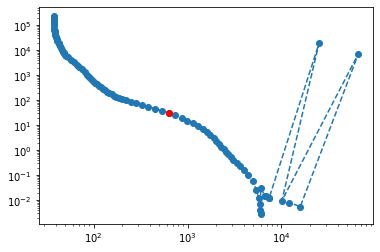

In [17]:
idx = 60
plt.loglog(*fsvals.T, 'o--',)
plt.loglog(*fsvals[idx], 'ro')

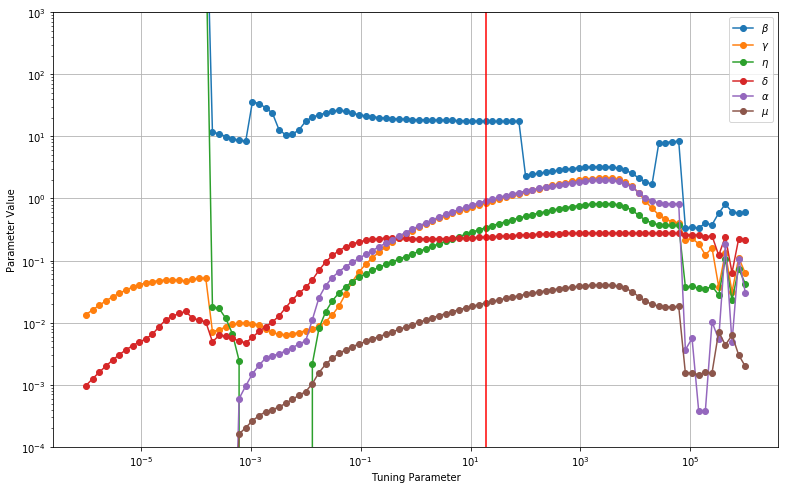

In [40]:
plt.figure(figsize=[13,8])
plt.plot(prange, [float(s['x'][-6]) for s in sols], 'o-', label=r'$\beta$')
plt.plot(prange, [float(s['x'][-5]) for s in sols], 'o-', label=r'$\gamma$')
plt.plot(prange, [float(s['x'][-4]) for s in sols], 'o-', label=r'$\eta$')
plt.plot(prange, [float(s['x'][-3]) for s in sols], 'o-', label=r'$\delta$')
plt.plot(prange, [float(s['x'][-2]) for s in sols], 'o-', label=r'$\alpha$')
plt.plot(prange, [float(s['x'][-1]) for s in sols], 'o-', label=r'$\mu$')
# for q in p0:
#     plt.axhline(q, color='k')
# plt.axhline(0.125, color='k', alpha=0.7)
plt.xscale('log')
plt.xlabel('Tuning Parameter')
plt.ylabel('Parameter Value')
plt.yscale('log')
plt.axvline(prange[idx], color='r')
plt.legend()
plt.ylim([1e-4, 1e3])
plt.grid(True)

13.7997


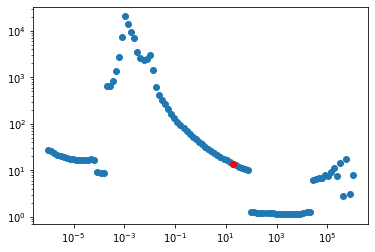

In [19]:
def r0(sol):
    b, g, e, d, a, m = getp(sol['x'])
    return b/(e+a+m)
plt.semilogx(prange, [r0(sol) for sol in sols], 'o')
plt.semilogx(prange[idx], r0(sols[idx]), 'ro')
print(r0(sols[idx]))
plt.yscale('log')

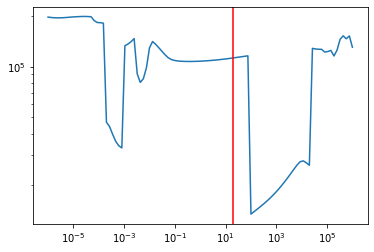

In [20]:
getN = lambda idx: np.mean(np.hstack([np.array(x) for x in getx(sols[idx]['x'])]).sum(axis=1))
plt.loglog(prange, [getN(i) for i,_ in enumerate(prange)])
plt.axvline(prange[idx], color='r')

(DM(17.5234), DM(0.846416), DM(0.338351), DM(0.240001), DM(0.910664), DM(0.0208266))


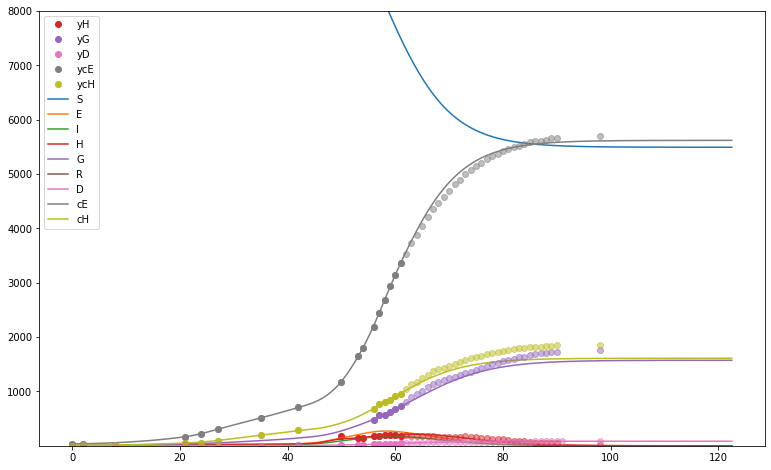

In [21]:
fig, ax=plt.subplots(figsize=[13, 8])
dColours = plt.rcParams['axes.prop_cycle'].by_key()['color']
for clr, data_dots in zip([3,4,6,7,8],[H,G,D,cE,cH]):
    ax.plot(time[start:clip], data_dots[start:clip], 'o', color=dColours[clr])
for clr, data_stripe in zip(dColours, getx(sols[idx]['x'])):
    ax.plot(model.observation_times, data_stripe, color=clr)
for clr, data_dots in zip([3,4,6,7,8],[H,G,D,cE,cH]):
    ax.plot(time, data_dots, 'o', alpha=0.5, color=dColours[clr])
plt.legend(['yH', 'yG', 'yD', 'ycE', 'ycH', 'S', 'E', 'I', 'H', 'G', 'R', 'D', 'cE', 'cH'])
plt.ylim([1e-5, 8000])
print(getp(sols[idx]['x']))

In [22]:
print(list(zip("bgedam", getp(sols[idx]['x']))))

[(lbl, yyy[np.argmin(np.abs(model.observation_times-65))]) for lbl, yyy in zip('seihgrdEH', getx(sols[idx]['x'])) ]

[('b', DM(17.5234)), ('g', DM(0.846416)), ('e', DM(0.338351)), ('d', DM(0.240001)), ('a', DM(0.910664)), ('m', DM(0.0208266))]


[('s', DM(6723.51)),
 ('e', DM(201.444)),
 ('i', DM(141.862)),
 ('h', DM(212.76)),
 ('g', DM(940.35)),
 ('r', DM(99580.4)),
 ('d', DM(58.5958)),
 ('E', DM(4185.5)),
 ('H', DM(1190.85))]

84.4354


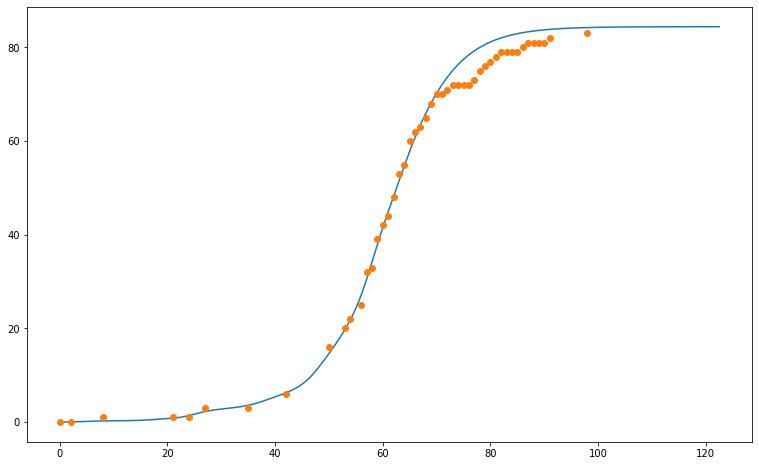

In [23]:
plt.figure(figsize=[13,8])
plt.plot(model.observation_times, getx(sols[idx]['x'])[6])
plt.plot(time, D, 'o')
print(getx(sols[idx]['x'])[6][-1])

(0, 6000)

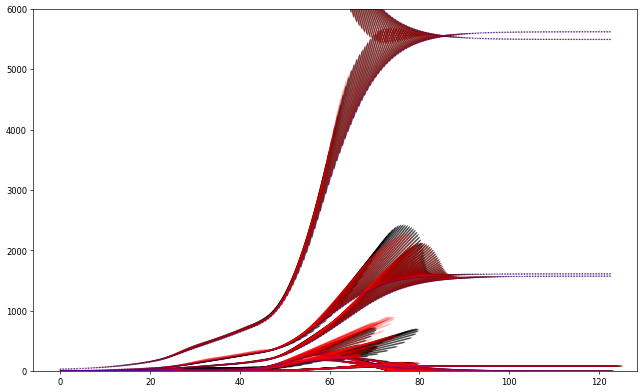

In [24]:
fig, ax=plt.subplots(figsize=[13, 8], dpi=60)
xx = np.vstack([xix.toarray().flatten() for xix in getx(sols[idx]['x'])])
dxxdt = np.vstack([seir(0, xxj, [float(q) for q in getp(sols[idx]['x'])]) for xxj in xx.T])
plt.plot(model.observation_times, xx.T, alpha=0.2, color='b')
for i, xxi in enumerate(xx):
    ax.quiver(model.observation_times, xxi, np.gradient(model.observation_times), dxxdt[:,i], 
              angles='xy', headwidth=0.75, headlength=1, headaxislength=2, width=0.0025, alpha=0.7)
for i, xxi in enumerate(xx):
    ax.quiver(model.observation_times, xxi, np.gradient(model.observation_times), np.gradient(xxi, model.observation_times), color='r', 
              angles='xy', headwidth=0.75, headlength=1, headaxislength=2, width=0.0025, alpha=0.3)
plt.ylim([0, 6000])

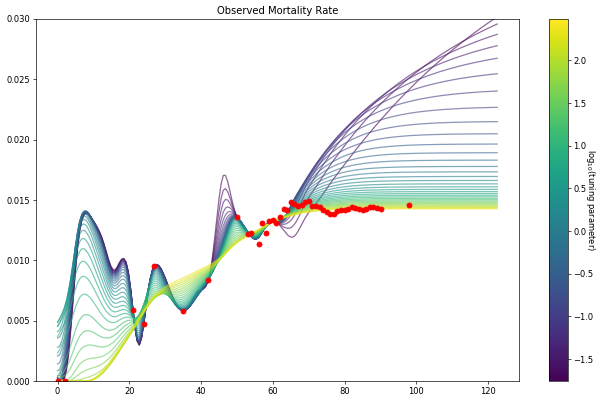

In [43]:
import matplotlib.cm as mplcm
import matplotlib.colors as colors
i0, i1 = (35, -30)

cNorm = colors.Normalize(vmin=np.log10(prange[i0]), vmax=np.log10(prange[i1]))
cm = plt.get_cmap('viridis')
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)

plt.figure(figsize=[13,8], dpi=60)
for i,p in enumerate(prange[i0:i1]):
    plt.plot(model.observation_times, getx(sols[i+i0]['x'])[6]/getx(sols[i+i0]['x'])[-2], 
             color=scalarMap.to_rgba(np.log10(p)), alpha=0.6)
plt.ylim(0, 0.03)
cbar = plt.colorbar(scalarMap)
cbar.set_label(r'$\log_{10}($tuning parameter$)$', rotation=270)
plt.title("Observed Mortality Rate")
plt.plot(time, D/cE, 'ro')

(0, 10000)

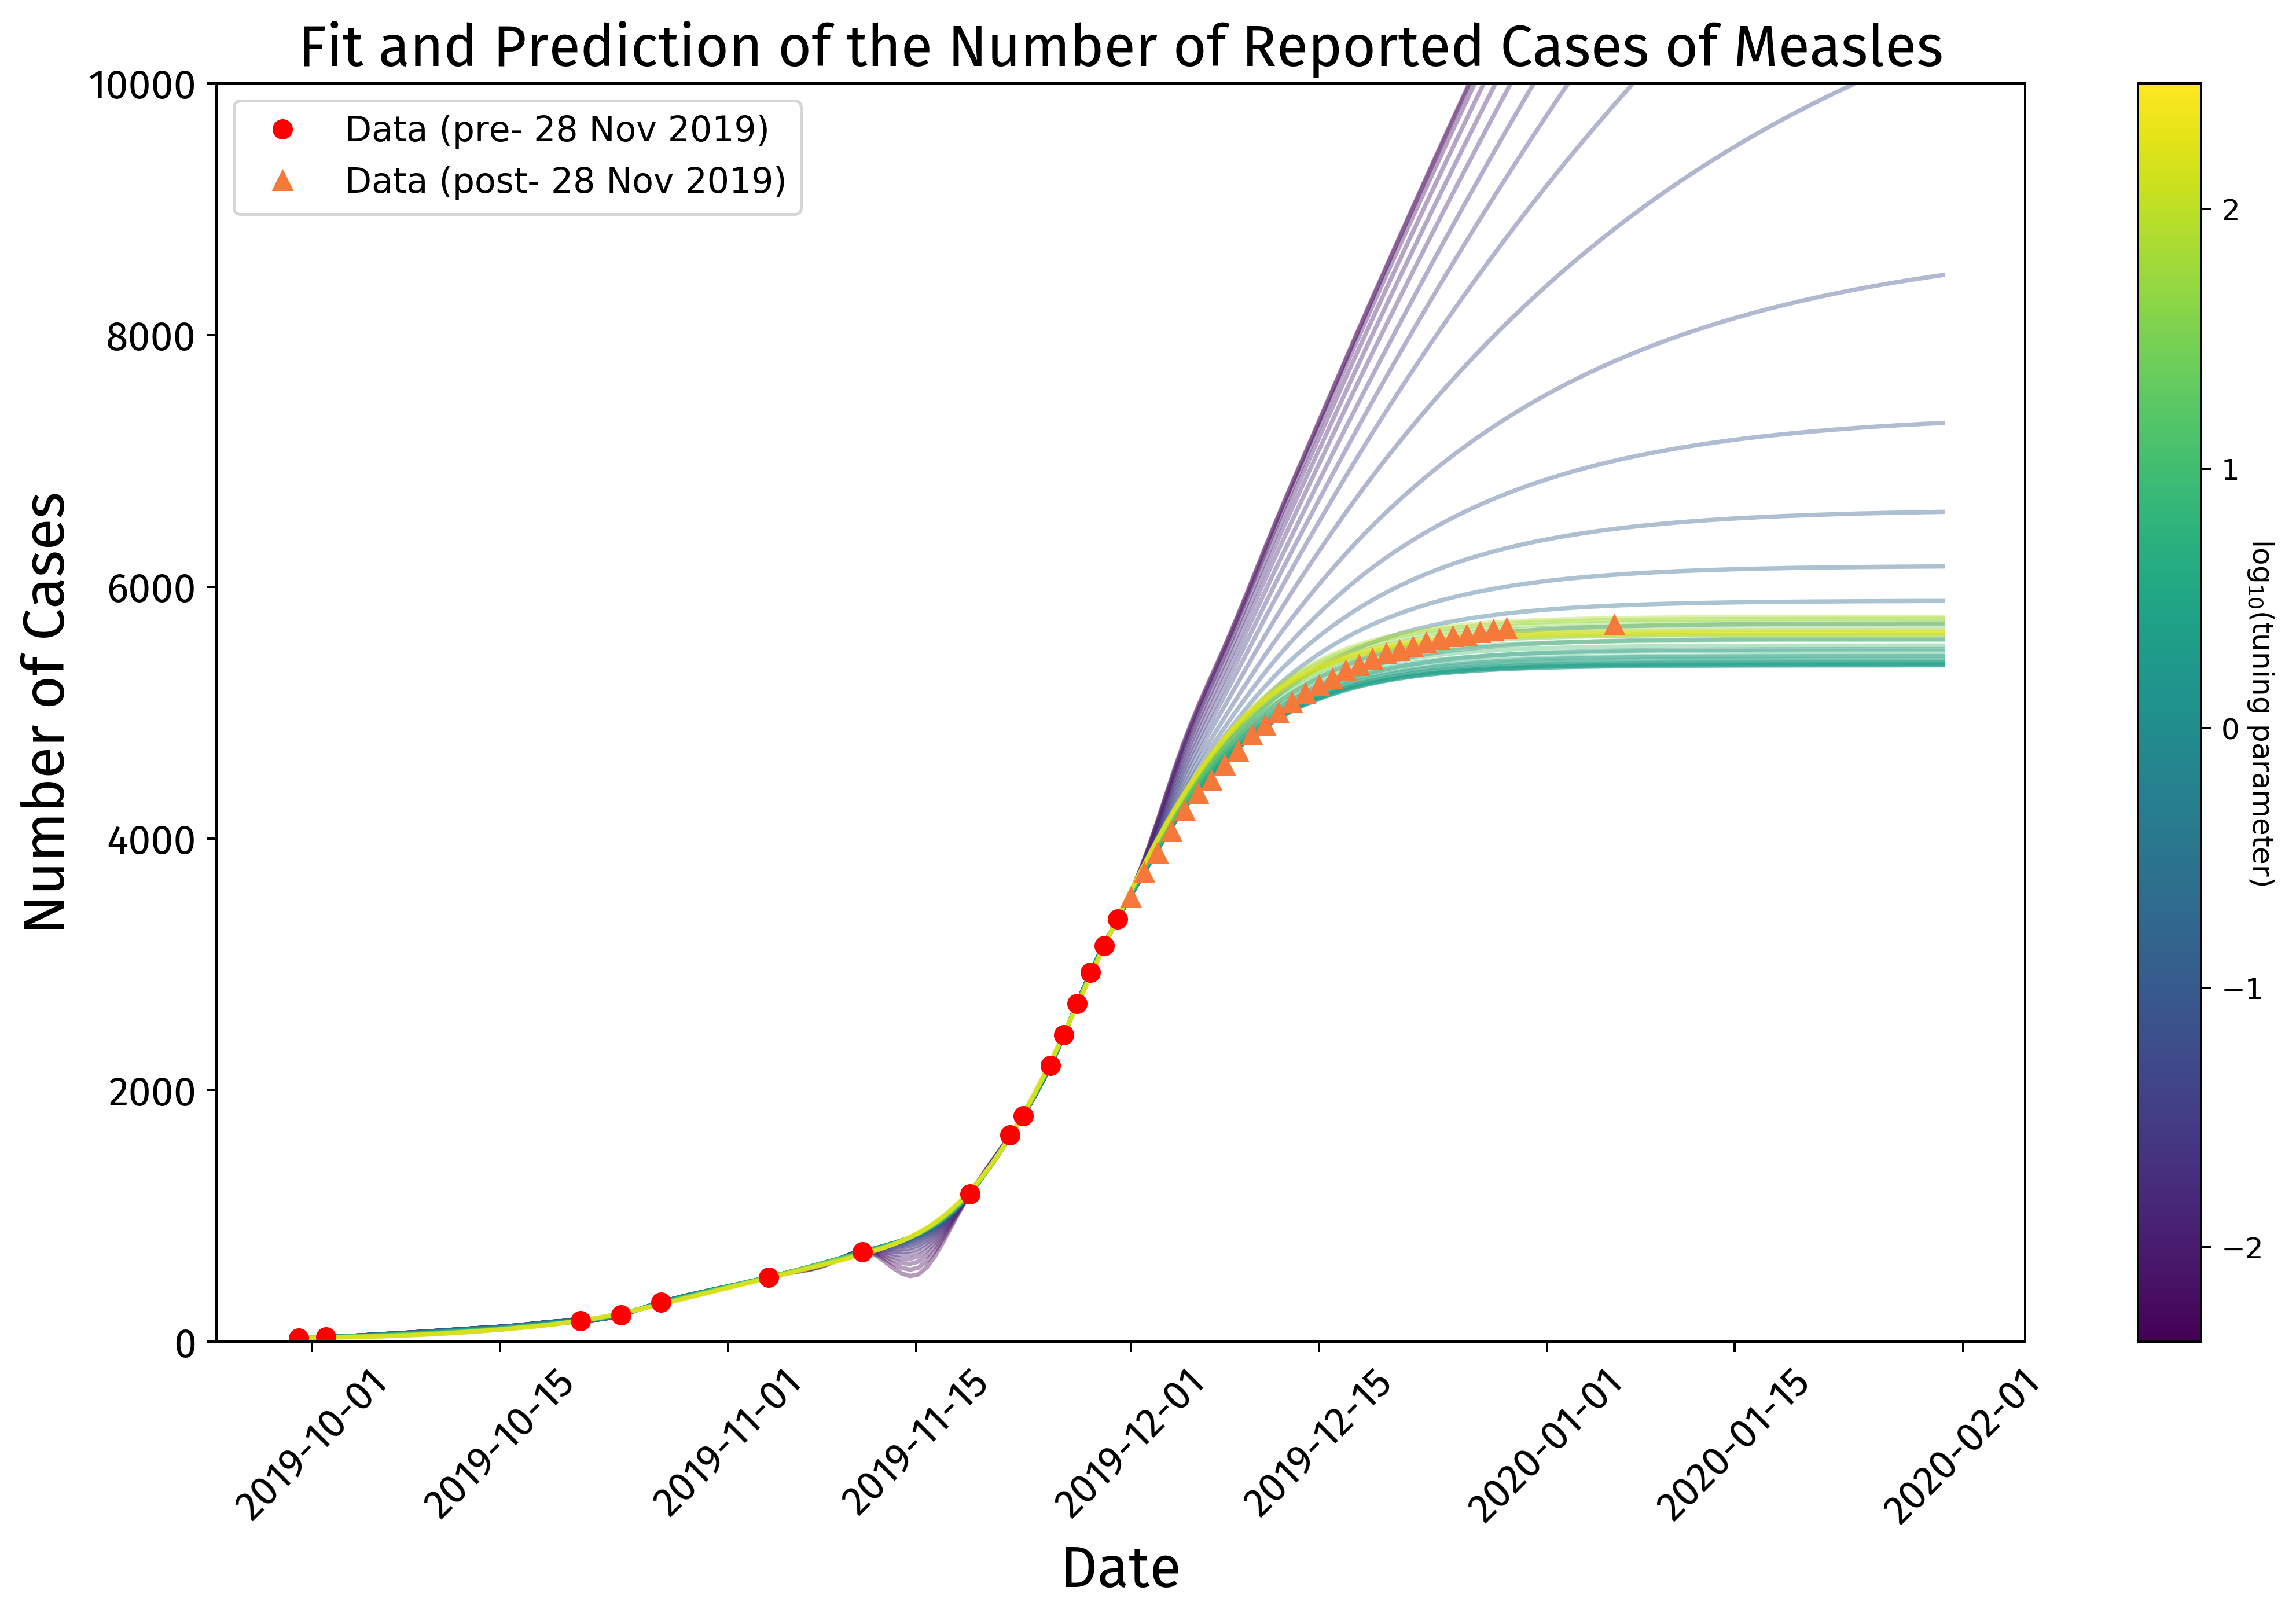

In [62]:
# %matplotlib notebook

plt.figure(figsize=[14,8], dpi=360)

i0, i1 = (30, -30)

cNorm = colors.Normalize(vmin=np.log10(prange[i0]), vmax=np.log10(prange[i1]))
cm = plt.get_cmap('viridis')
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)

for i,p in enumerate(prange[i0:i1:]):
    plt.plot(list(map(time_conv, model.observation_times)), getx(sols[i+i0]['x'])[-2], 
             color=scalarMap.to_rgba(np.log10(p)), alpha=0.4)
plt.plot(the_dates[start:clip], cE[start:clip], 'ro', label='Data (pre- 28 Nov 2019)')
plt.plot(the_dates[clip:], cE[clip:], '^', label='Data (post- 28 Nov 2019)', color='#f5793a')
plt.title("Fit and Prediction of the Number of Reported Cases of Measles", 
          font_properties=label_font)
plt.xlabel("Date", font_properties=label_font)
plt.ylabel("Number of Cases", font_properties=label_font)
plt.xticks(rotation=45, font_properties=tick_font)
plt.yticks(font_properties=tick_font)
cbar = plt.colorbar(scalarMap)
cbar.set_label(r'$\log_{10}($tuning parameter$)$', rotation=270)
plt.legend(fontsize='large')
plt.ylim([0,10000])

(0, 200)

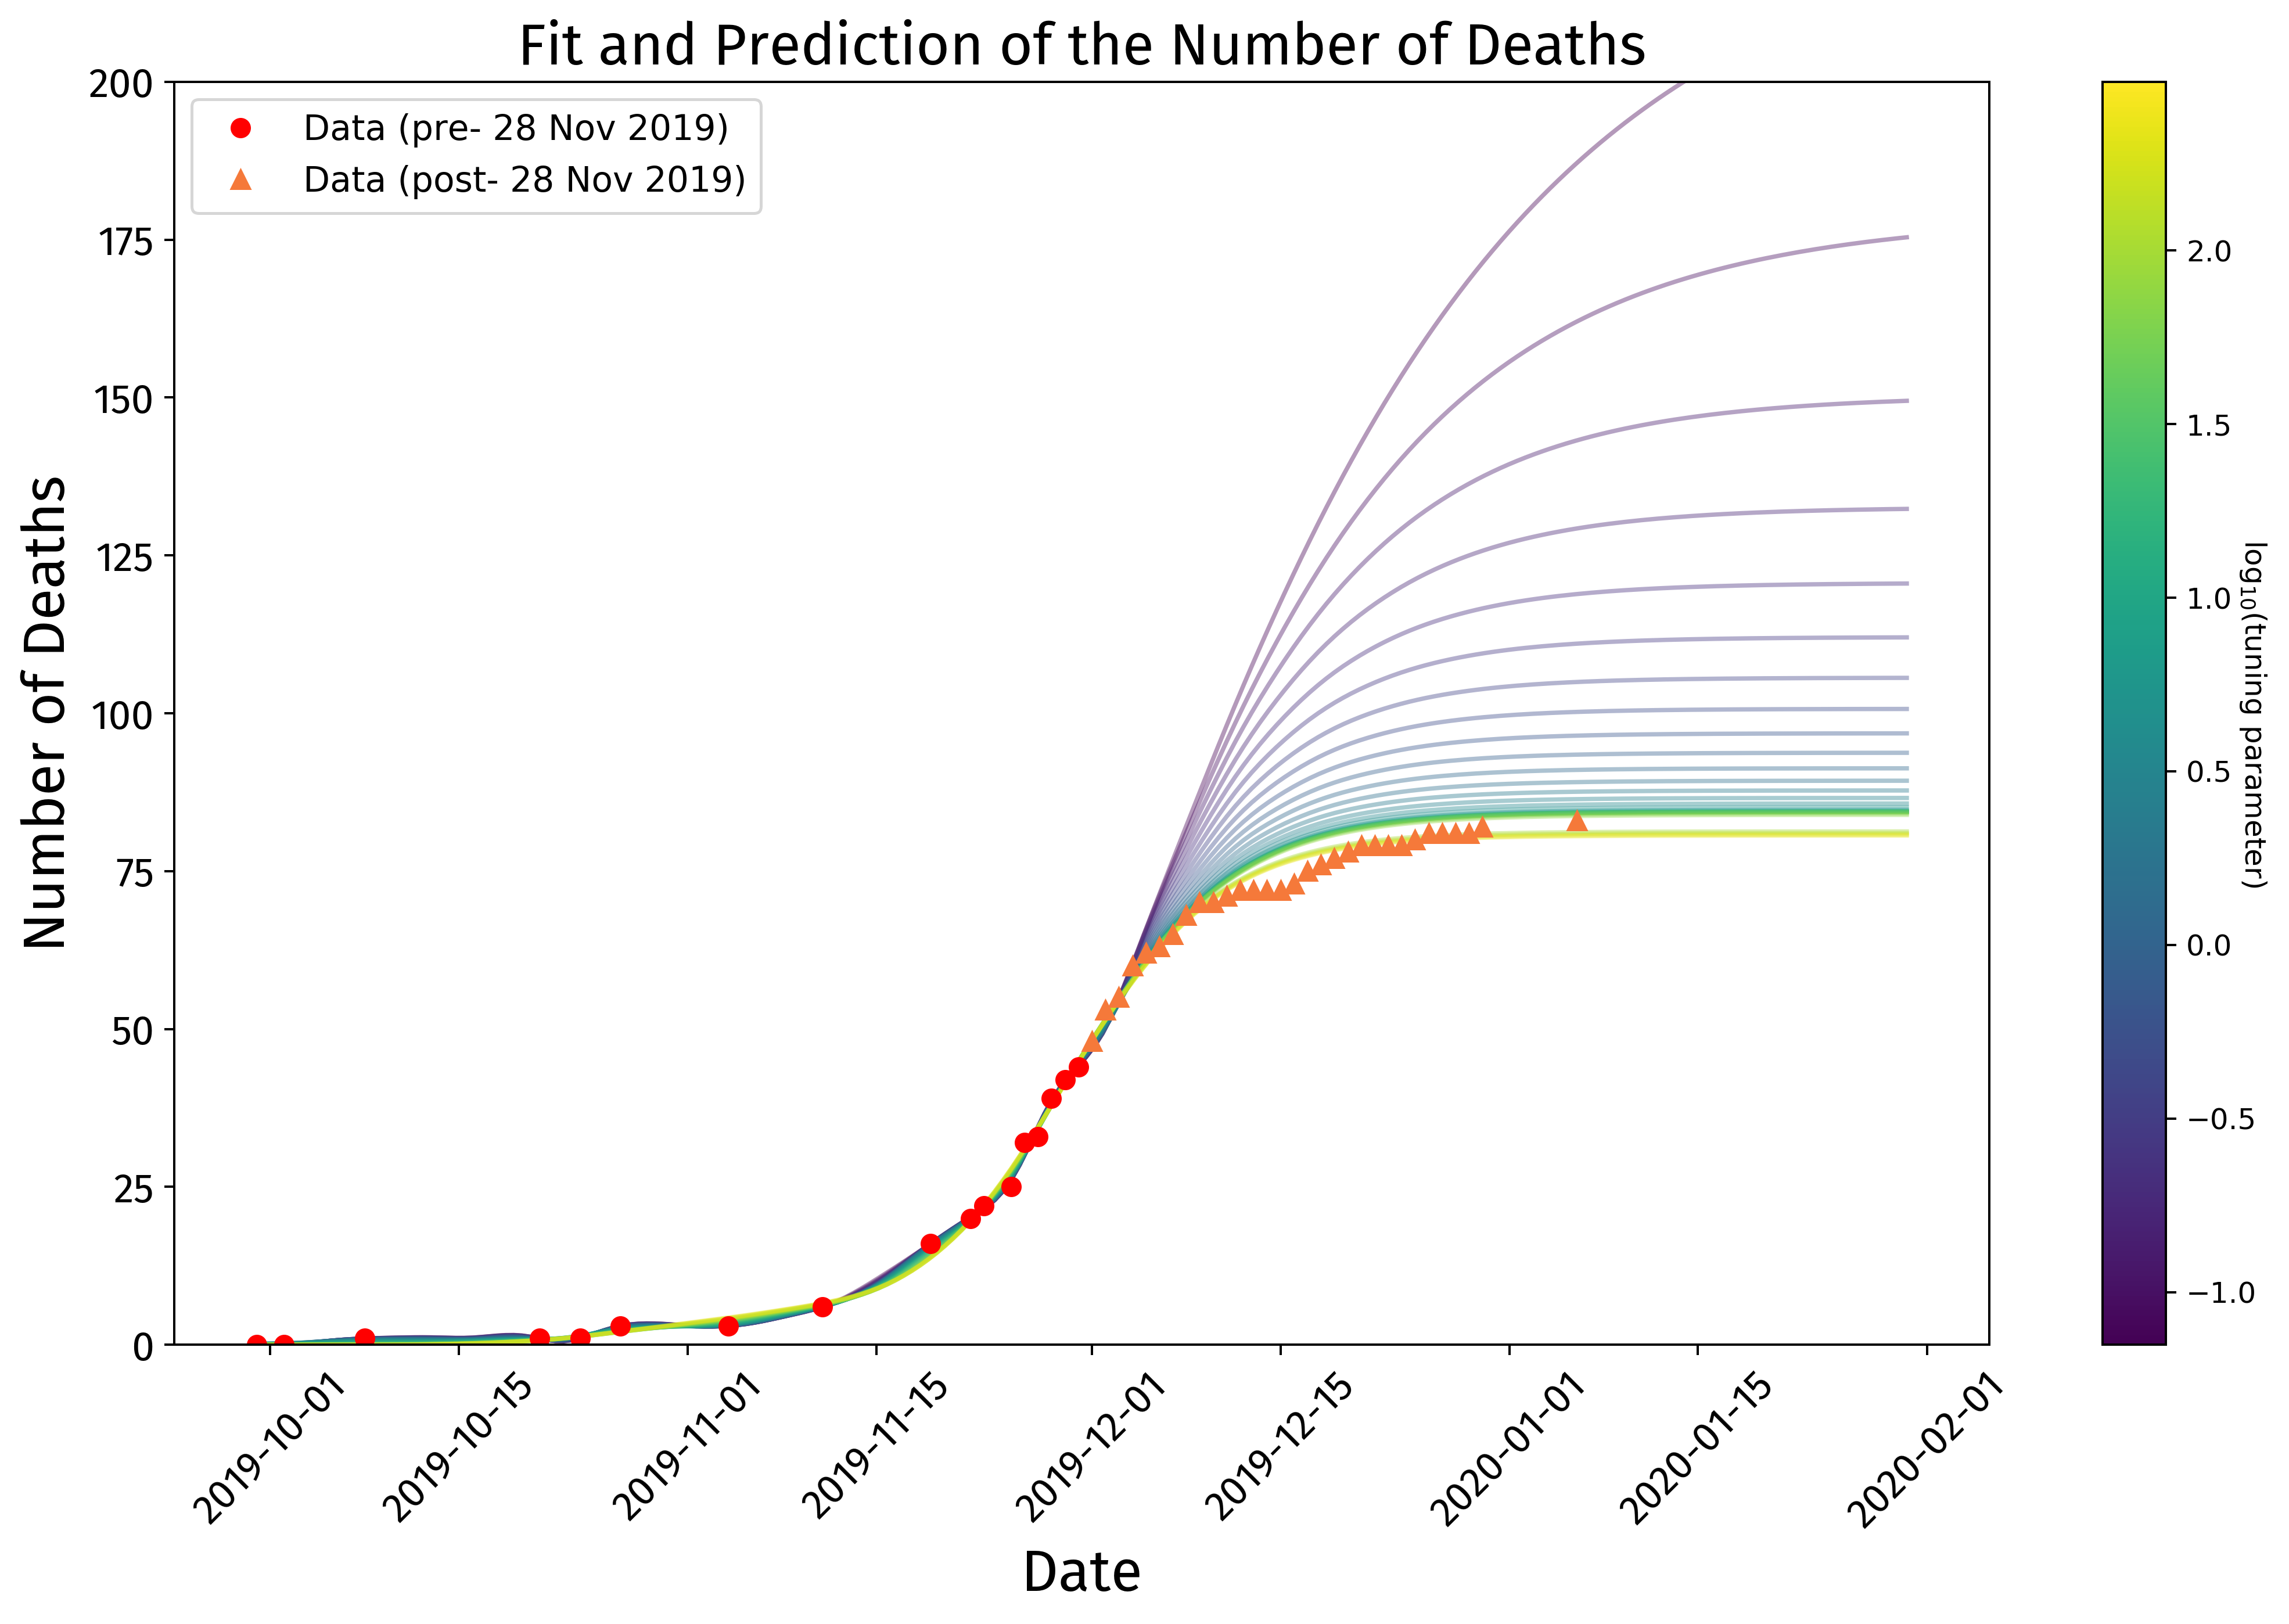

In [61]:
plt.figure(figsize=[14,8], dpi=360)

i0, i1 = (40, -30)

cNorm = colors.Normalize(vmin=np.log10(prange[i0]), vmax=np.log10(prange[i1]))
cm = plt.get_cmap('viridis')
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)


for i,p in enumerate(prange[i0:i1:]):
    plt.plot(list(map(time_conv, model.observation_times)), getx(sols[i+i0]['x'])[6], 
             color=scalarMap.to_rgba(np.log10(p)), alpha=0.4)
plt.plot(the_dates[start:clip], D[start:clip], 'ro', label='Data (pre- 28 Nov 2019)')
plt.plot(the_dates[clip:], D[clip:], '^', label='Data (post- 28 Nov 2019)', color='#f5793a')
plt.title("Fit and Prediction of the Number of Deaths", font_properties=label_font)
plt.xlabel("Date", font_properties=label_font)
plt.ylabel("Number of Deaths", font_properties=label_font)
plt.xticks(rotation=45, font_properties=tick_font)
plt.yticks(font_properties=tick_font)
cbar = plt.colorbar(scalarMap)
cbar.set_label(r'$\log_{10}($tuning parameter$)$', rotation=270)
plt.legend(fontsize='large')
plt.ylim([0, 200])

array([13342.29994238, 13342.29994238])

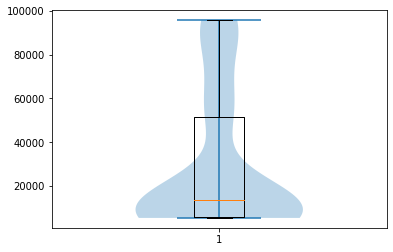

In [29]:
plt.violinplot([getx(sols[i]['x'])[-2][-1] for i in range(100)])
bx=plt.boxplot([getx(sols[i]['x'])[-2][-1] for i in range(100)])
bx['medians'][0].get_ydata()
# plt.yscale('log')

In [30]:
np.min([getx(sols[i]['x'])[-2][-1] for i in range(100)])

5374.588539306124

In [31]:
np.unique(bx['boxes'][0].get_ydata())

array([ 5739.04326226, 51678.44099865])

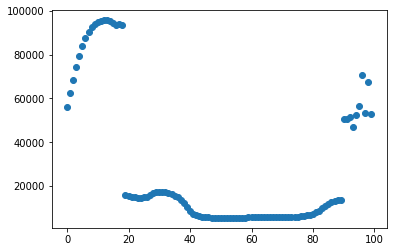

In [32]:
plt.plot([getx(sols[i]['x'])[-2][-1] for i in range(100)],'o')

(0, 100)

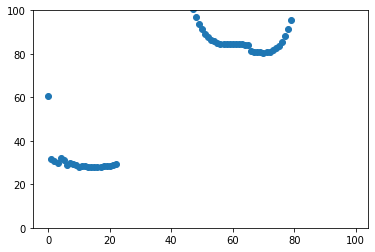

In [33]:
plt.plot([getx(sols[i]['x'])[6][-1] for i in range(100)],'o')
plt.ylim([0, 100])

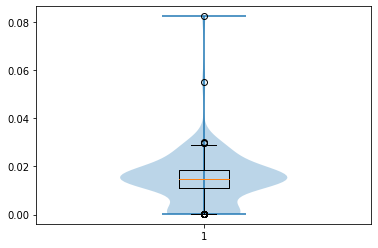

In [34]:
plt.violinplot([(getx(sols[i]['x'])[6]/getx(sols[i]['x'])[-2])[-1] for i in range(100)])
bx = plt.boxplot([(getx(sols[i]['x'])[6]/getx(sols[i]['x'])[-2])[-1] for i in range(100)])


In [35]:
np.unique(bx['boxes'][0].get_ydata())

array([0.01121816, 0.01840127])

In [36]:
morts = [getx(sols[i]['x'])[6][-1] for i in range(100)]
print(np.min(morts))
print(np.median(morts))

27.962077127848968
90.28084037534157


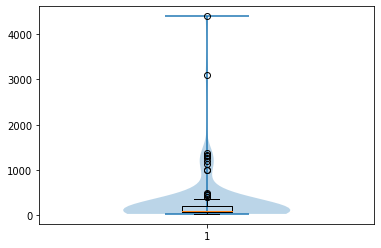

In [37]:
plt.violinplot(morts)
bx = plt.boxplot(morts)


In [38]:
np.unique(bx['boxes'][0].get_ydata())

array([ 80.70375659, 201.67429943])

In [39]:
from scipy import interpolate

print(interpolate.interp1d(model.observation_times, getx(sols[idx]['x'])[-2].toarray().flatten())(data_time[-1]+1))
print(interpolate.interp1d(model.observation_times, getx(sols[idx]['x'])[-3].toarray().flatten())(data_time[-1]+1))

3571.912515646278
48.17722218587369
